In [1]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import plot_model

import keras

import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score
)

from imblearn.over_sampling import SMOTE

c:\Users\micha\anaconda3\envs\msds-data-science-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Load the dataset
df = pd.read_csv("datasets/3. online_shoppers_intention_clean.csv")

# 2. Select relevant columns
# df = df[[
#     "Administrative", "Informational", "ProductRelated",
#     "BounceRates", "ExitRates", "PageValues", "Month",
#     "TrafficType", "VisitorType", "Revenue"
# ]]

# 3. Separate input features and target
X = df.drop(columns=["Revenue"])
y = df["Revenue"]

# 4. Split the data into train_val and test sets (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Split the train_val into training and validation sets (75% train, 25% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)  # 0.25 x 0.8 = 0.2

# 6. Define numerical and categorical columns
numerical_features = [
    "Administrative",
    "Administrative_Duration",
    "Informational",
    "Informational_Duration",
    "ProductRelated",
    "ProductRelated_Duration",
    "BounceRates",
    "ExitRates",
    "PageValues",
    "SpecialDay"
]
categorical_features = [
    "Month",
    "OperatingSystems",
    "Browser",
    "Region",
    "TrafficType",
    "VisitorType",
    "Weekend"
]

# 7. Preprocess numerical features
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[numerical_features])

# Transform the numerical features
X_train_scaled = min_max_scaler.transform(X_train[numerical_features])
X_val_scaled = min_max_scaler.transform(X_val[numerical_features])
X_test_scaled = min_max_scaler.transform(X_test[numerical_features])

# Convert scaled arrays back to dataframes for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_features, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=numerical_features, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_features, index=X_test.index)

# 8. Preprocess categorical features
# Initialise the OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False turns the data into NumPy array

# Fit the encoder on the training data
one_hot_encoder.fit(X_train[categorical_features])

# Transform the categorical features
X_train_encoded = one_hot_encoder.transform(X_train[categorical_features])
X_val_encoded = one_hot_encoder.transform(X_val[categorical_features])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_features])

# Get the new feature names after one-hot encoding
encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_features)

# Convert encoded arrays back to dataframes
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_val_encoded = pd.DataFrame(X_val_encoded, columns=encoded_feature_names, index=X_val.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# 9. Combine processed features
X_train_processed = pd.concat([X_train_scaled, X_train_encoded], axis=1)
X_val_processed = pd.concat([X_val_scaled, X_val_encoded], axis=1)
X_test_processed = pd.concat([X_test_scaled, X_test_encoded], axis=1)

# Verify the shapes
print("Processed Training Data Shape:", X_train_processed.shape)
print("Processed Validation Data Shape:", X_val_processed.shape)
print("Processed Test Data Shape:", X_test_processed.shape)

# 10. Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Verify the resampled data
# print("Resampled Training Data Shape:", X_train_resampled.shape)
# print("Resampled Training Target Distribution:\n", y_train_resampled.value_counts())

# 11. Reset indices
X_train_processed.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_val_processed.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

X_test_processed.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# 12. Final verification
print("Final Training Data Shape:", X_train_processed.shape)
print("Final Validation Data Shape:", X_val_processed.shape)
print("Final Test Data Shape:", X_test_processed.shape)

Processed Training Data Shape: (7334, 74)
Processed Validation Data Shape: (2445, 74)
Processed Test Data Shape: (2445, 74)
Final Training Data Shape: (7334, 74)
Final Validation Data Shape: (2445, 74)
Final Test Data Shape: (2445, 74)


# WARNING: DO NOT RUN THE CELL BELOW IF YOU DO NOT WANT TO RUN OPTIMISATION, AS IT MAY TAKE HOURS TO DAYS TO COMPLETE

In [ ]:
# 13. Set seed for reproducability
keras.utils.set_random_seed(42)

# 14. Define the function to create NN model
def create_model(trial):
    # Hyperparameters to tune
    n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 3)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    n_neurons = trial.suggest_int('n_neurons', 16, 128)
    
    # Choose the optimiser
    optimizer = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate)
    }[optimizer_name]
    
    # Build the model
    model = Sequential()
    
    # Add input layer
    model.add(Input(shape=(X_train_processed.shape[1],)))  # Dynamically adjusts based on the number of columns of the dataset
    
    # First hidden layer
    model.add(Dense(n_neurons, activation=activation))
    
    # Additional hidden layers 
    for i in range(n_hidden_layers - 1):  # -1 as already added the first layer
        model.add(Dense(n_neurons, activation=activation))
        model.add(Dropout(dropout_rate)) # Add dropout layer to minimise overfitting
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# 15. Define the objective function for Optuna
def objective(trial):
    try:
        # Create the model
        model = create_model(trial)
        
        # Suggest batch size
        batch_size = trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128])
        
        # Define early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=20
        )
        
        # Train the model
        history = model.fit(
            X_train_processed, y_train,
            validation_data=(X_val_processed, y_val),
            epochs=100,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Evaluate the model on validation data
        score = model.evaluate(X_val_processed, y_val, verbose=0)
        return score[1]  # Return validation accuracy

    finally:
        # Clear keras session to free memory
        K.clear_session()

# 16. Create the study
study_name = "neural_network_optimisation_4"
storage_name = "sqlite:///optuna_study_neural_network_4.db" # Use .db so that a record store of all trials will be saved

study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    direction='maximize', # Maximize accuracy for binary classification
    sampler=optuna.samplers.TPESampler(seed=42))  

# 17. Optimise the study objective function with 1000 trials
study.optimize(objective, n_trials=1000, timeout=None, show_progress_bar=True)

# 18. Retrieve and display the best trial
print("\nBest trial:")
trial = study.best_trial
print(f"  Validation Accuracy: {trial.value:.4f}")
print("  Hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

c:\Users\micha\anaconda3\envs\msds-data-science-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-20 22:16:35,097] A new study created in RDB with name: neural_network_optimisation_4
  0%|          | 0/1000 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.843763:   0%|          | 1/1000 [02:57<49:10:23, 177.20s/it]

[I 2024-10-20 22:19:32,293] Trial 0 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 2.9380279387035334e-05, 'optimizer': 'sgd', 'dropout_rate': 0.34044600469728353, 'n_neurons': 96, 'batch_size': 2}. Best is trial 0 with value: 0.8437627553939819.


Best trial: 0. Best value: 0.843763:   0%|          | 2/1000 [03:07<21:57:39, 79.22s/it] 

[I 2024-10-20 22:19:42,925] Trial 1 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 7.52374288453485e-05, 'optimizer': 'sgd', 'dropout_rate': 0.1798695128633439, 'n_neurons': 74, 'batch_size': 64}. Best is trial 0 with value: 0.8437627553939819.


Best trial: 0. Best value: 0.843763:   0%|          | 3/1000 [03:32<15:04:19, 54.42s/it]

[I 2024-10-20 22:20:07,840] Trial 2 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 2.32335035153901e-05, 'optimizer': 'sgd', 'dropout_rate': 0.20351199264000677, 'n_neurons': 90, 'batch_size': 16}. Best is trial 0 with value: 0.8437627553939819.


Best trial: 0. Best value: 0.843763:   0%|          | 4/1000 [03:49<10:56:51, 39.57s/it]

[I 2024-10-20 22:20:24,641] Trial 3 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 1.3667272915456215e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.43149500366077176, 'n_neurons': 56, 'batch_size': 32}. Best is trial 0 with value: 0.8437627553939819.


Best trial: 4. Best value: 0.881391:   0%|          | 5/1000 [03:53<7:23:31, 26.75s/it] 

[I 2024-10-20 22:20:28,648] Trial 4 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'relu', 'learning_rate': 0.0020597335357437196, 'optimizer': 'rmsprop', 'dropout_rate': 0.4452413703502375, 'n_neurons': 86, 'batch_size': 64}. Best is trial 4 with value: 0.8813905715942383.


Best trial: 5. Best value: 0.885072:   1%|          | 6/1000 [04:12<6:37:50, 24.01s/it]

[I 2024-10-20 22:20:47,361] Trial 5 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.002055424552015075, 'optimizer': 'rmsprop', 'dropout_rate': 0.11016765069763808, 'n_neurons': 28, 'batch_size': 16}. Best is trial 5 with value: 0.8850715756416321.


Best trial: 5. Best value: 0.885072:   1%|          | 7/1000 [04:56<8:27:43, 30.68s/it]

[I 2024-10-20 22:21:31,759] Trial 6 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.006153085601625313, 'optimizer': 'sgd', 'dropout_rate': 0.4214688307596458, 'n_neurons': 37, 'batch_size': 8}. Best is trial 5 with value: 0.8850715756416321.


Best trial: 5. Best value: 0.885072:   1%|          | 8/1000 [05:46<10:10:35, 36.93s/it]

[I 2024-10-20 22:22:22,081] Trial 7 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.000178744632562384, 'optimizer': 'sgd', 'dropout_rate': 0.47716388156500766, 'n_neurons': 52, 'batch_size': 8}. Best is trial 5 with value: 0.8850715756416321.


Best trial: 5. Best value: 0.885072:   1%|          | 9/1000 [09:45<27:32:28, 100.05s/it]

[I 2024-10-20 22:26:20,914] Trial 8 finished with value: 0.8474437594413757 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 1.4270403521460843e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.15795794883648925, 'n_neurons': 71, 'batch_size': 1}. Best is trial 5 with value: 0.8850715756416321.


Best trial: 5. Best value: 0.885072:   1%|          | 10/1000 [09:55<19:49:32, 72.09s/it]

[I 2024-10-20 22:26:30,410] Trial 9 finished with value: 0.843353807926178 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 9.169384722192322e-05, 'optimizer': 'sgd', 'dropout_rate': 0.37102574473691297, 'n_neurons': 17, 'batch_size': 64}. Best is trial 5 with value: 0.8850715756416321.


Best trial: 10. Best value: 0.886299:   1%|          | 11/1000 [10:01<14:13:53, 51.80s/it]

[I 2024-10-20 22:26:36,207] Trial 10 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0010814898799911025, 'optimizer': 'adam', 'dropout_rate': 0.10580532285527432, 'n_neurons': 118, 'batch_size': 128}. Best is trial 10 with value: 0.8862985968589783.


Best trial: 11. Best value: 0.887935:   1%|          | 12/1000 [10:06<10:22:58, 37.83s/it]

[I 2024-10-20 22:26:42,085] Trial 11 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0008533716477932964, 'optimizer': 'adam', 'dropout_rate': 0.1034732657714607, 'n_neurons': 123, 'batch_size': 128}. Best is trial 11 with value: 0.8879345655441284.


Best trial: 11. Best value: 0.887935:   1%|▏         | 13/1000 [10:15<7:57:58, 29.06s/it] 

[I 2024-10-20 22:26:50,946] Trial 12 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0006630599890152523, 'optimizer': 'adam', 'dropout_rate': 0.25198404889665726, 'n_neurons': 125, 'batch_size': 128}. Best is trial 11 with value: 0.8879345655441284.


Best trial: 11. Best value: 0.887935:   1%|▏         | 14/1000 [10:22<6:05:48, 22.26s/it]

[I 2024-10-20 22:26:57,502] Trial 13 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0006754735116417325, 'optimizer': 'adam', 'dropout_rate': 0.11343435397378901, 'n_neurons': 128, 'batch_size': 128}. Best is trial 11 with value: 0.8879345655441284.


Best trial: 11. Best value: 0.887935:   2%|▏         | 15/1000 [10:31<5:00:24, 18.30s/it]

[I 2024-10-20 22:27:06,624] Trial 14 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0005797095562049423, 'optimizer': 'adam', 'dropout_rate': 0.25972859935882964, 'n_neurons': 109, 'batch_size': 128}. Best is trial 11 with value: 0.8879345655441284.


Best trial: 15. Best value: 0.891616:   2%|▏         | 16/1000 [11:30<8:23:02, 30.67s/it]

[I 2024-10-20 22:28:06,030] Trial 15 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0002637971509108439, 'optimizer': 'adam', 'dropout_rate': 0.2664125867669593, 'n_neurons': 108, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   2%|▏         | 17/1000 [12:45<12:00:24, 43.97s/it]

[I 2024-10-20 22:29:20,930] Trial 16 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00023178255578781314, 'optimizer': 'adam', 'dropout_rate': 0.28910431514753326, 'n_neurons': 106, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   2%|▏         | 18/1000 [13:41<12:56:04, 47.42s/it]

[I 2024-10-20 22:30:16,368] Trial 17 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00867514565549096, 'optimizer': 'adam', 'dropout_rate': 0.22567943252489175, 'n_neurons': 107, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   2%|▏         | 19/1000 [15:30<17:58:21, 65.95s/it]

[I 2024-10-20 22:32:05,505] Trial 18 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 9.637313004562988e-05, 'optimizer': 'adam', 'dropout_rate': 0.3628581217310246, 'n_neurons': 114, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   2%|▏         | 20/1000 [15:39<13:19:56, 48.98s/it]

[I 2024-10-20 22:32:14,911] Trial 19 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0029232789253931593, 'optimizer': 'adam', 'dropout_rate': 0.31570911156585285, 'n_neurons': 99, 'batch_size': 32}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   2%|▏         | 21/1000 [19:38<28:49:35, 106.00s/it]

[I 2024-10-20 22:36:13,865] Trial 20 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00019012533762475053, 'optimizer': 'adam', 'dropout_rate': 0.1568446197802504, 'n_neurons': 79, 'batch_size': 1}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   2%|▏         | 22/1000 [19:48<20:56:41, 77.10s/it] 

[I 2024-10-20 22:36:23,559] Trial 21 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0005000102512307862, 'optimizer': 'adam', 'dropout_rate': 0.26162871467236254, 'n_neurons': 114, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   2%|▏         | 23/1000 [19:57<15:25:02, 56.81s/it]

[I 2024-10-20 22:36:33,047] Trial 22 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00039065258915461497, 'optimizer': 'adam', 'dropout_rate': 0.28488621851758633, 'n_neurons': 104, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   2%|▏         | 24/1000 [21:05<16:18:35, 60.16s/it]

[I 2024-10-20 22:37:41,021] Trial 23 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0010631801918654915, 'optimizer': 'adam', 'dropout_rate': 0.22749703839846275, 'n_neurons': 120, 'batch_size': 2}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   2%|▎         | 25/1000 [21:47<14:44:53, 54.45s/it]

[I 2024-10-20 22:38:22,169] Trial 24 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.001131968844303816, 'optimizer': 'adam', 'dropout_rate': 0.39451723519544335, 'n_neurons': 109, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   3%|▎         | 26/1000 [21:56<11:03:17, 40.86s/it]

[I 2024-10-20 22:38:31,310] Trial 25 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0003032640653926165, 'optimizer': 'adam', 'dropout_rate': 0.15443549377024232, 'n_neurons': 92, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   3%|▎         | 27/1000 [22:05<8:26:47, 31.25s/it] 

[I 2024-10-20 22:38:40,141] Trial 26 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0001422786163175125, 'optimizer': 'adam', 'dropout_rate': 0.32745487217134384, 'n_neurons': 127, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   3%|▎         | 28/1000 [22:35<8:20:51, 30.92s/it]

[I 2024-10-20 22:39:10,281] Trial 27 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.003978817535319807, 'optimizer': 'adam', 'dropout_rate': 0.2547390027632272, 'n_neurons': 64, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   3%|▎         | 29/1000 [22:43<6:32:52, 24.28s/it]

[I 2024-10-20 22:39:19,063] Trial 28 finished with value: 0.8719836473464966 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 5.251274561288758e-05, 'optimizer': 'adam', 'dropout_rate': 0.20117575701929924, 'n_neurons': 86, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   3%|▎         | 30/1000 [23:49<9:53:59, 36.74s/it]

[I 2024-10-20 22:40:24,889] Trial 29 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.00159312573985587, 'optimizer': 'rmsprop', 'dropout_rate': 0.35198198761872923, 'n_neurons': 99, 'batch_size': 2}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   3%|▎         | 31/1000 [23:56<7:27:42, 27.72s/it]

[I 2024-10-20 22:40:31,566] Trial 30 finished with value: 0.852351725101471 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0004389810474229044, 'optimizer': 'adam', 'dropout_rate': 0.30337331728624567, 'n_neurons': 117, 'batch_size': 32}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   3%|▎         | 32/1000 [24:05<5:54:35, 21.98s/it]

[I 2024-10-20 22:40:40,143] Trial 31 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0005824931709672412, 'optimizer': 'adam', 'dropout_rate': 0.2686011928734298, 'n_neurons': 114, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   3%|▎         | 33/1000 [24:14<4:53:36, 18.22s/it]

[I 2024-10-20 22:40:49,585] Trial 32 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00029988427379670535, 'optimizer': 'adam', 'dropout_rate': 0.2315054819503237, 'n_neurons': 97, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   3%|▎         | 34/1000 [24:32<4:51:24, 18.10s/it]

[I 2024-10-20 22:41:07,409] Trial 33 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0005672064243665323, 'optimizer': 'adam', 'dropout_rate': 0.19179415208983377, 'n_neurons': 121, 'batch_size': 16}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   4%|▎         | 35/1000 [24:40<4:05:09, 15.24s/it]

[I 2024-10-20 22:41:15,987] Trial 34 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00014037793808323592, 'optimizer': 'adam', 'dropout_rate': 0.25248950079127197, 'n_neurons': 111, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   4%|▎         | 36/1000 [24:49<3:33:51, 13.31s/it]

[I 2024-10-20 22:41:24,790] Trial 35 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0009122079099173142, 'optimizer': 'sgd', 'dropout_rate': 0.13746743079717172, 'n_neurons': 101, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   4%|▎         | 37/1000 [25:01<3:28:27, 12.99s/it]

[I 2024-10-20 22:41:37,022] Trial 36 finished with value: 0.8768916130065918 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 4.679604940805048e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.3319218784354455, 'n_neurons': 80, 'batch_size': 64}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   4%|▍         | 38/1000 [25:20<3:54:16, 14.61s/it]

[I 2024-10-20 22:41:55,423] Trial 37 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.001555802829050049, 'optimizer': 'adam', 'dropout_rate': 0.2148776849232244, 'n_neurons': 92, 'batch_size': 8}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   4%|▍         | 39/1000 [25:50<5:06:55, 19.16s/it]

[I 2024-10-20 22:42:25,208] Trial 38 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 2, 'activation': 'relu', 'learning_rate': 0.000384680815045766, 'optimizer': 'sgd', 'dropout_rate': 0.17902074137576357, 'n_neurons': 122, 'batch_size': 16}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   4%|▍         | 40/1000 [27:10<10:02:26, 37.65s/it]

[I 2024-10-20 22:43:46,001] Trial 39 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0024425497181118, 'optimizer': 'rmsprop', 'dropout_rate': 0.2740463133867805, 'n_neurons': 46, 'batch_size': 1}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   4%|▍         | 41/1000 [29:08<16:22:57, 61.50s/it]

[I 2024-10-20 22:45:43,142] Trial 40 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00027523492480461235, 'optimizer': 'adam', 'dropout_rate': 0.3986377470523357, 'n_neurons': 113, 'batch_size': 2}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   4%|▍         | 42/1000 [29:17<12:11:53, 45.84s/it]

[I 2024-10-20 22:45:52,440] Trial 41 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0004253215438146116, 'optimizer': 'adam', 'dropout_rate': 0.24198462881706995, 'n_neurons': 96, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   4%|▍         | 43/1000 [29:26<9:17:43, 34.97s/it] 

[I 2024-10-20 22:46:02,042] Trial 42 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00022611499506648496, 'optimizer': 'adam', 'dropout_rate': 0.2966346240227641, 'n_neurons': 106, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   4%|▍         | 44/1000 [29:34<7:06:54, 26.79s/it]

[I 2024-10-20 22:46:09,762] Trial 43 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0007658430267841039, 'optimizer': 'adam', 'dropout_rate': 0.23228346090309598, 'n_neurons': 95, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   4%|▍         | 45/1000 [29:43<5:38:28, 21.27s/it]

[I 2024-10-20 22:46:18,130] Trial 44 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0007013819517262348, 'optimizer': 'sgd', 'dropout_rate': 0.4994563730237146, 'n_neurons': 86, 'batch_size': 128}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   5%|▍         | 46/1000 [29:58<5:10:16, 19.51s/it]

[I 2024-10-20 22:46:33,556] Trial 45 finished with value: 0.8535787463188171 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0013586117584151152, 'optimizer': 'adam', 'dropout_rate': 0.1775425081018965, 'n_neurons': 116, 'batch_size': 8}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   5%|▍         | 47/1000 [30:08<4:25:30, 16.72s/it]

[I 2024-10-20 22:46:43,743] Trial 46 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.0007969427097042996, 'optimizer': 'adam', 'dropout_rate': 0.26912158748243514, 'n_neurons': 123, 'batch_size': 64}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   5%|▍         | 48/1000 [30:53<6:36:51, 25.01s/it]

[I 2024-10-20 22:47:28,112] Trial 47 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0005390764387156204, 'optimizer': 'adam', 'dropout_rate': 0.12904531870407998, 'n_neurons': 102, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   5%|▍         | 49/1000 [31:17<6:32:23, 24.76s/it]

[I 2024-10-20 22:47:52,276] Trial 48 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0038549209060009565, 'optimizer': 'rmsprop', 'dropout_rate': 0.12643290720276357, 'n_neurons': 103, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   5%|▌         | 50/1000 [32:34<10:42:15, 40.56s/it]

[I 2024-10-20 22:49:09,720] Trial 49 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014585054467063677, 'optimizer': 'adam', 'dropout_rate': 0.13514499343449954, 'n_neurons': 67, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   5%|▌         | 51/1000 [34:08<14:52:33, 56.43s/it]

[I 2024-10-20 22:50:43,179] Trial 50 finished with value: 0.8458077907562256 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011908646938452364, 'optimizer': 'sgd', 'dropout_rate': 0.1455064838616461, 'n_neurons': 68, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   5%|▌         | 52/1000 [35:32<17:03:16, 64.76s/it]

[I 2024-10-20 22:52:07,383] Trial 51 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018083771448261125, 'optimizer': 'adam', 'dropout_rate': 0.12032974591795045, 'n_neurons': 55, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   5%|▌         | 53/1000 [37:29<21:08:58, 80.40s/it]

[I 2024-10-20 22:54:04,266] Trial 52 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.883390885680759e-05, 'optimizer': 'adam', 'dropout_rate': 0.10297292556686895, 'n_neurons': 81, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   5%|▌         | 54/1000 [38:04<17:32:54, 66.78s/it]

[I 2024-10-20 22:54:39,270] Trial 53 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0008200662758586377, 'optimizer': 'adam', 'dropout_rate': 0.12698602390310196, 'n_neurons': 68, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   6%|▌         | 55/1000 [39:24<18:37:19, 70.94s/it]

[I 2024-10-20 22:55:59,918] Trial 54 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002386506214481782, 'optimizer': 'adam', 'dropout_rate': 0.16695771688906386, 'n_neurons': 62, 'batch_size': 4}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   6%|▌         | 56/1000 [39:38<14:05:56, 53.77s/it]

[I 2024-10-20 22:56:13,613] Trial 55 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00034802363042155555, 'optimizer': 'adam', 'dropout_rate': 0.10035986531125243, 'n_neurons': 109, 'batch_size': 32}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   6%|▌         | 57/1000 [39:58<11:24:30, 43.55s/it]

[I 2024-10-20 22:56:33,331] Trial 56 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 2.305026384728359e-05, 'optimizer': 'adam', 'dropout_rate': 0.10411175013266327, 'n_neurons': 76, 'batch_size': 32}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   6%|▌         | 58/1000 [40:14<9:12:57, 35.22s/it] 

[I 2024-10-20 22:56:49,108] Trial 57 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00039340546193726664, 'optimizer': 'adam', 'dropout_rate': 0.20980085108071733, 'n_neurons': 110, 'batch_size': 32}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   6%|▌         | 59/1000 [40:33<8:00:35, 30.64s/it]

[I 2024-10-20 22:57:09,075] Trial 58 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00014197065308822662, 'optimizer': 'adam', 'dropout_rate': 0.147336076511292, 'n_neurons': 89, 'batch_size': 32}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   6%|▌         | 60/1000 [42:11<13:13:56, 50.68s/it]

[I 2024-10-20 22:58:46,497] Trial 59 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.001989396826339482, 'optimizer': 'adam', 'dropout_rate': 0.19098870121468892, 'n_neurons': 95, 'batch_size': 1}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 15. Best value: 0.891616:   6%|▌         | 61/1000 [42:20<9:58:07, 38.22s/it] 

[I 2024-10-20 22:58:55,648] Trial 60 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 1, 'activation': 'elu', 'learning_rate': 0.00033266436083780244, 'optimizer': 'adam', 'dropout_rate': 0.16925432505230054, 'n_neurons': 126, 'batch_size': 32}. Best is trial 15 with value: 0.8916155695915222.


Best trial: 61. Best value: 0.892025:   6%|▌         | 62/1000 [43:05<10:27:09, 40.12s/it]

[I 2024-10-20 22:59:40,193] Trial 61 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.000586323313171539, 'optimizer': 'adam', 'dropout_rate': 0.13470119925517085, 'n_neurons': 107, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   6%|▋         | 63/1000 [43:45<10:29:22, 40.30s/it]

[I 2024-10-20 23:00:20,922] Trial 62 finished with value: 0.8564417362213135 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00105105958984579, 'optimizer': 'adam', 'dropout_rate': 0.10091929730293427, 'n_neurons': 104, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   6%|▋         | 64/1000 [44:01<8:34:19, 32.97s/it] 

[I 2024-10-20 23:00:36,787] Trial 63 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0006941962507396063, 'optimizer': 'adam', 'dropout_rate': 0.14384850318803166, 'n_neurons': 108, 'batch_size': 16}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   6%|▋         | 65/1000 [44:45<9:26:22, 36.35s/it]

[I 2024-10-20 23:01:21,007] Trial 64 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0004870573020460989, 'optimizer': 'adam', 'dropout_rate': 0.11706985006343892, 'n_neurons': 118, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   7%|▋         | 66/1000 [44:53<7:13:00, 27.82s/it]

[I 2024-10-20 23:01:28,924] Trial 65 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0002190536646930764, 'optimizer': 'adam', 'dropout_rate': 0.2830025195936536, 'n_neurons': 16, 'batch_size': 128}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   7%|▋         | 67/1000 [45:51<9:29:37, 36.63s/it]

[I 2024-10-20 23:02:26,120] Trial 66 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00010335256054493411, 'optimizer': 'adam', 'dropout_rate': 0.24023048988434068, 'n_neurons': 28, 'batch_size': 8}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   7%|▋         | 68/1000 [47:16<13:17:57, 51.37s/it]

[I 2024-10-20 23:03:51,886] Trial 67 finished with value: 0.8482617735862732 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0003347586519723992, 'optimizer': 'rmsprop', 'dropout_rate': 0.13467475506896104, 'n_neurons': 112, 'batch_size': 2}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   7%|▋         | 69/1000 [47:24<9:52:16, 38.17s/it] 

[I 2024-10-20 23:03:59,257] Trial 68 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0012457447907312973, 'optimizer': 'adam', 'dropout_rate': 0.16225637031042864, 'n_neurons': 128, 'batch_size': 64}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   7%|▋         | 70/1000 [47:34<7:42:07, 29.81s/it]

[I 2024-10-20 23:04:09,573] Trial 69 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0009524173840025441, 'optimizer': 'adam', 'dropout_rate': 0.3140473079654107, 'n_neurons': 117, 'batch_size': 32}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   7%|▋         | 71/1000 [47:41<5:56:55, 23.05s/it]

[I 2024-10-20 23:04:16,847] Trial 70 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 2, 'activation': 'elu', 'learning_rate': 0.0005726038488468821, 'optimizer': 'sgd', 'dropout_rate': 0.1125962302516823, 'n_neurons': 48, 'batch_size': 128}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   7%|▋         | 72/1000 [48:28<7:45:58, 30.13s/it]

[I 2024-10-20 23:05:03,482] Trial 71 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0005520898758675718, 'optimizer': 'adam', 'dropout_rate': 0.1334534415391518, 'n_neurons': 101, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   7%|▋         | 73/1000 [49:24<9:47:00, 37.99s/it]

[I 2024-10-20 23:05:59,831] Trial 72 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00026580222201882855, 'optimizer': 'adam', 'dropout_rate': 0.11435396646073666, 'n_neurons': 107, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   7%|▋         | 74/1000 [50:07<10:07:28, 39.36s/it]

[I 2024-10-20 23:06:42,384] Trial 73 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0007308880115584646, 'optimizer': 'adam', 'dropout_rate': 0.15529246521326434, 'n_neurons': 101, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   8%|▊         | 75/1000 [51:00<11:09:05, 43.40s/it]

[I 2024-10-20 23:07:35,210] Trial 74 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0004994835936437547, 'optimizer': 'adam', 'dropout_rate': 0.12481400072856819, 'n_neurons': 95, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   8%|▊         | 76/1000 [52:08<13:02:24, 50.81s/it]

[I 2024-10-20 23:08:43,295] Trial 75 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00018765286144238917, 'optimizer': 'adam', 'dropout_rate': 0.22015358309196506, 'n_neurons': 111, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   8%|▊         | 77/1000 [52:14<9:34:44, 37.36s/it] 

[I 2024-10-20 23:08:49,286] Trial 76 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00016685660073099737, 'optimizer': 'adam', 'dropout_rate': 0.22615528009210487, 'n_neurons': 121, 'batch_size': 128}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   8%|▊         | 78/1000 [57:29<30:54:47, 120.70s/it]

[I 2024-10-20 23:14:04,450] Trial 77 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 7.08666617197087e-05, 'optimizer': 'adam', 'dropout_rate': 0.1945853006969061, 'n_neurons': 110, 'batch_size': 1}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   8%|▊         | 79/1000 [57:39<22:23:09, 87.50s/it] 

[I 2024-10-20 23:14:14,487] Trial 78 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00037216498866573947, 'optimizer': 'adam', 'dropout_rate': 0.24319518213000899, 'n_neurons': 124, 'batch_size': 128}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   8%|▊         | 80/1000 [58:12<18:13:12, 71.30s/it]

[I 2024-10-20 23:14:47,966] Trial 79 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019288973757328255, 'optimizer': 'rmsprop', 'dropout_rate': 0.21774716820820422, 'n_neurons': 115, 'batch_size': 16}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   8%|▊         | 81/1000 [1:00:03<21:12:10, 83.06s/it]

[I 2024-10-20 23:16:38,471] Trial 80 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0001175524792012698, 'optimizer': 'adam', 'dropout_rate': 0.2839400789406757, 'n_neurons': 61, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   8%|▊         | 82/1000 [1:01:54<23:21:50, 91.62s/it]

[I 2024-10-20 23:18:30,081] Trial 81 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 9.144386565995673e-05, 'optimizer': 'adam', 'dropout_rate': 0.28307176164512793, 'n_neurons': 57, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   8%|▊         | 83/1000 [1:03:38<24:14:03, 95.14s/it]

[I 2024-10-20 23:20:13,425] Trial 82 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00015556026767705116, 'optimizer': 'adam', 'dropout_rate': 0.3056920110438251, 'n_neurons': 64, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   8%|▊         | 84/1000 [1:05:32<25:38:45, 100.79s/it]

[I 2024-10-20 23:22:07,405] Trial 83 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 5.721475879572373e-05, 'optimizer': 'adam', 'dropout_rate': 0.2544124835306545, 'n_neurons': 69, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   8%|▊         | 85/1000 [1:07:10<25:25:07, 100.01s/it]

[I 2024-10-20 23:23:45,585] Trial 84 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00013161239552748468, 'optimizer': 'adam', 'dropout_rate': 0.26241962116935563, 'n_neurons': 106, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   9%|▊         | 86/1000 [1:09:00<26:10:12, 103.08s/it]

[I 2024-10-20 23:25:35,820] Trial 85 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00010944721862836691, 'optimizer': 'adam', 'dropout_rate': 0.2640124770763578, 'n_neurons': 59, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   9%|▊         | 87/1000 [1:10:24<24:38:25, 97.16s/it] 

[I 2024-10-20 23:26:59,168] Trial 86 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00020658088013712805, 'optimizer': 'adam', 'dropout_rate': 0.2969532163112129, 'n_neurons': 73, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   9%|▉         | 88/1000 [1:12:05<24:56:06, 98.43s/it]

[I 2024-10-20 23:28:40,560] Trial 87 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00012608152410738832, 'optimizer': 'adam', 'dropout_rate': 0.32885804609805297, 'n_neurons': 74, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   9%|▉         | 89/1000 [1:13:36<24:22:57, 96.35s/it]

[I 2024-10-20 23:30:12,071] Trial 88 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 9.273961424295596e-05, 'optimizer': 'sgd', 'dropout_rate': 0.34887766353356514, 'n_neurons': 73, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 61. Best value: 0.892025:   9%|▉         | 90/1000 [1:15:33<25:53:23, 102.42s/it]

[I 2024-10-20 23:32:08,650] Trial 89 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012654007068172639, 'optimizer': 'adam', 'dropout_rate': 0.32608733958227604, 'n_neurons': 83, 'batch_size': 4}. Best is trial 61 with value: 0.8920245170593262.


Best trial: 90. Best value: 0.892434:   9%|▉         | 91/1000 [1:17:26<26:40:47, 105.66s/it]

[I 2024-10-20 23:34:01,876] Trial 90 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012350050104356966, 'optimizer': 'adam', 'dropout_rate': 0.3316117767988209, 'n_neurons': 77, 'batch_size': 4}. Best is trial 90 with value: 0.8924335241317749.


Best trial: 91. Best value: 0.893661:   9%|▉         | 92/1000 [1:19:16<26:57:58, 106.91s/it]

[I 2024-10-20 23:35:51,713] Trial 91 finished with value: 0.8936605453491211 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001344546381548612, 'optimizer': 'adam', 'dropout_rate': 0.33103419319383776, 'n_neurons': 76, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:   9%|▉         | 93/1000 [1:21:12<27:38:37, 109.72s/it]

[I 2024-10-20 23:37:47,983] Trial 92 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.214922840089683e-05, 'optimizer': 'adam', 'dropout_rate': 0.3284312432503809, 'n_neurons': 82, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:   9%|▉         | 94/1000 [1:23:06<27:52:45, 110.78s/it]

[I 2024-10-20 23:39:41,229] Trial 93 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.276473855329695e-05, 'optimizer': 'adam', 'dropout_rate': 0.336323727409817, 'n_neurons': 77, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  10%|▉         | 95/1000 [1:25:00<28:08:38, 111.95s/it]

[I 2024-10-20 23:41:35,927] Trial 94 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.053973992278745e-05, 'optimizer': 'adam', 'dropout_rate': 0.37326262347536665, 'n_neurons': 76, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  10%|▉         | 96/1000 [1:26:56<28:23:13, 113.05s/it]

[I 2024-10-20 23:43:31,517] Trial 95 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 4.581116931049839e-05, 'optimizer': 'adam', 'dropout_rate': 0.3307727066729408, 'n_neurons': 83, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  10%|▉         | 97/1000 [1:28:48<28:17:53, 112.82s/it]

[I 2024-10-20 23:45:23,801] Trial 96 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001210276792551178, 'optimizer': 'adam', 'dropout_rate': 0.31870756817944185, 'n_neurons': 78, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  10%|▉         | 98/1000 [1:30:42<28:22:09, 113.23s/it]

[I 2024-10-20 23:47:17,981] Trial 97 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.049296184214332e-05, 'optimizer': 'adam', 'dropout_rate': 0.3398040792890563, 'n_neurons': 77, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  10%|▉         | 99/1000 [1:32:19<27:04:44, 108.20s/it]

[I 2024-10-20 23:48:54,442] Trial 98 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001280105100341655, 'optimizer': 'adam', 'dropout_rate': 0.31613509305999565, 'n_neurons': 83, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  10%|█         | 100/1000 [1:33:03<22:13:57, 88.93s/it]

[I 2024-10-20 23:49:38,419] Trial 99 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.423809023707377e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.3649362491643782, 'n_neurons': 89, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  10%|█         | 101/1000 [1:34:29<21:58:44, 88.01s/it]

[I 2024-10-20 23:51:04,295] Trial 100 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 3.217988714014271e-05, 'optimizer': 'adam', 'dropout_rate': 0.3160311090709055, 'n_neurons': 71, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  10%|█         | 102/1000 [1:36:22<23:50:12, 95.56s/it]

[I 2024-10-20 23:52:57,461] Trial 101 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013123525321160926, 'optimizer': 'adam', 'dropout_rate': 0.3436640757974904, 'n_neurons': 83, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  10%|█         | 103/1000 [1:38:16<25:10:58, 101.07s/it]

[I 2024-10-20 23:54:51,384] Trial 102 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011564306822473904, 'optimizer': 'adam', 'dropout_rate': 0.32038570334336414, 'n_neurons': 78, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  10%|█         | 104/1000 [1:40:11<26:11:59, 105.27s/it]

[I 2024-10-20 23:56:46,448] Trial 103 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010069411181834549, 'optimizer': 'adam', 'dropout_rate': 0.3219068271899941, 'n_neurons': 78, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  10%|█         | 105/1000 [1:42:08<27:03:27, 108.84s/it]

[I 2024-10-20 23:58:43,609] Trial 104 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 4.368862524870162e-05, 'optimizer': 'adam', 'dropout_rate': 0.30757552631066215, 'n_neurons': 86, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  11%|█         | 106/1000 [1:44:01<27:20:07, 110.08s/it]

[I 2024-10-21 00:00:36,579] Trial 105 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.24361535446995e-05, 'optimizer': 'adam', 'dropout_rate': 0.35808755417967986, 'n_neurons': 80, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  11%|█         | 107/1000 [1:45:56<27:42:29, 111.70s/it]

[I 2024-10-21 00:02:32,074] Trial 106 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 7.728137151766211e-05, 'optimizer': 'adam', 'dropout_rate': 0.3356308541084021, 'n_neurons': 70, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  11%|█         | 108/1000 [1:46:58<23:54:36, 96.50s/it] 

[I 2024-10-21 00:03:33,097] Trial 107 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00016363370333737518, 'optimizer': 'adam', 'dropout_rate': 0.39373232891116083, 'n_neurons': 75, 'batch_size': 2}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  11%|█         | 109/1000 [1:47:48<20:27:05, 82.63s/it]

[I 2024-10-21 00:04:23,378] Trial 108 finished with value: 0.8429448008537292 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010052967233785012, 'optimizer': 'sgd', 'dropout_rate': 0.3757037559192767, 'n_neurons': 66, 'batch_size': 8}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  11%|█         | 110/1000 [1:49:17<20:54:03, 84.54s/it]

[I 2024-10-21 00:05:52,380] Trial 109 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00025170158373519636, 'optimizer': 'adam', 'dropout_rate': 0.29409833396059426, 'n_neurons': 81, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  11%|█         | 111/1000 [1:49:30<15:34:22, 63.06s/it]

[I 2024-10-21 00:06:05,319] Trial 110 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00024965090213085447, 'optimizer': 'adam', 'dropout_rate': 0.3508736006325755, 'n_neurons': 85, 'batch_size': 64}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  11%|█         | 112/1000 [1:51:25<19:23:35, 78.62s/it]

[I 2024-10-21 00:08:00,242] Trial 111 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001367772876897468, 'optimizer': 'adam', 'dropout_rate': 0.29104798532052123, 'n_neurons': 79, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  11%|█▏        | 113/1000 [1:52:26<18:05:37, 73.44s/it]

[I 2024-10-21 00:09:01,582] Trial 112 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002884133630274127, 'optimizer': 'adam', 'dropout_rate': 0.29242777776718837, 'n_neurons': 92, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  11%|█▏        | 114/1000 [1:54:16<20:46:35, 84.42s/it]

[I 2024-10-21 00:10:51,625] Trial 113 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.947435290551147e-05, 'optimizer': 'adam', 'dropout_rate': 0.3075911456157712, 'n_neurons': 81, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  12%|█▏        | 115/1000 [1:55:40<20:44:48, 84.39s/it]

[I 2024-10-21 00:12:15,960] Trial 114 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015948164040138302, 'optimizer': 'adam', 'dropout_rate': 0.2754901300303463, 'n_neurons': 74, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  12%|█▏        | 116/1000 [1:57:19<21:47:31, 88.75s/it]

[I 2024-10-21 00:13:54,863] Trial 115 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001363072030246049, 'optimizer': 'adam', 'dropout_rate': 0.3274031987383441, 'n_neurons': 88, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  12%|█▏        | 117/1000 [1:59:11<23:26:07, 95.55s/it]

[I 2024-10-21 00:15:46,277] Trial 116 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010087054036539604, 'optimizer': 'adam', 'dropout_rate': 0.2998198183392447, 'n_neurons': 72, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  12%|█▏        | 118/1000 [2:01:06<24:53:01, 101.57s/it]

[I 2024-10-21 00:17:41,890] Trial 117 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.87496268824882e-05, 'optimizer': 'adam', 'dropout_rate': 0.34226906972297655, 'n_neurons': 79, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  12%|█▏        | 119/1000 [2:03:53<29:38:33, 121.13s/it]

[I 2024-10-21 00:20:28,660] Trial 118 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002205966670814516, 'optimizer': 'adam', 'dropout_rate': 0.32308890138822044, 'n_neurons': 82, 'batch_size': 1}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  12%|█▏        | 120/1000 [2:05:36<28:15:05, 115.57s/it]

[I 2024-10-21 00:22:11,278] Trial 119 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001864057620301849, 'optimizer': 'adam', 'dropout_rate': 0.4431546125828263, 'n_neurons': 92, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  12%|█▏        | 121/1000 [2:06:58<25:48:46, 105.72s/it]

[I 2024-10-21 00:23:33,998] Trial 120 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018905704542040508, 'optimizer': 'adam', 'dropout_rate': 0.3844050837828284, 'n_neurons': 92, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  12%|█▏        | 122/1000 [2:08:29<24:42:10, 101.29s/it]

[I 2024-10-21 00:25:04,948] Trial 121 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018382569826600088, 'optimizer': 'adam', 'dropout_rate': 0.42168562071285304, 'n_neurons': 91, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  12%|█▏        | 123/1000 [2:10:20<25:22:09, 104.14s/it]

[I 2024-10-21 00:26:55,738] Trial 122 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001820200277606284, 'optimizer': 'adam', 'dropout_rate': 0.4419956868972528, 'n_neurons': 91, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  12%|█▏        | 124/1000 [2:11:46<23:59:54, 98.62s/it] 

[I 2024-10-21 00:28:21,495] Trial 123 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021022840228470484, 'optimizer': 'adam', 'dropout_rate': 0.4188007639258939, 'n_neurons': 87, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  12%|█▎        | 125/1000 [2:12:18<19:07:24, 78.68s/it]

[I 2024-10-21 00:28:53,636] Trial 124 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00025237019119756524, 'optimizer': 'adam', 'dropout_rate': 0.4477072316200427, 'n_neurons': 97, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  13%|█▎        | 126/1000 [2:12:53<15:54:49, 65.55s/it]

[I 2024-10-21 00:29:28,546] Trial 125 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015318277508919245, 'optimizer': 'adam', 'dropout_rate': 0.40731819315818185, 'n_neurons': 86, 'batch_size': 16}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  13%|█▎        | 127/1000 [2:13:26<13:30:03, 55.67s/it]

[I 2024-10-21 00:30:01,180] Trial 126 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002078538405999025, 'optimizer': 'rmsprop', 'dropout_rate': 0.443652689232659, 'n_neurons': 99, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  13%|█▎        | 128/1000 [2:14:37<14:36:01, 60.28s/it]

[I 2024-10-21 00:31:12,197] Trial 127 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002992573452151384, 'optimizer': 'adam', 'dropout_rate': 0.47715235900577735, 'n_neurons': 94, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 91. Best value: 0.893661:  13%|█▎        | 129/1000 [2:16:33<18:39:23, 77.11s/it]

[I 2024-10-21 00:33:08,588] Trial 128 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010877926652303633, 'optimizer': 'adam', 'dropout_rate': 0.4540945024047334, 'n_neurons': 105, 'batch_size': 4}. Best is trial 91 with value: 0.8936605453491211.


Best trial: 129. Best value: 0.89407:  13%|█▎        | 130/1000 [2:17:55<18:57:19, 78.44s/it]

[I 2024-10-21 00:34:30,116] Trial 129 finished with value: 0.8940695524215698 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002284602583942558, 'optimizer': 'adam', 'dropout_rate': 0.42947637224497454, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  13%|█▎        | 131/1000 [2:18:07<14:08:47, 58.60s/it]

[I 2024-10-21 00:34:42,448] Trial 130 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023925913473692818, 'optimizer': 'sgd', 'dropout_rate': 0.3842335871270681, 'n_neurons': 75, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  13%|█▎        | 132/1000 [2:19:38<16:28:56, 68.36s/it]

[I 2024-10-21 00:36:13,571] Trial 131 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017629625926305855, 'optimizer': 'adam', 'dropout_rate': 0.47485891989182144, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  13%|█▎        | 133/1000 [2:21:31<19:41:15, 81.75s/it]

[I 2024-10-21 00:38:06,557] Trial 132 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002084045184933204, 'optimizer': 'adam', 'dropout_rate': 0.4244732813780474, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  13%|█▎        | 134/1000 [2:23:18<21:30:41, 89.42s/it]

[I 2024-10-21 00:39:53,892] Trial 133 finished with value: 0.8932515382766724 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015637326930847536, 'optimizer': 'adam', 'dropout_rate': 0.40824056896000155, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  14%|█▎        | 135/1000 [2:25:10<23:07:24, 96.24s/it]

[I 2024-10-21 00:41:46,023] Trial 134 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 1.023401573487371e-05, 'optimizer': 'adam', 'dropout_rate': 0.41278751403155806, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  14%|█▎        | 136/1000 [2:27:24<25:45:31, 107.33s/it]

[I 2024-10-21 00:43:59,230] Trial 135 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002781779770071811, 'optimizer': 'adam', 'dropout_rate': 0.4600463102534943, 'n_neurons': 73, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  14%|█▎        | 137/1000 [2:27:57<20:26:11, 85.25s/it] 

[I 2024-10-21 00:44:32,970] Trial 136 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00032713790936270235, 'optimizer': 'adam', 'dropout_rate': 0.4119050836457401, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  14%|█▍        | 138/1000 [2:29:33<21:08:13, 88.28s/it]

[I 2024-10-21 00:46:08,300] Trial 137 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001558784837026708, 'optimizer': 'adam', 'dropout_rate': 0.4297956591064466, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  14%|█▍        | 139/1000 [2:30:36<19:20:44, 80.89s/it]

[I 2024-10-21 00:47:11,950] Trial 138 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00042434568334913, 'optimizer': 'adam', 'dropout_rate': 0.38230870487997565, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  14%|█▍        | 140/1000 [2:31:29<17:17:17, 72.37s/it]

[I 2024-10-21 00:48:04,443] Trial 139 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022684327209949122, 'optimizer': 'adam', 'dropout_rate': 0.40305559205707575, 'n_neurons': 65, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  14%|█▍        | 141/1000 [2:32:33<16:39:18, 69.80s/it]

[I 2024-10-21 00:49:08,250] Trial 140 finished with value: 0.86094069480896 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0094782846613923, 'optimizer': 'adam', 'dropout_rate': 0.43082510950193553, 'n_neurons': 93, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  14%|█▍        | 142/1000 [2:34:26<19:44:51, 82.86s/it]

[I 2024-10-21 00:51:01,574] Trial 141 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.070915335787798e-05, 'optimizer': 'adam', 'dropout_rate': 0.33540537840189993, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  14%|█▍        | 143/1000 [2:36:21<22:00:08, 92.43s/it]

[I 2024-10-21 00:52:56,327] Trial 142 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001458427335190469, 'optimizer': 'adam', 'dropout_rate': 0.3602183513247796, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  14%|█▍        | 144/1000 [2:38:18<23:44:56, 99.88s/it]

[I 2024-10-21 00:54:53,596] Trial 143 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014378424550988368, 'optimizer': 'adam', 'dropout_rate': 0.36349414294036236, 'n_neurons': 69, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  14%|█▍        | 145/1000 [2:40:05<24:13:34, 102.00s/it]

[I 2024-10-21 00:56:40,561] Trial 144 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001924270169267845, 'optimizer': 'adam', 'dropout_rate': 0.3893875190974823, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  15%|█▍        | 146/1000 [2:41:35<23:21:08, 98.44s/it] 

[I 2024-10-21 00:58:10,689] Trial 145 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020034901516400582, 'optimizer': 'adam', 'dropout_rate': 0.3930267638645426, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  15%|█▍        | 147/1000 [2:43:00<22:23:12, 94.48s/it]

[I 2024-10-21 00:59:35,930] Trial 146 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017276546099317914, 'optimizer': 'adam', 'dropout_rate': 0.39323777686514766, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  15%|█▍        | 148/1000 [2:44:24<21:35:46, 91.25s/it]

[I 2024-10-21 01:00:59,644] Trial 147 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002608964072283872, 'optimizer': 'adam', 'dropout_rate': 0.41543598449326313, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  15%|█▍        | 149/1000 [2:47:52<29:51:49, 126.33s/it]

[I 2024-10-21 01:04:27,833] Trial 148 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022764901486133925, 'optimizer': 'adam', 'dropout_rate': 0.4350028357242822, 'n_neurons': 77, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  15%|█▌        | 150/1000 [2:49:13<26:35:17, 112.61s/it]

[I 2024-10-21 01:05:48,421] Trial 149 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003114647547662171, 'optimizer': 'adam', 'dropout_rate': 0.35582997057941396, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  15%|█▌        | 151/1000 [2:49:45<20:53:29, 88.59s/it] 

[I 2024-10-21 01:06:20,952] Trial 150 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002014627364251028, 'optimizer': 'rmsprop', 'dropout_rate': 0.402261378172659, 'n_neurons': 74, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  15%|█▌        | 152/1000 [2:51:18<21:08:13, 89.73s/it]

[I 2024-10-21 01:07:53,362] Trial 151 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019723021948284377, 'optimizer': 'adam', 'dropout_rate': 0.38372898825960994, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  15%|█▌        | 153/1000 [2:53:12<22:50:05, 97.06s/it]

[I 2024-10-21 01:09:47,499] Trial 152 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016444150306762405, 'optimizer': 'adam', 'dropout_rate': 0.391114935916677, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  15%|█▌        | 154/1000 [2:55:06<24:00:20, 102.15s/it]

[I 2024-10-21 01:11:41,547] Trial 153 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000118872167099357, 'optimizer': 'adam', 'dropout_rate': 0.37187537428936324, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  16%|█▌        | 155/1000 [2:57:01<24:51:58, 105.94s/it]

[I 2024-10-21 01:13:36,321] Trial 154 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016503841854329388, 'optimizer': 'adam', 'dropout_rate': 0.39603238104131433, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  16%|█▌        | 156/1000 [2:58:45<24:44:06, 105.51s/it]

[I 2024-10-21 01:15:20,815] Trial 155 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014763993748392128, 'optimizer': 'adam', 'dropout_rate': 0.34798448446596847, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  16%|█▌        | 157/1000 [3:00:37<25:09:46, 107.46s/it]

[I 2024-10-21 01:17:12,826] Trial 156 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010962295371213459, 'optimizer': 'adam', 'dropout_rate': 0.4254101920124387, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  16%|█▌        | 158/1000 [3:02:33<25:44:05, 110.03s/it]

[I 2024-10-21 01:19:08,859] Trial 157 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011127725889577111, 'optimizer': 'adam', 'dropout_rate': 0.46329626770131266, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  16%|█▌        | 159/1000 [3:03:53<23:33:15, 100.83s/it]

[I 2024-10-21 01:20:28,209] Trial 158 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002652202405734323, 'optimizer': 'adam', 'dropout_rate': 0.4182916483822228, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  16%|█▌        | 160/1000 [3:05:41<24:05:14, 103.23s/it]

[I 2024-10-21 01:22:17,054] Trial 159 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013252839137786984, 'optimizer': 'adam', 'dropout_rate': 0.43578511828806055, 'n_neurons': 69, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  16%|█▌        | 161/1000 [3:07:16<23:29:05, 100.77s/it]

[I 2024-10-21 01:23:52,078] Trial 160 finished with value: 0.8584867119789124 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00037505411003915687, 'optimizer': 'sgd', 'dropout_rate': 0.4059778763160554, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  16%|█▌        | 162/1000 [3:09:03<23:51:13, 102.47s/it]

[I 2024-10-21 01:25:38,532] Trial 161 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016720115473194027, 'optimizer': 'adam', 'dropout_rate': 0.42511909987133106, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  16%|█▋        | 163/1000 [3:10:58<24:43:04, 106.31s/it]

[I 2024-10-21 01:27:33,805] Trial 162 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010379367087543592, 'optimizer': 'adam', 'dropout_rate': 0.3331886832355333, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  16%|█▋        | 164/1000 [3:12:53<25:17:08, 108.89s/it]

[I 2024-10-21 01:29:28,692] Trial 163 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.847758328848677e-05, 'optimizer': 'adam', 'dropout_rate': 0.39338149484641277, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  16%|█▋        | 165/1000 [3:14:48<25:42:22, 110.83s/it]

[I 2024-10-21 01:31:24,057] Trial 164 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014643797482157328, 'optimizer': 'adam', 'dropout_rate': 0.36571719234581745, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  17%|█▋        | 166/1000 [3:15:27<20:39:21, 89.16s/it] 

[I 2024-10-21 01:32:02,662] Trial 165 finished with value: 0.8707566261291504 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00015315529222670172, 'optimizer': 'adam', 'dropout_rate': 0.36670981560322174, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  17%|█▋        | 167/1000 [3:17:41<23:42:41, 102.47s/it]

[I 2024-10-21 01:34:16,198] Trial 166 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022492284764096077, 'optimizer': 'adam', 'dropout_rate': 0.3793230657848812, 'n_neurons': 74, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  17%|█▋        | 168/1000 [3:18:42<20:51:17, 90.24s/it] 

[I 2024-10-21 01:35:17,883] Trial 167 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012392826870169532, 'optimizer': 'adam', 'dropout_rate': 0.3552407396143793, 'n_neurons': 68, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  17%|█▋        | 169/1000 [3:20:21<21:26:37, 92.90s/it]

[I 2024-10-21 01:36:56,986] Trial 168 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001908630895741022, 'optimizer': 'adam', 'dropout_rate': 0.3873757933681959, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  17%|█▋        | 170/1000 [3:20:35<15:55:16, 69.06s/it]

[I 2024-10-21 01:37:10,412] Trial 169 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018277104113239803, 'optimizer': 'adam', 'dropout_rate': 0.39422402419413777, 'n_neurons': 82, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  17%|█▋        | 171/1000 [3:22:02<17:09:04, 74.48s/it]

[I 2024-10-21 01:38:37,550] Trial 170 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020729707939114872, 'optimizer': 'adam', 'dropout_rate': 0.3892028162277562, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  17%|█▋        | 172/1000 [3:23:55<19:49:03, 86.16s/it]

[I 2024-10-21 01:40:30,974] Trial 171 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015315010789264627, 'optimizer': 'adam', 'dropout_rate': 0.4080472192798109, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  17%|█▋        | 173/1000 [3:25:39<20:59:24, 91.37s/it]

[I 2024-10-21 01:42:14,500] Trial 172 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018269107346458198, 'optimizer': 'adam', 'dropout_rate': 0.37130357344334225, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  17%|█▋        | 174/1000 [3:27:11<21:02:21, 91.70s/it]

[I 2024-10-21 01:43:46,952] Trial 173 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00024072207646091916, 'optimizer': 'adam', 'dropout_rate': 0.37310328577531604, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  18%|█▊        | 175/1000 [3:28:47<21:17:08, 92.88s/it]

[I 2024-10-21 01:45:22,605] Trial 174 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018771711780721302, 'optimizer': 'adam', 'dropout_rate': 0.36432739530186253, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  18%|█▊        | 176/1000 [3:30:01<19:57:09, 87.17s/it]

[I 2024-10-21 01:46:36,452] Trial 175 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00029239142060447277, 'optimizer': 'adam', 'dropout_rate': 0.4192670784424383, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  18%|█▊        | 177/1000 [3:30:21<15:19:31, 67.04s/it]

[I 2024-10-21 01:46:56,506] Trial 176 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000141429262652549, 'optimizer': 'adam', 'dropout_rate': 0.39949066036977543, 'n_neurons': 75, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  18%|█▊        | 178/1000 [3:32:07<17:57:54, 78.68s/it]

[I 2024-10-21 01:48:42,350] Trial 177 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002468706888172985, 'optimizer': 'adam', 'dropout_rate': 0.376166458793805, 'n_neurons': 20, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  18%|█▊        | 179/1000 [3:34:00<20:16:56, 88.94s/it]

[I 2024-10-21 01:50:35,218] Trial 178 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017301574008298155, 'optimizer': 'adam', 'dropout_rate': 0.43982980616754397, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  18%|█▊        | 180/1000 [3:35:44<21:17:41, 93.49s/it]

[I 2024-10-21 01:52:19,335] Trial 179 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00020559569450151607, 'optimizer': 'adam', 'dropout_rate': 0.36028590649036096, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  18%|█▊        | 181/1000 [3:36:19<17:18:41, 76.10s/it]

[I 2024-10-21 01:52:54,842] Trial 180 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017482649125901578, 'optimizer': 'rmsprop', 'dropout_rate': 0.4289092457008588, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  18%|█▊        | 182/1000 [3:37:24<16:30:34, 72.66s/it]

[I 2024-10-21 01:53:59,483] Trial 181 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002728213784880275, 'optimizer': 'adam', 'dropout_rate': 0.4128651590030769, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  18%|█▊        | 183/1000 [3:38:36<16:28:30, 72.60s/it]

[I 2024-10-21 01:55:11,932] Trial 182 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003192204621092422, 'optimizer': 'adam', 'dropout_rate': 0.4205669796718182, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  18%|█▊        | 184/1000 [3:39:12<13:55:34, 61.44s/it]

[I 2024-10-21 01:55:47,337] Trial 183 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0002185488135182982, 'optimizer': 'adam', 'dropout_rate': 0.3879728497110683, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  18%|█▊        | 185/1000 [3:40:40<15:42:21, 69.38s/it]

[I 2024-10-21 01:57:15,235] Trial 184 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002771011343378694, 'optimizer': 'adam', 'dropout_rate': 0.44865541276880716, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  19%|█▊        | 186/1000 [3:42:35<18:48:46, 83.20s/it]

[I 2024-10-21 01:59:10,698] Trial 185 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014688376403574805, 'optimizer': 'adam', 'dropout_rate': 0.4068157338228952, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  19%|█▊        | 187/1000 [3:45:30<24:58:28, 110.59s/it]

[I 2024-10-21 02:02:05,187] Trial 186 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003327084688966902, 'optimizer': 'adam', 'dropout_rate': 0.3794618101117658, 'n_neurons': 76, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  19%|█▉        | 188/1000 [3:46:33<21:44:10, 96.37s/it] 

[I 2024-10-21 02:03:08,372] Trial 187 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0004367937873753066, 'optimizer': 'adam', 'dropout_rate': 0.4187308672167646, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  19%|█▉        | 189/1000 [3:48:14<22:03:37, 97.93s/it]

[I 2024-10-21 02:04:49,932] Trial 188 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019914967653642782, 'optimizer': 'adam', 'dropout_rate': 0.36985113707227685, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  19%|█▉        | 190/1000 [3:50:10<23:15:19, 103.36s/it]

[I 2024-10-21 02:06:45,961] Trial 189 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001179095159870084, 'optimizer': 'adam', 'dropout_rate': 0.3445996406862532, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  19%|█▉        | 191/1000 [3:50:45<18:35:47, 82.75s/it] 

[I 2024-10-21 02:07:20,638] Trial 190 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023817756025410118, 'optimizer': 'adam', 'dropout_rate': 0.3998668077221221, 'n_neurons': 86, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  19%|█▉        | 192/1000 [3:51:20<15:21:12, 68.41s/it]

[I 2024-10-21 02:07:55,569] Trial 191 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00024309220734526607, 'optimizer': 'adam', 'dropout_rate': 0.40244267246858834, 'n_neurons': 90, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  19%|█▉        | 193/1000 [3:51:55<13:04:17, 58.31s/it]

[I 2024-10-21 02:08:30,327] Trial 192 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016741735569739472, 'optimizer': 'adam', 'dropout_rate': 0.3964319160330149, 'n_neurons': 86, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  19%|█▉        | 194/1000 [3:53:25<15:10:53, 67.81s/it]

[I 2024-10-21 02:10:00,296] Trial 193 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00028827988188238765, 'optimizer': 'adam', 'dropout_rate': 0.4255915968051546, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  20%|█▉        | 195/1000 [3:53:59<12:55:53, 57.83s/it]

[I 2024-10-21 02:10:34,846] Trial 194 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022723168895807692, 'optimizer': 'adam', 'dropout_rate': 0.41729077514365576, 'n_neurons': 83, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  20%|█▉        | 196/1000 [3:54:34<11:21:01, 50.82s/it]

[I 2024-10-21 02:11:09,316] Trial 195 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001367772206435146, 'optimizer': 'adam', 'dropout_rate': 0.3864393545320722, 'n_neurons': 76, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  20%|█▉        | 197/1000 [3:55:56<13:27:54, 60.37s/it]

[I 2024-10-21 02:12:31,952] Trial 196 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019351605400964593, 'optimizer': 'adam', 'dropout_rate': 0.30991008784337304, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  20%|█▉        | 198/1000 [3:57:35<16:00:45, 71.88s/it]

[I 2024-10-21 02:14:10,689] Trial 197 finished with value: 0.8478527665138245 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016195713420592866, 'optimizer': 'sgd', 'dropout_rate': 0.41017978868804467, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  20%|█▉        | 199/1000 [3:58:09<13:28:29, 60.56s/it]

[I 2024-10-21 02:14:44,847] Trial 198 finished with value: 0.8511247634887695 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0002469631386040608, 'optimizer': 'adam', 'dropout_rate': 0.43821130741326914, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  20%|██        | 200/1000 [3:58:53<12:18:45, 55.41s/it]

[I 2024-10-21 02:15:28,227] Trial 199 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.006622794466070608, 'optimizer': 'adam', 'dropout_rate': 0.40146176542402956, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  20%|██        | 201/1000 [3:59:59<13:03:03, 58.80s/it]

[I 2024-10-21 02:16:34,955] Trial 200 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00035471451559747737, 'optimizer': 'adam', 'dropout_rate': 0.3909503311381865, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  20%|██        | 202/1000 [4:01:54<16:45:52, 75.63s/it]

[I 2024-10-21 02:18:29,848] Trial 201 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001133353408155305, 'optimizer': 'adam', 'dropout_rate': 0.34616394337224415, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  20%|██        | 203/1000 [4:03:50<19:26:27, 87.81s/it]

[I 2024-10-21 02:20:26,089] Trial 202 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.625875817636468e-05, 'optimizer': 'adam', 'dropout_rate': 0.3411027805100157, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  20%|██        | 204/1000 [4:05:46<21:14:55, 96.10s/it]

[I 2024-10-21 02:22:21,525] Trial 203 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012493110125640943, 'optimizer': 'adam', 'dropout_rate': 0.3596070523271027, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  20%|██        | 205/1000 [4:07:31<21:47:56, 98.71s/it]

[I 2024-10-21 02:24:06,332] Trial 204 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018578636087474004, 'optimizer': 'adam', 'dropout_rate': 0.36947498864855677, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  21%|██        | 206/1000 [4:09:27<22:57:45, 104.11s/it]

[I 2024-10-21 02:26:03,044] Trial 205 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001350240952057849, 'optimizer': 'adam', 'dropout_rate': 0.35255470793042654, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  21%|██        | 207/1000 [4:10:02<18:18:47, 83.14s/it] 

[I 2024-10-21 02:26:37,238] Trial 206 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010882136849779535, 'optimizer': 'adam', 'dropout_rate': 0.3783307424760448, 'n_neurons': 80, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  21%|██        | 208/1000 [4:11:34<18:54:39, 85.96s/it]

[I 2024-10-21 02:28:09,781] Trial 207 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020860579169505457, 'optimizer': 'adam', 'dropout_rate': 0.3447568880764109, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  21%|██        | 209/1000 [4:12:37<17:21:21, 78.99s/it]

[I 2024-10-21 02:29:12,513] Trial 208 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015214621078420558, 'optimizer': 'adam', 'dropout_rate': 0.4304324361268398, 'n_neurons': 113, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  21%|██        | 210/1000 [4:12:50<13:00:15, 59.26s/it]

[I 2024-10-21 02:29:25,734] Trial 209 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00028157089085680106, 'optimizer': 'adam', 'dropout_rate': 0.3992428069380558, 'n_neurons': 71, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  21%|██        | 211/1000 [4:14:41<16:23:44, 74.81s/it]

[I 2024-10-21 02:31:16,824] Trial 210 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017040740056500372, 'optimizer': 'adam', 'dropout_rate': 0.38365923430903826, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  21%|██        | 212/1000 [4:15:16<13:45:30, 62.86s/it]

[I 2024-10-21 02:31:51,789] Trial 211 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002265154029142218, 'optimizer': 'adam', 'dropout_rate': 0.41576430548017224, 'n_neurons': 83, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  21%|██▏       | 213/1000 [4:15:51<11:53:12, 54.37s/it]

[I 2024-10-21 02:32:26,372] Trial 212 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022413455240192698, 'optimizer': 'adam', 'dropout_rate': 0.4230724191964142, 'n_neurons': 83, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  21%|██▏       | 214/1000 [4:16:27<10:39:40, 48.83s/it]

[I 2024-10-21 02:33:02,265] Trial 213 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000254346390212936, 'optimizer': 'adam', 'dropout_rate': 0.4147094965625265, 'n_neurons': 108, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  22%|██▏       | 215/1000 [4:18:52<16:58:27, 77.84s/it]

[I 2024-10-21 02:35:27,809] Trial 214 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019507912250484272, 'optimizer': 'adam', 'dropout_rate': 0.43271086806899667, 'n_neurons': 89, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  22%|██▏       | 216/1000 [4:20:36<18:39:57, 85.71s/it]

[I 2024-10-21 02:37:11,879] Trial 215 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018008306840799811, 'optimizer': 'adam', 'dropout_rate': 0.4493848739106984, 'n_neurons': 89, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  22%|██▏       | 217/1000 [4:23:00<22:27:16, 103.24s/it]

[I 2024-10-21 02:39:36,017] Trial 216 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014479798493788378, 'optimizer': 'adam', 'dropout_rate': 0.43399610041851666, 'n_neurons': 86, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  22%|██▏       | 218/1000 [4:25:38<25:57:40, 119.52s/it]

[I 2024-10-21 02:42:13,508] Trial 217 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012128705996788983, 'optimizer': 'adam', 'dropout_rate': 0.4588837232826517, 'n_neurons': 80, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  22%|██▏       | 219/1000 [4:27:54<26:58:38, 124.35s/it]

[I 2024-10-21 02:44:29,147] Trial 218 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019955690409183074, 'optimizer': 'adam', 'dropout_rate': 0.32364378323294285, 'n_neurons': 77, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  22%|██▏       | 220/1000 [4:28:14<20:09:58, 93.08s/it] 

[I 2024-10-21 02:44:49,243] Trial 219 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003042768801464717, 'optimizer': 'rmsprop', 'dropout_rate': 0.3357518079497632, 'n_neurons': 103, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  22%|██▏       | 221/1000 [4:30:38<23:27:02, 108.37s/it]

[I 2024-10-21 02:47:13,309] Trial 220 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015280120899566682, 'optimizer': 'adam', 'dropout_rate': 0.357177008804606, 'n_neurons': 78, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  22%|██▏       | 222/1000 [4:31:12<18:38:02, 86.22s/it] 

[I 2024-10-21 02:47:47,855] Trial 221 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020750079228801357, 'optimizer': 'adam', 'dropout_rate': 0.42235685953665475, 'n_neurons': 82, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  22%|██▏       | 223/1000 [4:32:59<19:55:28, 92.31s/it]

[I 2024-10-21 02:49:34,379] Trial 222 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001924883354380799, 'optimizer': 'adam', 'dropout_rate': 0.42734498898732953, 'n_neurons': 89, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  22%|██▏       | 224/1000 [4:34:36<20:13:22, 93.82s/it]

[I 2024-10-21 02:51:11,707] Trial 223 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021595773278211634, 'optimizer': 'adam', 'dropout_rate': 0.4097659693033914, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  22%|██▎       | 225/1000 [4:36:22<21:00:29, 97.59s/it]

[I 2024-10-21 02:52:58,085] Trial 224 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017166392476951464, 'optimizer': 'adam', 'dropout_rate': 0.4360931791906805, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  23%|██▎       | 226/1000 [4:36:57<16:55:50, 78.75s/it]

[I 2024-10-21 02:53:32,874] Trial 225 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002497807250599586, 'optimizer': 'adam', 'dropout_rate': 0.44358231819554944, 'n_neurons': 79, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  23%|██▎       | 227/1000 [4:38:51<19:08:54, 89.18s/it]

[I 2024-10-21 02:55:26,391] Trial 226 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000133726846226081, 'optimizer': 'adam', 'dropout_rate': 0.4200388117295434, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  23%|██▎       | 228/1000 [4:41:50<24:53:28, 116.07s/it]

[I 2024-10-21 02:58:25,218] Trial 227 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00016411627220122086, 'optimizer': 'adam', 'dropout_rate': 0.38777723893162475, 'n_neurons': 76, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  23%|██▎       | 229/1000 [4:43:29<23:48:19, 111.15s/it]

[I 2024-10-21 03:00:04,895] Trial 228 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020097703931389526, 'optimizer': 'adam', 'dropout_rate': 0.4036532066259707, 'n_neurons': 36, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  23%|██▎       | 230/1000 [4:45:33<24:33:24, 114.81s/it]

[I 2024-10-21 03:02:08,239] Trial 229 finished with value: 0.8703476190567017 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 9.616039607768488e-05, 'optimizer': 'adam', 'dropout_rate': 0.27529474246962216, 'n_neurons': 81, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  23%|██▎       | 231/1000 [4:47:11<23:29:07, 109.94s/it]

[I 2024-10-21 03:03:46,827] Trial 230 finished with value: 0.8519427180290222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002741577013632788, 'optimizer': 'sgd', 'dropout_rate': 0.3686662929961555, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  23%|██▎       | 232/1000 [4:47:46<18:39:26, 87.46s/it] 

[I 2024-10-21 03:04:21,812] Trial 231 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023113605986838909, 'optimizer': 'adam', 'dropout_rate': 0.4166861335378307, 'n_neurons': 84, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  23%|██▎       | 233/1000 [4:48:21<15:16:00, 71.66s/it]

[I 2024-10-21 03:04:56,604] Trial 232 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022523722919542337, 'optimizer': 'adam', 'dropout_rate': 0.42521267618091374, 'n_neurons': 83, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  23%|██▎       | 234/1000 [4:48:56<12:53:02, 60.55s/it]

[I 2024-10-21 03:05:31,243] Trial 233 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018327616537961198, 'optimizer': 'adam', 'dropout_rate': 0.43195425616717664, 'n_neurons': 84, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  24%|██▎       | 235/1000 [4:49:30<11:11:53, 52.70s/it]

[I 2024-10-21 03:06:05,614] Trial 234 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002452236357091795, 'optimizer': 'adam', 'dropout_rate': 0.4096305819479505, 'n_neurons': 78, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  24%|██▎       | 236/1000 [4:51:27<15:15:29, 71.90s/it]

[I 2024-10-21 03:08:02,310] Trial 235 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001463060309883222, 'optimizer': 'adam', 'dropout_rate': 0.39227563767137175, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  24%|██▎       | 237/1000 [4:52:01<12:50:04, 60.56s/it]

[I 2024-10-21 03:08:36,406] Trial 236 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020082198602435934, 'optimizer': 'adam', 'dropout_rate': 0.4154876877259872, 'n_neurons': 75, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  24%|██▍       | 238/1000 [4:53:21<14:04:23, 66.49s/it]

[I 2024-10-21 03:09:56,733] Trial 237 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00030465279236360033, 'optimizer': 'adam', 'dropout_rate': 0.4230177953072599, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  24%|██▍       | 239/1000 [4:54:25<13:53:32, 65.72s/it]

[I 2024-10-21 03:11:00,658] Trial 238 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00034033575833824375, 'optimizer': 'adam', 'dropout_rate': 0.4410245934120329, 'n_neurons': 90, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  24%|██▍       | 240/1000 [4:55:36<14:10:39, 67.16s/it]

[I 2024-10-21 03:12:11,173] Trial 239 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002928211301109757, 'optimizer': 'adam', 'dropout_rate': 0.42177267917877254, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  24%|██▍       | 241/1000 [4:56:57<15:03:34, 71.43s/it]

[I 2024-10-21 03:13:32,568] Trial 240 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002656225253545817, 'optimizer': 'adam', 'dropout_rate': 0.4033475946014391, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  24%|██▍       | 242/1000 [4:58:39<16:59:33, 80.70s/it]

[I 2024-10-21 03:15:14,913] Trial 241 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016514706907787028, 'optimizer': 'adam', 'dropout_rate': 0.4294501627199861, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  24%|██▍       | 243/1000 [4:59:59<16:55:13, 80.47s/it]

[I 2024-10-21 03:16:34,826] Trial 242 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023843442228891902, 'optimizer': 'adam', 'dropout_rate': 0.32876533127139657, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  24%|██▍       | 244/1000 [5:01:55<19:06:17, 90.98s/it]

[I 2024-10-21 03:18:30,323] Trial 243 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011422432401010506, 'optimizer': 'adam', 'dropout_rate': 0.39695350526480855, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  24%|██▍       | 245/1000 [5:03:18<18:35:19, 88.63s/it]

[I 2024-10-21 03:19:53,495] Trial 244 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021580365548766483, 'optimizer': 'adam', 'dropout_rate': 0.41112951690964983, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  25%|██▍       | 246/1000 [5:04:43<18:18:41, 87.43s/it]

[I 2024-10-21 03:21:18,112] Trial 245 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002987403467339005, 'optimizer': 'adam', 'dropout_rate': 0.37618859525793086, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  25%|██▍       | 247/1000 [5:05:44<16:37:44, 79.50s/it]

[I 2024-10-21 03:22:19,117] Trial 246 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0004091554721478705, 'optimizer': 'adam', 'dropout_rate': 0.41979005592589574, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  25%|██▍       | 248/1000 [5:07:24<17:55:38, 85.82s/it]

[I 2024-10-21 03:23:59,685] Trial 247 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019390956242549602, 'optimizer': 'adam', 'dropout_rate': 0.35152203923222014, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  25%|██▍       | 249/1000 [5:07:59<14:42:38, 70.52s/it]

[I 2024-10-21 03:24:34,492] Trial 248 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001318147072410367, 'optimizer': 'adam', 'dropout_rate': 0.4357151307696257, 'n_neurons': 77, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  25%|██▌       | 250/1000 [5:09:43<16:48:48, 80.70s/it]

[I 2024-10-21 03:26:18,966] Trial 249 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017089285395486948, 'optimizer': 'adam', 'dropout_rate': 0.3381791171111425, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  25%|██▌       | 251/1000 [5:11:07<16:59:03, 81.63s/it]

[I 2024-10-21 03:27:42,769] Trial 250 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00025283576701070525, 'optimizer': 'adam', 'dropout_rate': 0.31372161632262124, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  25%|██▌       | 252/1000 [5:13:04<19:09:08, 92.18s/it]

[I 2024-10-21 03:29:39,546] Trial 251 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015407209000435735, 'optimizer': 'adam', 'dropout_rate': 0.42563797078346943, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  25%|██▌       | 253/1000 [5:14:06<17:16:47, 83.28s/it]

[I 2024-10-21 03:30:42,053] Trial 252 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 7.43829211308594e-05, 'optimizer': 'adam', 'dropout_rate': 0.4055561937190163, 'n_neurons': 84, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  25%|██▌       | 254/1000 [5:15:10<16:00:42, 77.27s/it]

[I 2024-10-21 03:31:45,306] Trial 253 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000348071999675488, 'optimizer': 'adam', 'dropout_rate': 0.38095804292404317, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  26%|██▌       | 255/1000 [5:15:23<12:00:58, 58.07s/it]

[I 2024-10-21 03:31:58,565] Trial 254 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00046718658502068546, 'optimizer': 'rmsprop', 'dropout_rate': 0.37851317750060326, 'n_neurons': 80, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  26%|██▌       | 256/1000 [5:16:15<11:37:28, 56.25s/it]

[I 2024-10-21 03:32:50,568] Trial 255 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0006475324344071421, 'optimizer': 'adam', 'dropout_rate': 0.3879154534999923, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  26%|██▌       | 257/1000 [5:18:03<14:48:01, 71.71s/it]

[I 2024-10-21 03:34:38,364] Trial 256 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003334110388738625, 'optimizer': 'adam', 'dropout_rate': 0.3912422287442867, 'n_neurons': 82, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  26%|██▌       | 258/1000 [5:19:07<14:20:26, 69.58s/it]

[I 2024-10-21 03:35:42,963] Trial 257 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0003617884839482135, 'optimizer': 'adam', 'dropout_rate': 0.30320497367712623, 'n_neurons': 110, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  26%|██▌       | 259/1000 [5:19:29<11:20:16, 55.08s/it]

[I 2024-10-21 03:36:04,224] Trial 258 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021756974148717215, 'optimizer': 'adam', 'dropout_rate': 0.3972099855581225, 'n_neurons': 106, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  26%|██▌       | 260/1000 [5:19:41<8:42:07, 42.33s/it] 

[I 2024-10-21 03:36:16,810] Trial 259 finished with value: 0.8539877533912659 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00028881571459429676, 'optimizer': 'adam', 'dropout_rate': 0.38061980346815893, 'n_neurons': 99, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  26%|██▌       | 261/1000 [5:21:20<12:08:43, 59.17s/it]

[I 2024-10-21 03:37:55,251] Trial 260 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018078717160938457, 'optimizer': 'adam', 'dropout_rate': 0.3657420855480229, 'n_neurons': 70, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  26%|██▌       | 262/1000 [5:21:30<9:08:01, 44.55s/it] 

[I 2024-10-21 03:38:05,711] Trial 261 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020452664721691714, 'optimizer': 'adam', 'dropout_rate': 0.41880338069146933, 'n_neurons': 92, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  26%|██▋       | 263/1000 [5:22:40<10:39:49, 52.09s/it]

[I 2024-10-21 03:39:15,381] Trial 262 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002421174136059856, 'optimizer': 'adam', 'dropout_rate': 0.24697292928952475, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  26%|██▋       | 264/1000 [5:24:17<13:26:18, 65.73s/it]

[I 2024-10-21 03:40:52,947] Trial 263 finished with value: 0.847034752368927 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018389016455576078, 'optimizer': 'sgd', 'dropout_rate': 0.41050737961124845, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  26%|██▋       | 265/1000 [5:25:42<14:35:17, 71.45s/it]

[I 2024-10-21 03:42:17,747] Trial 264 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002669755327638839, 'optimizer': 'adam', 'dropout_rate': 0.39949703130364667, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  27%|██▋       | 266/1000 [5:27:28<16:41:06, 81.83s/it]

[I 2024-10-21 03:44:03,804] Trial 265 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015440617308518938, 'optimizer': 'adam', 'dropout_rate': 0.3840573120890473, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  27%|██▋       | 267/1000 [5:28:48<16:30:54, 81.11s/it]

[I 2024-10-21 03:45:23,228] Trial 266 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00022005001385132808, 'optimizer': 'adam', 'dropout_rate': 0.20863355190321514, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  27%|██▋       | 268/1000 [5:29:23<13:42:36, 67.43s/it]

[I 2024-10-21 03:45:58,725] Trial 267 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003035746512353438, 'optimizer': 'adam', 'dropout_rate': 0.4468686350598812, 'n_neurons': 89, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  27%|██▋       | 269/1000 [5:32:02<19:14:51, 94.79s/it]

[I 2024-10-21 03:48:37,365] Trial 268 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0008661996306254694, 'optimizer': 'adam', 'dropout_rate': 0.4358256098714036, 'n_neurons': 77, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  27%|██▋       | 270/1000 [5:32:58<16:52:16, 83.20s/it]

[I 2024-10-21 03:49:33,521] Trial 269 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00039800578483823726, 'optimizer': 'adam', 'dropout_rate': 0.2863639090829855, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  27%|██▋       | 271/1000 [5:34:50<18:34:29, 91.73s/it]

[I 2024-10-21 03:51:25,148] Trial 270 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013689083196360705, 'optimizer': 'adam', 'dropout_rate': 0.371018506445102, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  27%|██▋       | 272/1000 [5:36:46<20:04:01, 99.23s/it]

[I 2024-10-21 03:53:21,891] Trial 271 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018464759034049326, 'optimizer': 'adam', 'dropout_rate': 0.4268163551951029, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  27%|██▋       | 273/1000 [5:38:57<21:55:25, 108.56s/it]

[I 2024-10-21 03:55:32,225] Trial 272 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001684510196849676, 'optimizer': 'adam', 'dropout_rate': 0.4293665089572714, 'n_neurons': 72, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  27%|██▋       | 274/1000 [5:40:51<22:14:25, 110.28s/it]

[I 2024-10-21 03:57:26,519] Trial 273 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018626903214768968, 'optimizer': 'adam', 'dropout_rate': 0.45443782307428154, 'n_neurons': 68, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  28%|██▊       | 275/1000 [5:42:23<21:07:41, 104.91s/it]

[I 2024-10-21 03:58:58,900] Trial 274 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00020832595445141407, 'optimizer': 'adam', 'dropout_rate': 0.4400041329685941, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  28%|██▊       | 276/1000 [5:42:57<16:48:52, 83.61s/it] 

[I 2024-10-21 03:59:32,797] Trial 275 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001556337955602778, 'optimizer': 'adam', 'dropout_rate': 0.3900791601858643, 'n_neurons': 76, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  28%|██▊       | 277/1000 [5:43:27<13:34:26, 67.59s/it]

[I 2024-10-21 04:00:03,007] Trial 276 finished with value: 0.8613497018814087 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00024068657014477776, 'optimizer': 'rmsprop', 'dropout_rate': 0.1799453233923452, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  28%|██▊       | 278/1000 [5:44:04<11:41:35, 58.30s/it]

[I 2024-10-21 04:00:39,645] Trial 277 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.0001956270426423287, 'optimizer': 'adam', 'dropout_rate': 0.3740948775848415, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  28%|██▊       | 279/1000 [5:45:52<14:38:24, 73.10s/it]

[I 2024-10-21 04:02:27,267] Trial 278 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.000137283486886813, 'optimizer': 'adam', 'dropout_rate': 0.29448170426136094, 'n_neurons': 94, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  28%|██▊       | 280/1000 [5:47:46<17:06:05, 85.51s/it]

[I 2024-10-21 04:04:21,728] Trial 279 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001630661530290214, 'optimizer': 'adam', 'dropout_rate': 0.4280754881257554, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  28%|██▊       | 281/1000 [5:49:22<17:41:38, 88.59s/it]

[I 2024-10-21 04:05:57,522] Trial 280 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022001495543664734, 'optimizer': 'adam', 'dropout_rate': 0.40311610537658316, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  28%|██▊       | 282/1000 [5:51:16<19:12:35, 96.32s/it]

[I 2024-10-21 04:07:51,857] Trial 281 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001107218845941176, 'optimizer': 'adam', 'dropout_rate': 0.4139493092649744, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  28%|██▊       | 283/1000 [5:51:50<15:28:09, 77.67s/it]

[I 2024-10-21 04:08:26,023] Trial 282 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00018019528371160517, 'optimizer': 'adam', 'dropout_rate': 0.423316127071703, 'n_neurons': 70, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  28%|██▊       | 284/1000 [5:52:32<13:16:18, 66.73s/it]

[I 2024-10-21 04:09:07,225] Trial 283 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00013158326373201385, 'optimizer': 'adam', 'dropout_rate': 0.4687207414451183, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  28%|██▊       | 285/1000 [5:52:45<10:05:20, 50.80s/it]

[I 2024-10-21 04:09:20,849] Trial 284 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002593187814124191, 'optimizer': 'adam', 'dropout_rate': 0.36314254276004065, 'n_neurons': 86, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  29%|██▊       | 286/1000 [5:53:38<10:12:15, 51.45s/it]

[I 2024-10-21 04:10:13,818] Trial 285 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019439488759074385, 'optimizer': 'sgd', 'dropout_rate': 0.38305944858832414, 'n_neurons': 75, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  29%|██▊       | 287/1000 [5:55:15<12:52:36, 65.02s/it]

[I 2024-10-21 04:11:50,487] Trial 286 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014703619208963233, 'optimizer': 'adam', 'dropout_rate': 0.4104998628113254, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  29%|██▉       | 288/1000 [5:58:01<18:50:25, 95.26s/it]

[I 2024-10-21 04:14:36,319] Trial 287 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.238634814531597e-05, 'optimizer': 'adam', 'dropout_rate': 0.3955551187927584, 'n_neurons': 88, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  29%|██▉       | 289/1000 [5:59:14<17:30:55, 88.69s/it]

[I 2024-10-21 04:15:49,665] Trial 288 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022379656616834412, 'optimizer': 'adam', 'dropout_rate': 0.3191652498870165, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  29%|██▉       | 290/1000 [5:59:31<13:16:27, 67.31s/it]

[I 2024-10-21 04:16:07,085] Trial 289 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0006148539102699189, 'optimizer': 'adam', 'dropout_rate': 0.43538458324091994, 'n_neurons': 78, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  29%|██▉       | 291/1000 [6:00:56<14:14:47, 72.34s/it]

[I 2024-10-21 04:17:31,163] Trial 290 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017704281094086004, 'optimizer': 'adam', 'dropout_rate': 0.23542032893493203, 'n_neurons': 90, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  29%|██▉       | 292/1000 [6:01:06<10:33:35, 53.69s/it]

[I 2024-10-21 04:17:41,355] Trial 291 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002356621267807654, 'optimizer': 'adam', 'dropout_rate': 0.4185956831422984, 'n_neurons': 73, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  29%|██▉       | 293/1000 [6:02:58<13:58:42, 71.18s/it]

[I 2024-10-21 04:19:33,327] Trial 292 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00016158072887674974, 'optimizer': 'adam', 'dropout_rate': 0.44752657316946837, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  29%|██▉       | 294/1000 [6:03:24<11:17:22, 57.57s/it]

[I 2024-10-21 04:19:59,139] Trial 293 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0005047123006583711, 'optimizer': 'adam', 'dropout_rate': 0.3761742508225274, 'n_neurons': 120, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  30%|██▉       | 295/1000 [6:05:17<14:34:57, 74.46s/it]

[I 2024-10-21 04:21:53,031] Trial 294 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011679490014963808, 'optimizer': 'adam', 'dropout_rate': 0.4060367205773237, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  30%|██▉       | 296/1000 [6:06:55<15:54:36, 81.36s/it]

[I 2024-10-21 04:23:30,474] Trial 295 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019025237710566543, 'optimizer': 'adam', 'dropout_rate': 0.39040535213702904, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  30%|██▉       | 297/1000 [6:08:45<17:33:14, 89.89s/it]

[I 2024-10-21 04:25:20,279] Trial 296 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020877499353876174, 'optimizer': 'adam', 'dropout_rate': 0.42653504549309407, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  30%|██▉       | 298/1000 [6:10:40<19:00:56, 97.52s/it]

[I 2024-10-21 04:27:15,587] Trial 297 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014612767031176605, 'optimizer': 'adam', 'dropout_rate': 0.39951089629162956, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  30%|██▉       | 299/1000 [6:12:58<21:20:59, 109.64s/it]

[I 2024-10-21 04:29:33,524] Trial 298 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.001020062562874413, 'optimizer': 'adam', 'dropout_rate': 0.36149904160867535, 'n_neurons': 96, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  30%|███       | 300/1000 [6:13:29<16:42:37, 85.94s/it] 

[I 2024-10-21 04:30:04,156] Trial 299 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00027460702540438287, 'optimizer': 'rmsprop', 'dropout_rate': 0.38425284499609486, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  30%|███       | 301/1000 [6:15:26<18:29:38, 95.25s/it]

[I 2024-10-21 04:32:01,123] Trial 300 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0001030638993050302, 'optimizer': 'adam', 'dropout_rate': 0.4316080227905727, 'n_neurons': 104, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  30%|███       | 302/1000 [6:16:03<15:04:41, 77.77s/it]

[I 2024-10-21 04:32:38,102] Trial 301 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 1.9282122643304786e-05, 'optimizer': 'adam', 'dropout_rate': 0.41392907907950593, 'n_neurons': 115, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  30%|███       | 303/1000 [6:17:58<17:13:27, 88.96s/it]

[I 2024-10-21 04:34:33,189] Trial 302 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012951615831531332, 'optimizer': 'adam', 'dropout_rate': 0.4426276258413818, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  30%|███       | 304/1000 [6:18:29<13:52:45, 71.79s/it]

[I 2024-10-21 04:35:04,907] Trial 303 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0014650258731348047, 'optimizer': 'adam', 'dropout_rate': 0.32744254192003786, 'n_neurons': 70, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  30%|███       | 305/1000 [6:19:48<14:14:29, 73.77s/it]

[I 2024-10-21 04:36:23,294] Trial 304 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003441021720508746, 'optimizer': 'adam', 'dropout_rate': 0.3730699946784122, 'n_neurons': 66, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  31%|███       | 306/1000 [6:21:34<16:05:12, 83.45s/it]

[I 2024-10-21 04:38:09,326] Trial 305 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00031098537889013195, 'optimizer': 'adam', 'dropout_rate': 0.3773687849696841, 'n_neurons': 62, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  31%|███       | 307/1000 [6:22:38<14:58:51, 77.82s/it]

[I 2024-10-21 04:39:14,026] Trial 306 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003872331799310307, 'optimizer': 'adam', 'dropout_rate': 0.4215178218414783, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  31%|███       | 308/1000 [6:24:13<15:54:42, 82.78s/it]

[I 2024-10-21 04:40:48,367] Trial 307 finished with value: 0.8511247634887695 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003169293467620852, 'optimizer': 'sgd', 'dropout_rate': 0.39189328871760687, 'n_neurons': 56, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  31%|███       | 309/1000 [6:24:45<12:57:50, 67.54s/it]

[I 2024-10-21 04:41:20,353] Trial 308 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00036776696008361455, 'optimizer': 'adam', 'dropout_rate': 0.30230991191480616, 'n_neurons': 80, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  31%|███       | 310/1000 [6:26:41<15:45:39, 82.23s/it]

[I 2024-10-21 04:43:16,860] Trial 309 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.489241527360083e-05, 'optimizer': 'adam', 'dropout_rate': 0.40680233843184077, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  31%|███       | 311/1000 [6:28:07<15:56:05, 83.26s/it]

[I 2024-10-21 04:44:42,520] Trial 310 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00025692300303058234, 'optimizer': 'adam', 'dropout_rate': 0.3984049678639936, 'n_neurons': 51, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  31%|███       | 312/1000 [6:29:25<15:36:42, 81.69s/it]

[I 2024-10-21 04:46:00,550] Trial 311 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022670691631134342, 'optimizer': 'adam', 'dropout_rate': 0.38476825242831114, 'n_neurons': 108, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  31%|███▏      | 313/1000 [6:30:47<15:37:19, 81.86s/it]

[I 2024-10-21 04:47:22,810] Trial 312 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00032913885236160505, 'optimizer': 'adam', 'dropout_rate': 0.43417804563208173, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  31%|███▏      | 314/1000 [6:31:45<14:12:56, 74.60s/it]

[I 2024-10-21 04:48:20,470] Trial 313 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00026816182571647414, 'optimizer': 'adam', 'dropout_rate': 0.25916659663397273, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  32%|███▏      | 315/1000 [6:31:59<10:43:36, 56.38s/it]

[I 2024-10-21 04:48:34,319] Trial 314 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.300281547618872e-05, 'optimizer': 'adam', 'dropout_rate': 0.27896678726694923, 'n_neurons': 82, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  32%|███▏      | 316/1000 [6:33:00<11:00:20, 57.93s/it]

[I 2024-10-21 04:49:35,861] Trial 315 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020286420543089812, 'optimizer': 'adam', 'dropout_rate': 0.36848205702203013, 'n_neurons': 65, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  32%|███▏      | 317/1000 [6:34:02<11:13:13, 59.14s/it]

[I 2024-10-21 04:50:37,839] Trial 316 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00045833821749657736, 'optimizer': 'adam', 'dropout_rate': 0.4135967568095828, 'n_neurons': 60, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  32%|███▏      | 318/1000 [6:34:37<9:49:02, 51.82s/it] 

[I 2024-10-21 04:51:12,584] Trial 317 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001707451284196736, 'optimizer': 'adam', 'dropout_rate': 0.35378156616983575, 'n_neurons': 76, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  32%|███▏      | 319/1000 [6:35:50<11:01:44, 58.30s/it]

[I 2024-10-21 04:52:26,010] Trial 318 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0002368227923936813, 'optimizer': 'adam', 'dropout_rate': 0.31106971627123503, 'n_neurons': 111, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  32%|███▏      | 320/1000 [6:37:09<12:10:11, 64.43s/it]

[I 2024-10-21 04:53:44,733] Trial 319 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018505043291649112, 'optimizer': 'adam', 'dropout_rate': 0.2665946890681653, 'n_neurons': 91, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  32%|███▏      | 321/1000 [6:37:30<9:41:57, 51.43s/it] 

[I 2024-10-21 04:54:05,817] Trial 320 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002144357098792359, 'optimizer': 'adam', 'dropout_rate': 0.42364602979801375, 'n_neurons': 85, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  32%|███▏      | 322/1000 [6:38:35<10:27:43, 55.55s/it]

[I 2024-10-21 04:55:10,992] Trial 321 finished with value: 0.8584867119789124 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00028028770496984795, 'optimizer': 'rmsprop', 'dropout_rate': 0.4543954926306342, 'n_neurons': 74, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  32%|███▏      | 323/1000 [6:38:45<7:52:51, 41.91s/it] 

[I 2024-10-21 04:55:21,065] Trial 322 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015993237695672365, 'optimizer': 'adam', 'dropout_rate': 0.37534556198793195, 'n_neurons': 67, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  32%|███▏      | 324/1000 [6:39:43<8:44:18, 46.54s/it]

[I 2024-10-21 04:56:18,404] Trial 323 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0007597042505426175, 'optimizer': 'adam', 'dropout_rate': 0.3930952579268808, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  32%|███▎      | 325/1000 [6:40:44<9:34:05, 51.03s/it]

[I 2024-10-21 04:57:19,919] Trial 324 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00034310096034221183, 'optimizer': 'adam', 'dropout_rate': 0.4282756303579172, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  33%|███▎      | 326/1000 [6:41:20<8:41:52, 46.46s/it]

[I 2024-10-21 04:57:55,706] Trial 325 finished with value: 0.8593047261238098 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0002435531955359679, 'optimizer': 'adam', 'dropout_rate': 0.44047486303524647, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  33%|███▎      | 327/1000 [6:41:56<8:04:07, 43.16s/it]

[I 2024-10-21 04:58:31,179] Trial 326 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001969568961591355, 'optimizer': 'adam', 'dropout_rate': 0.49475653713233114, 'n_neurons': 77, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  33%|███▎      | 328/1000 [6:43:39<11:27:22, 61.37s/it]

[I 2024-10-21 05:00:15,042] Trial 327 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00017021749781857286, 'optimizer': 'adam', 'dropout_rate': 0.4083448457470093, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  33%|███▎      | 329/1000 [6:45:17<13:26:14, 72.09s/it]

[I 2024-10-21 05:01:52,152] Trial 328 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021438395274863504, 'optimizer': 'adam', 'dropout_rate': 0.4008901732387959, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  33%|███▎      | 330/1000 [6:47:17<16:06:09, 86.52s/it]

[I 2024-10-21 05:03:52,338] Trial 329 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 5.314086610149224e-05, 'optimizer': 'adam', 'dropout_rate': 0.41851058739177954, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  33%|███▎      | 331/1000 [6:53:22<31:38:41, 170.29s/it]

[I 2024-10-21 05:09:58,076] Trial 330 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001222845155107912, 'optimizer': 'sgd', 'dropout_rate': 0.39212134794718745, 'n_neurons': 101, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  33%|███▎      | 332/1000 [6:54:33<26:01:46, 140.28s/it]

[I 2024-10-21 05:11:08,338] Trial 331 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002646729928251487, 'optimizer': 'adam', 'dropout_rate': 0.3354947324256189, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  33%|███▎      | 333/1000 [6:55:07<20:06:54, 108.57s/it]

[I 2024-10-21 05:11:42,913] Trial 332 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.001744902197656235, 'optimizer': 'adam', 'dropout_rate': 0.37944579467676676, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  33%|███▎      | 334/1000 [6:56:51<19:48:43, 107.09s/it]

[I 2024-10-21 05:13:26,562] Trial 333 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014986048787663542, 'optimizer': 'adam', 'dropout_rate': 0.19767257684784786, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  34%|███▎      | 335/1000 [6:57:27<15:51:17, 85.83s/it] 

[I 2024-10-21 05:14:02,781] Trial 334 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018314666528070672, 'optimizer': 'adam', 'dropout_rate': 0.3208499366178161, 'n_neurons': 87, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  34%|███▎      | 336/1000 [6:59:49<18:54:09, 102.48s/it]

[I 2024-10-21 05:16:24,121] Trial 335 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018493306418820323, 'optimizer': 'adam', 'dropout_rate': 0.3376960214215744, 'n_neurons': 90, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  34%|███▎      | 337/1000 [7:00:24<15:11:21, 82.48s/it] 

[I 2024-10-21 05:16:59,912] Trial 336 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00013338194500463584, 'optimizer': 'adam', 'dropout_rate': 0.3336287310738078, 'n_neurons': 87, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  34%|███▍      | 338/1000 [7:01:00<12:35:35, 68.48s/it]

[I 2024-10-21 05:17:35,747] Trial 337 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001757012644827913, 'optimizer': 'adam', 'dropout_rate': 0.31855137216172674, 'n_neurons': 91, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  34%|███▍      | 339/1000 [7:01:36<10:48:09, 58.83s/it]

[I 2024-10-21 05:18:12,067] Trial 338 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016154749906908706, 'optimizer': 'adam', 'dropout_rate': 0.3187995620316038, 'n_neurons': 89, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  34%|███▍      | 340/1000 [7:02:13<9:32:48, 52.07s/it] 

[I 2024-10-21 05:18:48,366] Trial 339 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017443184844614194, 'optimizer': 'adam', 'dropout_rate': 0.3193475738640338, 'n_neurons': 90, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  34%|███▍      | 341/1000 [7:02:49<8:38:50, 47.24s/it]

[I 2024-10-21 05:19:24,327] Trial 340 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001439367459252465, 'optimizer': 'adam', 'dropout_rate': 0.32281935310325865, 'n_neurons': 87, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  34%|███▍      | 342/1000 [7:03:25<8:01:17, 43.89s/it]

[I 2024-10-21 05:20:00,391] Trial 341 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010202907763626113, 'optimizer': 'adam', 'dropout_rate': 0.34796441858922217, 'n_neurons': 97, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  34%|███▍      | 343/1000 [7:04:01<7:34:35, 41.52s/it]

[I 2024-10-21 05:20:36,373] Trial 342 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018372183223558353, 'optimizer': 'adam', 'dropout_rate': 0.32607143291702717, 'n_neurons': 85, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  34%|███▍      | 344/1000 [7:04:36<7:14:24, 39.73s/it]

[I 2024-10-21 05:21:11,942] Trial 343 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001237506522220221, 'optimizer': 'adam', 'dropout_rate': 0.3116469109890788, 'n_neurons': 94, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  34%|███▍      | 345/1000 [7:05:13<7:02:37, 38.71s/it]

[I 2024-10-21 05:21:48,282] Trial 344 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020618696600817907, 'optimizer': 'adam', 'dropout_rate': 0.43225660602011423, 'n_neurons': 91, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  35%|███▍      | 346/1000 [7:05:47<6:47:32, 37.39s/it]

[I 2024-10-21 05:22:22,577] Trial 345 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015867571755162572, 'optimizer': 'rmsprop', 'dropout_rate': 0.32844273862925816, 'n_neurons': 88, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  35%|███▍      | 347/1000 [7:06:02<5:34:58, 30.78s/it]

[I 2024-10-21 05:22:37,924] Trial 346 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.004242267373827855, 'optimizer': 'adam', 'dropout_rate': 0.3861002964355306, 'n_neurons': 93, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  35%|███▍      | 348/1000 [7:06:38<5:49:34, 32.17s/it]

[I 2024-10-21 05:23:13,349] Trial 347 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020000049744078362, 'optimizer': 'adam', 'dropout_rate': 0.4148969697582852, 'n_neurons': 71, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  35%|███▍      | 349/1000 [7:07:14<6:03:10, 33.47s/it]

[I 2024-10-21 05:23:49,856] Trial 348 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013850013018773, 'optimizer': 'adam', 'dropout_rate': 0.40336774223065064, 'n_neurons': 93, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  35%|███▌      | 350/1000 [7:08:16<7:35:39, 42.06s/it]

[I 2024-10-21 05:24:51,959] Trial 349 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016836318931917694, 'optimizer': 'adam', 'dropout_rate': 0.30915633787802776, 'n_neurons': 77, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  35%|███▌      | 351/1000 [7:08:30<6:04:01, 33.65s/it]

[I 2024-10-21 05:25:05,998] Trial 350 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022612873850913443, 'optimizer': 'adam', 'dropout_rate': 0.44282174712343575, 'n_neurons': 79, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  35%|███▌      | 352/1000 [7:08:54<5:32:24, 30.78s/it]

[I 2024-10-21 05:25:30,067] Trial 351 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0005603361361898451, 'optimizer': 'adam', 'dropout_rate': 0.4210450673797955, 'n_neurons': 84, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  35%|███▌      | 353/1000 [7:09:16<5:00:50, 27.90s/it]

[I 2024-10-21 05:25:51,247] Trial 352 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018747702577139277, 'optimizer': 'adam', 'dropout_rate': 0.3309240430769626, 'n_neurons': 75, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  35%|███▌      | 354/1000 [7:10:56<8:55:25, 49.73s/it]

[I 2024-10-21 05:27:31,916] Trial 353 finished with value: 0.8445807695388794 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011813111407693447, 'optimizer': 'sgd', 'dropout_rate': 0.37057260628057853, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  36%|███▌      | 355/1000 [7:11:07<6:48:32, 38.00s/it]

[I 2024-10-21 05:27:42,559] Trial 354 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.780531781515296e-05, 'optimizer': 'adam', 'dropout_rate': 0.42657970244862786, 'n_neurons': 73, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  36%|███▌      | 356/1000 [7:13:02<10:55:01, 61.03s/it]

[I 2024-10-21 05:29:37,305] Trial 355 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000148614143704517, 'optimizer': 'adam', 'dropout_rate': 0.3449132103415035, 'n_neurons': 64, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  36%|███▌      | 357/1000 [7:13:16<8:25:07, 47.13s/it] 

[I 2024-10-21 05:29:52,026] Trial 356 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00022428201349644058, 'optimizer': 'adam', 'dropout_rate': 0.40771150092729236, 'n_neurons': 80, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  36%|███▌      | 358/1000 [7:16:57<17:42:32, 99.30s/it]

[I 2024-10-21 05:33:33,053] Trial 357 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 7.595346596242919e-05, 'optimizer': 'adam', 'dropout_rate': 0.3962040171214607, 'n_neurons': 92, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  36%|███▌      | 359/1000 [7:18:30<17:19:10, 97.27s/it]

[I 2024-10-21 05:35:05,581] Trial 358 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016886690023169224, 'optimizer': 'adam', 'dropout_rate': 0.3851062933209555, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  36%|███▌      | 360/1000 [7:19:24<14:58:22, 84.22s/it]

[I 2024-10-21 05:35:59,360] Trial 359 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00042451297559166013, 'optimizer': 'adam', 'dropout_rate': 0.3186976323065189, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  36%|███▌      | 361/1000 [7:21:21<16:40:53, 93.98s/it]

[I 2024-10-21 05:37:56,107] Trial 360 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010649629973611293, 'optimizer': 'adam', 'dropout_rate': 0.4369841244398828, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  36%|███▌      | 362/1000 [7:23:01<17:00:46, 96.00s/it]

[I 2024-10-21 05:39:36,811] Trial 361 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019704995368016877, 'optimizer': 'adam', 'dropout_rate': 0.44922843161656945, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  36%|███▋      | 363/1000 [7:27:09<25:03:41, 141.64s/it]

[I 2024-10-21 05:43:44,936] Trial 362 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0002375219279546856, 'optimizer': 'adam', 'dropout_rate': 0.41428973442635153, 'n_neurons': 79, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  36%|███▋      | 364/1000 [7:27:44<19:22:27, 109.67s/it]

[I 2024-10-21 05:44:20,006] Trial 363 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014921560928105805, 'optimizer': 'adam', 'dropout_rate': 0.42495083350427604, 'n_neurons': 70, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  36%|███▋      | 365/1000 [7:29:21<18:39:41, 105.80s/it]

[I 2024-10-21 05:45:56,776] Trial 364 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017994467746288578, 'optimizer': 'adam', 'dropout_rate': 0.35843428019502754, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  37%|███▋      | 366/1000 [7:31:20<19:20:31, 109.83s/it]

[I 2024-10-21 05:47:56,010] Trial 365 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001308617603487611, 'optimizer': 'adam', 'dropout_rate': 0.3754535515425451, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  37%|███▋      | 367/1000 [7:32:57<18:36:41, 105.85s/it]

[I 2024-10-21 05:49:32,568] Trial 366 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021049174363720654, 'optimizer': 'adam', 'dropout_rate': 0.3889435540560952, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  37%|███▋      | 368/1000 [7:33:34<14:56:00, 85.06s/it] 

[I 2024-10-21 05:50:09,138] Trial 367 finished with value: 0.8670756816864014 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016222147893101867, 'optimizer': 'rmsprop', 'dropout_rate': 0.40243164788855884, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  37%|███▋      | 369/1000 [7:34:09<12:17:03, 70.09s/it]

[I 2024-10-21 05:50:44,274] Trial 368 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00029062286879277084, 'optimizer': 'adam', 'dropout_rate': 0.43147015069513583, 'n_neurons': 80, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  37%|███▋      | 370/1000 [7:35:44<13:33:50, 77.51s/it]

[I 2024-10-21 05:52:19,104] Trial 369 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00024266369516186205, 'optimizer': 'adam', 'dropout_rate': 0.4172904266450737, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  37%|███▋      | 371/1000 [7:37:15<14:17:48, 81.83s/it]

[I 2024-10-21 05:53:51,001] Trial 370 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019090498934344946, 'optimizer': 'adam', 'dropout_rate': 0.3421736768098195, 'n_neurons': 38, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  37%|███▋      | 372/1000 [7:39:02<15:34:07, 89.25s/it]

[I 2024-10-21 05:55:37,568] Trial 371 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014626327780769866, 'optimizer': 'adam', 'dropout_rate': 0.38070269186840916, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  37%|███▋      | 373/1000 [7:41:56<19:58:15, 114.67s/it]

[I 2024-10-21 05:58:31,543] Trial 372 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001220994495798259, 'optimizer': 'adam', 'dropout_rate': 0.3039153625860601, 'n_neurons': 96, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  37%|███▋      | 374/1000 [7:42:33<15:53:21, 91.38s/it] 

[I 2024-10-21 05:59:08,576] Trial 373 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00036693369860221704, 'optimizer': 'adam', 'dropout_rate': 0.40949305935957714, 'n_neurons': 89, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  38%|███▊      | 375/1000 [7:43:54<15:18:02, 88.13s/it]

[I 2024-10-21 06:00:29,137] Trial 374 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002169969406112293, 'optimizer': 'adam', 'dropout_rate': 0.36920966615443773, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  38%|███▊      | 376/1000 [7:45:30<15:40:59, 90.48s/it]

[I 2024-10-21 06:02:05,097] Trial 375 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017525817350650414, 'optimizer': 'adam', 'dropout_rate': 0.3948358697098391, 'n_neurons': 67, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  38%|███▊      | 377/1000 [7:47:10<16:11:10, 93.53s/it]

[I 2024-10-21 06:03:45,751] Trial 376 finished with value: 0.8535787463188171 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00025992697592339446, 'optimizer': 'sgd', 'dropout_rate': 0.31456426067745635, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  38%|███▊      | 378/1000 [7:47:24<12:03:08, 69.76s/it]

[I 2024-10-21 06:04:00,029] Trial 377 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.500564654972495e-05, 'optimizer': 'adam', 'dropout_rate': 0.43899872735099055, 'n_neurons': 83, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  38%|███▊      | 379/1000 [7:47:45<9:29:23, 55.01s/it] 

[I 2024-10-21 06:04:20,647] Trial 378 finished with value: 0.852351725101471 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00030151263641571297, 'optimizer': 'adam', 'dropout_rate': 0.33054352470576726, 'n_neurons': 74, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  38%|███▊      | 380/1000 [7:49:42<12:40:02, 73.55s/it]

[I 2024-10-21 06:06:17,452] Trial 379 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018945829465376036, 'optimizer': 'adam', 'dropout_rate': 0.4238142176637919, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  38%|███▊      | 381/1000 [7:50:19<10:46:17, 62.64s/it]

[I 2024-10-21 06:06:54,645] Trial 380 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015492167957171374, 'optimizer': 'adam', 'dropout_rate': 0.402151246179173, 'n_neurons': 91, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  38%|███▊      | 382/1000 [7:52:18<13:39:35, 79.57s/it]

[I 2024-10-21 06:08:53,713] Trial 381 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013313285665938424, 'optimizer': 'adam', 'dropout_rate': 0.38585918438107103, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  38%|███▊      | 383/1000 [7:53:35<13:30:33, 78.82s/it]

[I 2024-10-21 06:10:10,793] Trial 382 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021211346815165182, 'optimizer': 'adam', 'dropout_rate': 0.3256452521631569, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  38%|███▊      | 384/1000 [7:54:43<12:56:35, 75.64s/it]

[I 2024-10-21 06:11:19,011] Trial 383 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023416238701220548, 'optimizer': 'adam', 'dropout_rate': 0.339310726644336, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  38%|███▊      | 385/1000 [7:55:41<11:58:57, 70.14s/it]

[I 2024-10-21 06:12:16,320] Trial 384 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0005132348580036519, 'optimizer': 'adam', 'dropout_rate': 0.3610614759954824, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  39%|███▊      | 386/1000 [7:57:00<12:25:07, 72.81s/it]

[I 2024-10-21 06:13:35,367] Trial 385 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002659664810697259, 'optimizer': 'adam', 'dropout_rate': 0.43241327980136757, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  39%|███▊      | 387/1000 [7:58:39<13:45:01, 80.75s/it]

[I 2024-10-21 06:15:14,645] Trial 386 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021321256117412275, 'optimizer': 'adam', 'dropout_rate': 0.4149148478910975, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  39%|███▉      | 388/1000 [7:59:46<13:00:36, 76.53s/it]

[I 2024-10-21 06:16:21,323] Trial 387 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003192108318896682, 'optimizer': 'adam', 'dropout_rate': 0.35034626086370535, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  39%|███▉      | 389/1000 [8:01:43<15:02:18, 88.61s/it]

[I 2024-10-21 06:18:18,106] Trial 388 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011102268545479249, 'optimizer': 'adam', 'dropout_rate': 0.37866564044559686, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  39%|███▉      | 390/1000 [8:02:03<11:33:09, 68.18s/it]

[I 2024-10-21 06:18:38,625] Trial 389 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002076685548229567, 'optimizer': 'rmsprop', 'dropout_rate': 0.14964072682889495, 'n_neurons': 69, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  39%|███▉      | 391/1000 [8:03:46<13:16:47, 78.50s/it]

[I 2024-10-21 06:20:21,213] Trial 390 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016423972170174798, 'optimizer': 'adam', 'dropout_rate': 0.452624134547935, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  39%|███▉      | 392/1000 [8:05:13<13:43:09, 81.23s/it]

[I 2024-10-21 06:21:48,815] Trial 391 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002467040432495782, 'optimizer': 'adam', 'dropout_rate': 0.32605116724849864, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  39%|███▉      | 393/1000 [8:06:50<14:28:09, 85.81s/it]

[I 2024-10-21 06:23:25,320] Trial 392 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002706574494668967, 'optimizer': 'adam', 'dropout_rate': 0.3277853262311683, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  39%|███▉      | 394/1000 [8:07:53<13:19:32, 79.16s/it]

[I 2024-10-21 06:24:28,962] Trial 393 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003464232547076183, 'optimizer': 'adam', 'dropout_rate': 0.3348597771458635, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  40%|███▉      | 395/1000 [8:08:27<11:00:41, 65.52s/it]

[I 2024-10-21 06:25:02,659] Trial 394 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00024649442467648087, 'optimizer': 'adam', 'dropout_rate': 0.3235478117916514, 'n_neurons': 125, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  40%|███▉      | 396/1000 [8:09:26<10:38:25, 63.42s/it]

[I 2024-10-21 06:26:01,174] Trial 395 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0004035636104350834, 'optimizer': 'adam', 'dropout_rate': 0.31348285974710116, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  40%|███▉      | 397/1000 [8:10:02<9:16:13, 55.35s/it] 

[I 2024-10-21 06:26:37,679] Trial 396 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00018781682146150848, 'optimizer': 'adam', 'dropout_rate': 0.3320876058413843, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  40%|███▉      | 398/1000 [8:11:59<12:21:16, 73.88s/it]

[I 2024-10-21 06:28:34,806] Trial 397 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013264751260504303, 'optimizer': 'adam', 'dropout_rate': 0.3404037101761434, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  40%|███▉      | 399/1000 [8:13:40<13:41:31, 82.02s/it]

[I 2024-10-21 06:30:15,803] Trial 398 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.001277401069402636, 'optimizer': 'sgd', 'dropout_rate': 0.3260372344097251, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  40%|████      | 400/1000 [8:13:51<10:06:41, 60.67s/it]

[I 2024-10-21 06:30:26,666] Trial 399 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015770484469832842, 'optimizer': 'adam', 'dropout_rate': 0.3699792946462242, 'n_neurons': 75, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  40%|████      | 401/1000 [8:16:31<15:01:40, 90.32s/it]

[I 2024-10-21 06:33:06,166] Trial 400 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00020601549772976093, 'optimizer': 'adam', 'dropout_rate': 0.39052223357423715, 'n_neurons': 81, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  40%|████      | 402/1000 [8:17:48<14:22:22, 86.53s/it]

[I 2024-10-21 06:34:23,842] Trial 401 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003119436289084107, 'optimizer': 'adam', 'dropout_rate': 0.4419638706605961, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  40%|████      | 403/1000 [8:19:51<16:08:58, 97.38s/it]

[I 2024-10-21 06:36:26,565] Trial 402 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.847548508601591e-05, 'optimizer': 'adam', 'dropout_rate': 0.35524402547875555, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  40%|████      | 404/1000 [8:21:41<16:44:54, 101.17s/it]

[I 2024-10-21 06:38:16,551] Trial 403 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017262999467199222, 'optimizer': 'adam', 'dropout_rate': 0.397730874302496, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  40%|████      | 405/1000 [8:25:24<22:44:48, 137.63s/it]

[I 2024-10-21 06:41:59,259] Trial 404 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023921996567865647, 'optimizer': 'adam', 'dropout_rate': 0.3842422090771841, 'n_neurons': 63, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  41%|████      | 406/1000 [8:27:17<21:29:19, 130.24s/it]

[I 2024-10-21 06:43:52,244] Trial 405 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013891520081336865, 'optimizer': 'adam', 'dropout_rate': 0.31887030170080105, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  41%|████      | 407/1000 [8:29:14<20:50:14, 126.50s/it]

[I 2024-10-21 06:45:50,028] Trial 406 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010651740176329388, 'optimizer': 'adam', 'dropout_rate': 0.4250849171068698, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  41%|████      | 408/1000 [8:30:41<18:50:09, 114.54s/it]

[I 2024-10-21 06:47:16,673] Trial 407 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020556507137462537, 'optimizer': 'adam', 'dropout_rate': 0.30012394834486933, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  41%|████      | 409/1000 [8:31:56<16:51:27, 102.69s/it]

[I 2024-10-21 06:48:31,693] Trial 408 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002849584286213843, 'optimizer': 'adam', 'dropout_rate': 0.3645371713577025, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  41%|████      | 410/1000 [8:33:22<16:00:24, 97.67s/it] 

[I 2024-10-21 06:49:57,655] Trial 409 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017709753664195047, 'optimizer': 'adam', 'dropout_rate': 0.378730740817054, 'n_neurons': 118, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  41%|████      | 411/1000 [8:34:36<14:48:20, 90.49s/it]

[I 2024-10-21 06:51:11,406] Trial 410 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000229161428075558, 'optimizer': 'adam', 'dropout_rate': 0.3452220104521123, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  41%|████      | 412/1000 [8:36:32<16:03:19, 98.30s/it]

[I 2024-10-21 06:53:07,917] Trial 411 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001502431934991346, 'optimizer': 'adam', 'dropout_rate': 0.3081906871950399, 'n_neurons': 58, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  41%|████▏     | 413/1000 [8:38:29<16:56:24, 103.89s/it]

[I 2024-10-21 06:55:04,862] Trial 412 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012204140984670813, 'optimizer': 'adam', 'dropout_rate': 0.3239622013155732, 'n_neurons': 57, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  41%|████▏     | 414/1000 [8:38:56<13:09:12, 80.81s/it] 

[I 2024-10-21 06:55:31,797] Trial 413 finished with value: 0.873210608959198 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.002629597953959681, 'optimizer': 'rmsprop', 'dropout_rate': 0.292883808193968, 'n_neurons': 46, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  42%|████▏     | 415/1000 [8:39:54<12:01:49, 74.03s/it]

[I 2024-10-21 06:56:30,033] Trial 414 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0006917645821479269, 'optimizer': 'adam', 'dropout_rate': 0.31107308069835665, 'n_neurons': 66, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  42%|████▏     | 416/1000 [8:41:51<14:05:28, 86.86s/it]

[I 2024-10-21 06:58:26,829] Trial 415 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 4.067870814593935e-05, 'optimizer': 'adam', 'dropout_rate': 0.30629595629464373, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  42%|████▏     | 417/1000 [8:43:47<15:29:09, 95.62s/it]

[I 2024-10-21 07:00:22,899] Trial 416 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001433042552209395, 'optimizer': 'adam', 'dropout_rate': 0.29823017474304936, 'n_neurons': 60, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  42%|████▏     | 418/1000 [8:45:46<16:36:03, 102.69s/it]

[I 2024-10-21 07:02:22,063] Trial 417 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.571832026544273e-05, 'optimizer': 'adam', 'dropout_rate': 0.3152928228600751, 'n_neurons': 94, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  42%|████▏     | 419/1000 [8:46:26<13:30:10, 83.67s/it] 

[I 2024-10-21 07:03:01,352] Trial 418 finished with value: 0.8691206574440002 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00015099678665803754, 'optimizer': 'adam', 'dropout_rate': 0.3063003484647207, 'n_neurons': 69, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  42%|████▏     | 420/1000 [8:48:20<14:58:35, 92.96s/it]

[I 2024-10-21 07:04:55,991] Trial 419 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.141352629371835e-05, 'optimizer': 'adam', 'dropout_rate': 0.3292616151901654, 'n_neurons': 50, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  42%|████▏     | 421/1000 [8:50:13<15:54:12, 98.88s/it]

[I 2024-10-21 07:06:48,690] Trial 420 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011775878437969288, 'optimizer': 'adam', 'dropout_rate': 0.3209444748588985, 'n_neurons': 56, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  42%|████▏     | 422/1000 [8:52:04<16:27:17, 102.49s/it]

[I 2024-10-21 07:08:39,588] Trial 421 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012674740636057857, 'optimizer': 'adam', 'dropout_rate': 0.31807736501210354, 'n_neurons': 54, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  42%|████▏     | 423/1000 [8:53:40<16:08:11, 100.68s/it]

[I 2024-10-21 07:10:16,046] Trial 422 finished with value: 0.843353807926178 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.137004930153422e-05, 'optimizer': 'sgd', 'dropout_rate': 0.3351262011766171, 'n_neurons': 57, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  42%|████▏     | 424/1000 [8:55:34<16:44:48, 104.67s/it]

[I 2024-10-21 07:12:10,025] Trial 423 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010390505732057715, 'optimizer': 'adam', 'dropout_rate': 0.3215086620755083, 'n_neurons': 54, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  42%|████▎     | 425/1000 [8:57:29<17:12:25, 107.73s/it]

[I 2024-10-21 07:14:04,906] Trial 424 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011218925548341338, 'optimizer': 'adam', 'dropout_rate': 0.31112332055177455, 'n_neurons': 53, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  43%|████▎     | 426/1000 [9:00:41<21:12:38, 133.03s/it]

[I 2024-10-21 07:17:16,961] Trial 425 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011664201345428296, 'optimizer': 'adam', 'dropout_rate': 0.3350639416483913, 'n_neurons': 49, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  43%|████▎     | 427/1000 [9:02:34<20:12:53, 127.00s/it]

[I 2024-10-21 07:19:09,909] Trial 426 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00014227954984269854, 'optimizer': 'adam', 'dropout_rate': 0.3241061136216756, 'n_neurons': 59, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  43%|████▎     | 428/1000 [9:04:15<18:55:20, 119.09s/it]

[I 2024-10-21 07:20:50,535] Trial 427 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001576817902025778, 'optimizer': 'adam', 'dropout_rate': 0.31494095497795227, 'n_neurons': 59, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  43%|████▎     | 429/1000 [9:05:59<18:11:49, 114.73s/it]

[I 2024-10-21 07:22:35,084] Trial 428 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012844998365744786, 'optimizer': 'adam', 'dropout_rate': 0.32806254650901556, 'n_neurons': 57, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  43%|████▎     | 430/1000 [9:07:45<17:45:00, 112.11s/it]

[I 2024-10-21 07:24:21,071] Trial 429 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016272768954114523, 'optimizer': 'adam', 'dropout_rate': 0.3049591453076706, 'n_neurons': 47, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  43%|████▎     | 431/1000 [9:07:59<13:03:48, 82.65s/it] 

[I 2024-10-21 07:24:34,993] Trial 430 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014089883827035645, 'optimizer': 'adam', 'dropout_rate': 0.338698545363234, 'n_neurons': 62, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  43%|████▎     | 432/1000 [9:09:03<12:08:24, 76.94s/it]

[I 2024-10-21 07:25:38,623] Trial 431 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011121175485255349, 'optimizer': 'adam', 'dropout_rate': 0.351881777591457, 'n_neurons': 74, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  43%|████▎     | 433/1000 [9:10:58<13:54:27, 88.30s/it]

[I 2024-10-21 07:27:33,427] Trial 432 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018080525646073817, 'optimizer': 'adam', 'dropout_rate': 0.37125997415976464, 'n_neurons': 56, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  43%|████▎     | 434/1000 [9:11:40<11:42:21, 74.46s/it]

[I 2024-10-21 07:28:15,573] Trial 433 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0009167831137437307, 'optimizer': 'adam', 'dropout_rate': 0.17146711322153663, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  44%|████▎     | 435/1000 [9:13:36<13:37:10, 86.78s/it]

[I 2024-10-21 07:30:11,109] Trial 434 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001272172840617979, 'optimizer': 'adam', 'dropout_rate': 0.31232722128408896, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  44%|████▎     | 436/1000 [9:15:27<14:45:37, 94.22s/it]

[I 2024-10-21 07:32:02,671] Trial 435 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016277681379213557, 'optimizer': 'adam', 'dropout_rate': 0.2987728095842064, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  44%|████▎     | 437/1000 [9:15:46<11:13:29, 71.78s/it]

[I 2024-10-21 07:32:22,092] Trial 436 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00045160733598198597, 'optimizer': 'rmsprop', 'dropout_rate': 0.3161426370812274, 'n_neurons': 80, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  44%|████▍     | 438/1000 [9:17:40<13:08:49, 84.22s/it]

[I 2024-10-21 07:34:15,331] Trial 437 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013646376338233494, 'optimizer': 'adam', 'dropout_rate': 0.30906108497801543, 'n_neurons': 43, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  44%|████▍     | 439/1000 [9:19:20<13:52:53, 89.08s/it]

[I 2024-10-21 07:35:55,764] Trial 438 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00018461441687832837, 'optimizer': 'adam', 'dropout_rate': 0.2894915964653245, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  44%|████▍     | 440/1000 [9:19:31<10:11:58, 65.57s/it]

[I 2024-10-21 07:36:06,474] Trial 439 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015558954525492612, 'optimizer': 'adam', 'dropout_rate': 0.32349044593570475, 'n_neurons': 78, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  44%|████▍     | 441/1000 [9:21:29<12:38:10, 81.38s/it]

[I 2024-10-21 07:38:04,736] Trial 440 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 5.996076698367524e-05, 'optimizer': 'adam', 'dropout_rate': 0.3013875225826653, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  44%|████▍     | 442/1000 [9:22:08<10:39:30, 68.76s/it]

[I 2024-10-21 07:38:44,070] Trial 441 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00020099483255390325, 'optimizer': 'adam', 'dropout_rate': 0.46165454750521173, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  44%|████▍     | 443/1000 [9:25:00<15:25:44, 99.72s/it]

[I 2024-10-21 07:41:36,021] Trial 442 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012551703487176713, 'optimizer': 'adam', 'dropout_rate': 0.30968688025715624, 'n_neurons': 52, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  44%|████▍     | 444/1000 [9:26:26<14:46:01, 95.61s/it]

[I 2024-10-21 07:43:02,056] Trial 443 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016770619103904152, 'optimizer': 'adam', 'dropout_rate': 0.32271292177453403, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  44%|████▍     | 445/1000 [9:28:25<15:47:08, 102.39s/it]

[I 2024-10-21 07:45:00,269] Trial 444 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014535167156081127, 'optimizer': 'adam', 'dropout_rate': 0.31750254119807564, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  45%|████▍     | 446/1000 [9:34:04<26:40:55, 173.38s/it]

[I 2024-10-21 07:50:39,298] Trial 445 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001932715827814173, 'optimizer': 'sgd', 'dropout_rate': 0.33025980809696015, 'n_neurons': 75, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  45%|████▍     | 447/1000 [9:35:41<23:06:53, 150.48s/it]

[I 2024-10-21 07:52:16,326] Trial 446 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001815203458278131, 'optimizer': 'adam', 'dropout_rate': 0.36210806041656995, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  45%|████▍     | 448/1000 [9:37:08<20:10:20, 131.56s/it]

[I 2024-10-21 07:53:43,740] Trial 447 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000371677212245837, 'optimizer': 'adam', 'dropout_rate': 0.37661669483072985, 'n_neurons': 55, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  45%|████▍     | 449/1000 [9:38:50<18:47:03, 122.73s/it]

[I 2024-10-21 07:55:25,864] Trial 448 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001222876702751814, 'optimizer': 'adam', 'dropout_rate': 0.18627990436140068, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  45%|████▌     | 450/1000 [9:40:36<17:56:54, 117.48s/it]

[I 2024-10-21 07:57:11,099] Trial 449 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022169662594715992, 'optimizer': 'adam', 'dropout_rate': 0.38622046519446607, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  45%|████▌     | 451/1000 [9:41:29<14:59:24, 98.30s/it] 

[I 2024-10-21 07:58:04,630] Trial 450 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0005947135325188535, 'optimizer': 'adam', 'dropout_rate': 0.3307774295453898, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  45%|████▌     | 452/1000 [9:42:51<14:13:05, 93.40s/it]

[I 2024-10-21 07:59:26,622] Trial 451 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.000271772114608784, 'optimizer': 'adam', 'dropout_rate': 0.34061758556153, 'n_neurons': 92, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  45%|████▌     | 453/1000 [9:44:24<14:11:20, 93.38s/it]

[I 2024-10-21 08:00:59,955] Trial 452 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001554335793494982, 'optimizer': 'adam', 'dropout_rate': 0.3164229609588332, 'n_neurons': 99, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  45%|████▌     | 454/1000 [9:45:55<14:01:59, 92.53s/it]

[I 2024-10-21 08:02:30,480] Trial 453 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002038164489418391, 'optimizer': 'adam', 'dropout_rate': 0.30696534809392473, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  46%|████▌     | 455/1000 [9:47:52<15:06:40, 99.82s/it]

[I 2024-10-21 08:04:27,311] Trial 454 finished with value: 0.8936605453491211 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014164947588782235, 'optimizer': 'adam', 'dropout_rate': 0.37516851925284744, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  46%|████▌     | 456/1000 [9:49:43<15:34:58, 103.12s/it]

[I 2024-10-21 08:06:18,146] Trial 455 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017414725758345856, 'optimizer': 'adam', 'dropout_rate': 0.3915733786913756, 'n_neurons': 89, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  46%|████▌     | 457/1000 [9:51:38<16:07:30, 106.91s/it]

[I 2024-10-21 08:08:13,885] Trial 456 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.717039583948034e-05, 'optimizer': 'adam', 'dropout_rate': 0.44689371883972934, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  46%|████▌     | 458/1000 [9:54:31<19:03:53, 126.63s/it]

[I 2024-10-21 08:11:06,532] Trial 457 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013658882869727827, 'optimizer': 'adam', 'dropout_rate': 0.29590822703494446, 'n_neurons': 80, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  46%|████▌     | 459/1000 [9:55:41<16:30:05, 109.81s/it]

[I 2024-10-21 08:12:17,087] Trial 458 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00032545364822889576, 'optimizer': 'adam', 'dropout_rate': 0.38102479887162305, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  46%|████▌     | 460/1000 [9:57:16<15:47:30, 105.28s/it]

[I 2024-10-21 08:13:51,798] Trial 459 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002488153335874171, 'optimizer': 'adam', 'dropout_rate': 0.3918842361567528, 'n_neurons': 59, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  46%|████▌     | 461/1000 [9:57:39<12:03:12, 80.51s/it] 

[I 2024-10-21 08:14:14,501] Trial 460 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000167710792211305, 'optimizer': 'rmsprop', 'dropout_rate': 0.32259880843298977, 'n_neurons': 85, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  46%|████▌     | 462/1000 [9:57:53<9:02:49, 60.54s/it] 

[I 2024-10-21 08:14:28,450] Trial 461 finished with value: 0.8511247634887695 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 1.1853602256472508e-05, 'optimizer': 'adam', 'dropout_rate': 0.3726245134544086, 'n_neurons': 68, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  46%|████▋     | 463/1000 [9:58:58<9:13:40, 61.86s/it]

[I 2024-10-21 08:15:33,403] Trial 462 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022026123599915354, 'optimizer': 'adam', 'dropout_rate': 0.12062927229775383, 'n_neurons': 97, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  46%|████▋     | 464/1000 [9:59:43<8:27:07, 56.77s/it]

[I 2024-10-21 08:16:18,280] Trial 463 finished with value: 0.867893636226654 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00012789181671917223, 'optimizer': 'adam', 'dropout_rate': 0.40016537012116143, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  46%|████▋     | 465/1000 [10:01:12<9:53:10, 66.52s/it]

[I 2024-10-21 08:17:47,571] Trial 464 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00019624986949694153, 'optimizer': 'adam', 'dropout_rate': 0.28669618675036185, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  47%|████▋     | 466/1000 [10:01:33<7:51:19, 52.96s/it]

[I 2024-10-21 08:18:08,874] Trial 465 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00028949098174347514, 'optimizer': 'adam', 'dropout_rate': 0.4366233951528621, 'n_neurons': 78, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  47%|████▋     | 467/1000 [10:02:15<7:20:28, 49.58s/it]

[I 2024-10-21 08:18:50,589] Trial 466 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00015073251429758547, 'optimizer': 'adam', 'dropout_rate': 0.3829613812700917, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  47%|████▋     | 468/1000 [10:03:54<9:32:11, 64.53s/it]

[I 2024-10-21 08:20:29,998] Trial 467 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001134342366003201, 'optimizer': 'adam', 'dropout_rate': 0.4061897565944377, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  47%|████▋     | 469/1000 [10:04:41<8:43:58, 59.21s/it]

[I 2024-10-21 08:21:16,775] Trial 468 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0011417682642288567, 'optimizer': 'adam', 'dropout_rate': 0.3096929395092719, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  47%|████▋     | 470/1000 [10:04:52<6:35:39, 44.79s/it]

[I 2024-10-21 08:21:27,935] Trial 469 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002446180755725782, 'optimizer': 'sgd', 'dropout_rate': 0.33030632164994106, 'n_neurons': 122, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  47%|████▋     | 471/1000 [10:05:48<7:03:51, 48.08s/it]

[I 2024-10-21 08:22:23,672] Trial 470 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00041508551645523815, 'optimizer': 'adam', 'dropout_rate': 0.34355638912495917, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  47%|████▋     | 472/1000 [10:07:42<9:57:07, 67.85s/it]

[I 2024-10-21 08:24:17,678] Trial 471 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016765817268968644, 'optimizer': 'adam', 'dropout_rate': 0.3955000849843149, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  47%|████▋     | 473/1000 [10:09:07<10:41:07, 72.99s/it]

[I 2024-10-21 08:25:42,660] Trial 472 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017359279491779245, 'optimizer': 'adam', 'dropout_rate': 0.3941673215412373, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  47%|████▋     | 474/1000 [10:11:43<14:17:17, 97.79s/it]

[I 2024-10-21 08:28:18,310] Trial 473 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001440493775377293, 'optimizer': 'adam', 'dropout_rate': 0.38881188014842916, 'n_neurons': 90, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  48%|████▊     | 475/1000 [10:13:17<14:06:53, 96.79s/it]

[I 2024-10-21 08:29:52,757] Trial 474 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019053774130502174, 'optimizer': 'adam', 'dropout_rate': 0.40525764278930343, 'n_neurons': 92, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  48%|████▊     | 476/1000 [10:15:17<15:04:25, 103.56s/it]

[I 2024-10-21 08:31:52,120] Trial 475 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016353153164330126, 'optimizer': 'adam', 'dropout_rate': 0.3968431077687955, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  48%|████▊     | 477/1000 [10:17:10<15:29:43, 106.66s/it]

[I 2024-10-21 08:33:46,014] Trial 476 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001317982355722187, 'optimizer': 'adam', 'dropout_rate': 0.3768186100364366, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  48%|████▊     | 478/1000 [10:20:29<19:29:08, 134.38s/it]

[I 2024-10-21 08:37:05,086] Trial 477 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002162186615105784, 'optimizer': 'adam', 'dropout_rate': 0.38547909505517297, 'n_neurons': 81, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  48%|████▊     | 479/1000 [10:21:31<16:15:51, 112.38s/it]

[I 2024-10-21 08:38:06,132] Trial 478 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003313727296205736, 'optimizer': 'adam', 'dropout_rate': 0.41319219266745955, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  48%|████▊     | 480/1000 [10:23:00<15:14:21, 105.50s/it]

[I 2024-10-21 08:39:35,582] Trial 479 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001841504571471981, 'optimizer': 'adam', 'dropout_rate': 0.3940639822378137, 'n_neurons': 95, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  48%|████▊     | 481/1000 [10:24:53<15:30:52, 107.62s/it]

[I 2024-10-21 08:41:28,126] Trial 480 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015136437748949303, 'optimizer': 'adam', 'dropout_rate': 0.3146557737528148, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  48%|████▊     | 482/1000 [10:26:42<15:34:25, 108.23s/it]

[I 2024-10-21 08:43:17,805] Trial 481 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011585842270131327, 'optimizer': 'adam', 'dropout_rate': 0.3150381291264149, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  48%|████▊     | 483/1000 [10:27:27<12:48:15, 89.16s/it] 

[I 2024-10-21 08:44:02,460] Trial 482 finished with value: 0.8629856705665588 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00010186229049352344, 'optimizer': 'rmsprop', 'dropout_rate': 0.2989043364286261, 'n_neurons': 90, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  48%|████▊     | 484/1000 [10:29:25<14:02:42, 97.99s/it]

[I 2024-10-21 08:46:01,051] Trial 483 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.328676324542887e-05, 'optimizer': 'adam', 'dropout_rate': 0.3224166332999191, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  48%|████▊     | 485/1000 [10:31:22<14:48:13, 103.48s/it]

[I 2024-10-21 08:47:57,350] Trial 484 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014195640448832266, 'optimizer': 'adam', 'dropout_rate': 0.3118884961891449, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  49%|████▊     | 486/1000 [10:32:23<12:58:52, 90.92s/it] 

[I 2024-10-21 08:48:58,958] Trial 485 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00026774049381899794, 'optimizer': 'adam', 'dropout_rate': 0.3039956286349492, 'n_neurons': 92, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  49%|████▊     | 487/1000 [10:34:22<14:09:37, 99.37s/it]

[I 2024-10-21 08:50:58,050] Trial 486 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000124729698088834, 'optimizer': 'adam', 'dropout_rate': 0.33285590143919447, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  49%|████▉     | 488/1000 [10:37:14<17:11:42, 120.90s/it]

[I 2024-10-21 08:53:49,193] Trial 487 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001994871796968403, 'optimizer': 'adam', 'dropout_rate': 0.3200156785652202, 'n_neurons': 20, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  49%|████▉     | 489/1000 [10:38:45<15:54:38, 112.09s/it]

[I 2024-10-21 08:55:20,724] Trial 488 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015278589741447968, 'optimizer': 'adam', 'dropout_rate': 0.32525840939218426, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  49%|████▉     | 490/1000 [10:40:22<15:13:47, 107.50s/it]

[I 2024-10-21 08:56:57,528] Trial 489 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023098363272383332, 'optimizer': 'adam', 'dropout_rate': 0.4329551669597155, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  49%|████▉     | 491/1000 [10:41:19<13:02:50, 92.28s/it] 

[I 2024-10-21 08:57:54,282] Trial 490 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002476328638207726, 'optimizer': 'sgd', 'dropout_rate': 0.4462984464747139, 'n_neurons': 83, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  49%|████▉     | 492/1000 [10:42:41<12:36:43, 89.38s/it]

[I 2024-10-21 08:59:16,889] Trial 491 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002959507797631155, 'optimizer': 'adam', 'dropout_rate': 0.44060447521524265, 'n_neurons': 89, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  49%|████▉     | 493/1000 [10:42:55<9:23:40, 66.71s/it] 

[I 2024-10-21 08:59:30,695] Trial 492 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002232348256479016, 'optimizer': 'adam', 'dropout_rate': 0.43089200384510945, 'n_neurons': 42, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  49%|████▉     | 494/1000 [10:44:05<9:30:56, 67.70s/it]

[I 2024-10-21 09:00:40,717] Trial 493 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00035534922243076036, 'optimizer': 'adam', 'dropout_rate': 0.4504245905209876, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  50%|████▉     | 495/1000 [10:45:27<10:05:03, 71.89s/it]

[I 2024-10-21 09:02:02,375] Trial 494 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00027386975180441266, 'optimizer': 'adam', 'dropout_rate': 0.43439043275236366, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  50%|████▉     | 496/1000 [10:45:40<7:35:36, 54.24s/it] 

[I 2024-10-21 09:02:15,430] Trial 495 finished with value: 0.8736196160316467 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00021692344599858108, 'optimizer': 'adam', 'dropout_rate': 0.42753722653145826, 'n_neurons': 27, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  50%|████▉     | 497/1000 [10:47:09<9:02:29, 64.71s/it]

[I 2024-10-21 09:03:44,578] Trial 496 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00024461895234711105, 'optimizer': 'adam', 'dropout_rate': 0.45449355080891174, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  50%|████▉     | 498/1000 [10:47:20<6:47:09, 48.66s/it]

[I 2024-10-21 09:03:55,801] Trial 497 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019840795648309656, 'optimizer': 'adam', 'dropout_rate': 0.41779779852114196, 'n_neurons': 81, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  50%|████▉     | 499/1000 [10:48:32<7:44:25, 55.62s/it]

[I 2024-10-21 09:05:07,652] Trial 498 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000313836958014809, 'optimizer': 'adam', 'dropout_rate': 0.43382554135677603, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  50%|█████     | 500/1000 [10:49:12<7:03:32, 50.83s/it]

[I 2024-10-21 09:05:47,290] Trial 499 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.007934640753967537, 'optimizer': 'adam', 'dropout_rate': 0.366087404345327, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  50%|█████     | 501/1000 [10:51:08<9:47:01, 70.58s/it]

[I 2024-10-21 09:07:43,976] Trial 500 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001758558455451284, 'optimizer': 'adam', 'dropout_rate': 0.4436540267743906, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  50%|█████     | 502/1000 [10:52:35<10:26:47, 75.52s/it]

[I 2024-10-21 09:09:11,004] Trial 501 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022269123600893772, 'optimizer': 'adam', 'dropout_rate': 0.4225877725516692, 'n_neurons': 93, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  50%|█████     | 503/1000 [10:54:31<12:04:04, 87.41s/it]

[I 2024-10-21 09:11:06,171] Trial 502 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 7.275137616957401e-05, 'optimizer': 'adam', 'dropout_rate': 0.35191389193836103, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  50%|█████     | 504/1000 [10:56:28<13:16:47, 96.39s/it]

[I 2024-10-21 09:13:03,496] Trial 503 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00028254930272739333, 'optimizer': 'adam', 'dropout_rate': 0.46667785461002637, 'n_neurons': 80, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  50%|█████     | 505/1000 [10:58:07<13:22:10, 97.23s/it]

[I 2024-10-21 09:14:42,706] Trial 504 finished with value: 0.8527607321739197 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001960474584764972, 'optimizer': 'rmsprop', 'dropout_rate': 0.34021474742288926, 'n_neurons': 87, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  51%|█████     | 506/1000 [10:59:17<12:12:15, 88.94s/it]

[I 2024-10-21 09:15:52,287] Trial 505 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003605798816806574, 'optimizer': 'adam', 'dropout_rate': 0.3698323647375335, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  51%|█████     | 507/1000 [11:01:15<13:24:10, 97.87s/it]

[I 2024-10-21 09:17:51,002] Trial 506 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 5.110916671863091e-05, 'optimizer': 'adam', 'dropout_rate': 0.40729584018758225, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  51%|█████     | 508/1000 [11:02:46<13:04:02, 95.61s/it]

[I 2024-10-21 09:19:21,349] Trial 507 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00025616835245107725, 'optimizer': 'adam', 'dropout_rate': 0.4311231821151562, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  51%|█████     | 509/1000 [11:04:37<13:41:15, 100.36s/it]

[I 2024-10-21 09:21:12,773] Trial 508 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0001658050661578826, 'optimizer': 'adam', 'dropout_rate': 0.33522257493139124, 'n_neurons': 89, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  51%|█████     | 510/1000 [11:06:12<13:25:23, 98.62s/it] 

[I 2024-10-21 09:22:47,338] Trial 509 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022881038264130116, 'optimizer': 'adam', 'dropout_rate': 0.438694368842741, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  51%|█████     | 511/1000 [11:06:49<10:54:22, 80.29s/it]

[I 2024-10-21 09:23:24,862] Trial 510 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00019417011029272173, 'optimizer': 'adam', 'dropout_rate': 0.3797822923602597, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  51%|█████     | 512/1000 [11:08:46<12:21:26, 91.16s/it]

[I 2024-10-21 09:25:21,388] Trial 511 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001409427756064572, 'optimizer': 'adam', 'dropout_rate': 0.41331208578018247, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  51%|█████▏    | 513/1000 [11:10:24<12:36:50, 93.25s/it]

[I 2024-10-21 09:26:59,496] Trial 512 finished with value: 0.8445807695388794 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010467168381314645, 'optimizer': 'sgd', 'dropout_rate': 0.42090633188617943, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  51%|█████▏    | 514/1000 [11:12:05<12:55:24, 95.73s/it]

[I 2024-10-21 09:28:41,022] Trial 513 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017994777434121034, 'optimizer': 'adam', 'dropout_rate': 0.3310229475988726, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  52%|█████▏    | 515/1000 [11:13:23<12:10:12, 90.34s/it]

[I 2024-10-21 09:29:58,770] Trial 514 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021917625627593867, 'optimizer': 'adam', 'dropout_rate': 0.3177051265578327, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  52%|█████▏    | 516/1000 [11:15:21<13:15:47, 98.65s/it]

[I 2024-10-21 09:31:56,827] Trial 515 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001577503030318888, 'optimizer': 'adam', 'dropout_rate': 0.3742771071533518, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  52%|█████▏    | 517/1000 [11:16:34<12:10:31, 90.75s/it]

[I 2024-10-21 09:33:09,133] Trial 516 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00030542644367352313, 'optimizer': 'adam', 'dropout_rate': 0.34638499138500434, 'n_neurons': 95, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  52%|█████▏    | 518/1000 [11:20:10<17:11:13, 128.37s/it]

[I 2024-10-21 09:36:45,280] Trial 517 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011937032574549817, 'optimizer': 'adam', 'dropout_rate': 0.4040473067757777, 'n_neurons': 70, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  52%|█████▏    | 519/1000 [11:20:17<12:17:41, 92.02s/it] 

[I 2024-10-21 09:36:52,486] Trial 518 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00039623946534814614, 'optimizer': 'adam', 'dropout_rate': 0.35804438043802367, 'n_neurons': 79, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  52%|█████▏    | 520/1000 [11:21:17<10:59:35, 82.45s/it]

[I 2024-10-21 09:37:52,602] Trial 519 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00024907359217233796, 'optimizer': 'adam', 'dropout_rate': 0.42981739941648867, 'n_neurons': 90, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  52%|█████▏    | 521/1000 [11:23:15<12:23:08, 93.09s/it]

[I 2024-10-21 09:39:50,510] Trial 520 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.025704369682945e-05, 'optimizer': 'adam', 'dropout_rate': 0.32756175563118284, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  52%|█████▏    | 522/1000 [11:24:57<12:42:08, 95.67s/it]

[I 2024-10-21 09:41:32,197] Trial 521 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018223111147677097, 'optimizer': 'adam', 'dropout_rate': 0.38555257964227924, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  52%|█████▏    | 523/1000 [11:26:52<13:27:47, 101.61s/it]

[I 2024-10-21 09:43:27,672] Trial 522 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001334281944292558, 'optimizer': 'adam', 'dropout_rate': 0.42069561012292866, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  52%|█████▏    | 524/1000 [11:28:26<13:07:29, 99.26s/it] 

[I 2024-10-21 09:45:01,461] Trial 523 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021057173127329555, 'optimizer': 'adam', 'dropout_rate': 0.4397306866860873, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  52%|█████▎    | 525/1000 [11:30:11<13:19:13, 100.96s/it]

[I 2024-10-21 09:46:46,364] Trial 524 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015844350895162935, 'optimizer': 'adam', 'dropout_rate': 0.3152313937896732, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  53%|█████▎    | 526/1000 [11:30:34<10:12:51, 77.58s/it] 

[I 2024-10-21 09:47:09,389] Trial 525 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002569185234541, 'optimizer': 'adam', 'dropout_rate': 0.4096493394764618, 'n_neurons': 91, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  53%|█████▎    | 527/1000 [11:30:45<7:34:22, 57.64s/it] 

[I 2024-10-21 09:47:20,501] Trial 526 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018190178044924372, 'optimizer': 'rmsprop', 'dropout_rate': 0.32473324906434625, 'n_neurons': 87, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  53%|█████▎    | 528/1000 [11:32:42<9:53:35, 75.46s/it]

[I 2024-10-21 09:49:17,540] Trial 527 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013894528746129012, 'optimizer': 'adam', 'dropout_rate': 0.454311370188548, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  53%|█████▎    | 529/1000 [11:34:05<10:09:43, 77.67s/it]

[I 2024-10-21 09:50:40,382] Trial 528 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020518863194566648, 'optimizer': 'adam', 'dropout_rate': 0.3797934341971451, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  53%|█████▎    | 530/1000 [11:35:09<9:36:44, 73.63s/it] 

[I 2024-10-21 09:51:44,567] Trial 529 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00031607122854519066, 'optimizer': 'adam', 'dropout_rate': 0.33708339639463014, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  53%|█████▎    | 531/1000 [11:37:04<11:12:07, 85.99s/it]

[I 2024-10-21 09:53:39,394] Trial 530 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011606171685640835, 'optimizer': 'adam', 'dropout_rate': 0.36543565837295766, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  53%|█████▎    | 532/1000 [11:39:02<12:26:01, 95.64s/it]

[I 2024-10-21 09:55:37,570] Trial 531 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001666635206076252, 'optimizer': 'adam', 'dropout_rate': 0.4284336878028527, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  53%|█████▎    | 533/1000 [11:42:31<16:48:04, 129.52s/it]

[I 2024-10-21 09:59:06,129] Trial 532 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002431349782516436, 'optimizer': 'adam', 'dropout_rate': 0.4156920283889969, 'n_neurons': 83, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  53%|█████▎    | 534/1000 [11:43:47<14:43:01, 113.69s/it]

[I 2024-10-21 10:00:22,898] Trial 533 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00028904446850305, 'optimizer': 'adam', 'dropout_rate': 0.4006662300467402, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  54%|█████▎    | 535/1000 [11:45:37<14:32:24, 112.57s/it]

[I 2024-10-21 10:02:12,841] Trial 534 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001524989594224185, 'optimizer': 'adam', 'dropout_rate': 0.38687654255464793, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  54%|█████▎    | 536/1000 [11:48:36<17:03:05, 132.30s/it]

[I 2024-10-21 10:05:11,171] Trial 535 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020702412619471255, 'optimizer': 'sgd', 'dropout_rate': 0.3216336588501631, 'n_neurons': 76, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  54%|█████▎    | 537/1000 [11:50:26<16:09:57, 125.70s/it]

[I 2024-10-21 10:07:01,463] Trial 536 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 2.4273777628443097e-05, 'optimizer': 'adam', 'dropout_rate': 0.37292847194087314, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  54%|█████▍    | 538/1000 [11:52:27<15:57:42, 124.38s/it]

[I 2024-10-21 10:09:02,761] Trial 537 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012539379121914284, 'optimizer': 'adam', 'dropout_rate': 0.44405766207032626, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  54%|█████▍    | 539/1000 [11:54:00<14:42:46, 114.90s/it]

[I 2024-10-21 10:10:35,535] Trial 538 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018087400032754548, 'optimizer': 'adam', 'dropout_rate': 0.3130789840033178, 'n_neurons': 93, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  54%|█████▍    | 540/1000 [11:56:02<14:56:43, 116.97s/it]

[I 2024-10-21 10:12:37,331] Trial 539 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.993967811541872e-05, 'optimizer': 'adam', 'dropout_rate': 0.4347061827434615, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  54%|█████▍    | 541/1000 [11:57:30<13:48:21, 108.28s/it]

[I 2024-10-21 10:14:05,352] Trial 540 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023326902145535044, 'optimizer': 'adam', 'dropout_rate': 0.32906686494170956, 'n_neurons': 69, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  54%|█████▍    | 542/1000 [11:58:32<12:01:52, 94.57s/it] 

[I 2024-10-21 10:15:07,928] Trial 541 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00035037611046416994, 'optimizer': 'adam', 'dropout_rate': 0.38804828423143134, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  54%|█████▍    | 543/1000 [12:00:32<12:57:43, 102.11s/it]

[I 2024-10-21 10:17:07,625] Trial 542 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014525408313620464, 'optimizer': 'adam', 'dropout_rate': 0.39581045972344997, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  54%|█████▍    | 544/1000 [12:01:59<12:21:39, 97.59s/it] 

[I 2024-10-21 10:18:34,658] Trial 543 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018997418232992813, 'optimizer': 'adam', 'dropout_rate': 0.4265096219793188, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  55%|█████▍    | 545/1000 [12:03:07<11:12:30, 88.68s/it]

[I 2024-10-21 10:19:42,566] Trial 544 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00027296342524265455, 'optimizer': 'adam', 'dropout_rate': 0.34914097379715997, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  55%|█████▍    | 546/1000 [12:04:50<11:44:06, 93.05s/it]

[I 2024-10-21 10:21:25,821] Trial 545 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016825301382234641, 'optimizer': 'adam', 'dropout_rate': 0.40877412813611685, 'n_neurons': 91, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  55%|█████▍    | 547/1000 [12:05:05<8:45:33, 69.61s/it] 

[I 2024-10-21 10:21:40,732] Trial 546 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000219655251774965, 'optimizer': 'adam', 'dropout_rate': 0.4208003993758387, 'n_neurons': 84, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  55%|█████▍    | 548/1000 [12:08:20<13:27:00, 107.13s/it]

[I 2024-10-21 10:24:55,393] Trial 547 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00013160713386862495, 'optimizer': 'adam', 'dropout_rate': 0.33931629255520135, 'n_neurons': 78, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  55%|█████▍    | 549/1000 [12:10:17<13:47:57, 110.15s/it]

[I 2024-10-21 10:26:52,597] Trial 548 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011014949048540711, 'optimizer': 'adam', 'dropout_rate': 0.3039213769619746, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  55%|█████▌    | 550/1000 [12:10:42<10:34:30, 84.60s/it] 

[I 2024-10-21 10:27:17,585] Trial 549 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015718924371831624, 'optimizer': 'rmsprop', 'dropout_rate': 0.319376849690524, 'n_neurons': 65, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  55%|█████▌    | 551/1000 [12:12:19<11:00:40, 88.29s/it]

[I 2024-10-21 10:28:54,467] Trial 550 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020860123412986433, 'optimizer': 'adam', 'dropout_rate': 0.35966870389642286, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  55%|█████▌    | 552/1000 [12:13:20<9:58:39, 80.18s/it] 

[I 2024-10-21 10:29:55,727] Trial 551 finished with value: 0.8748466372489929 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.004798770931459659, 'optimizer': 'adam', 'dropout_rate': 0.378521717252015, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  55%|█████▌    | 553/1000 [12:13:42<7:47:00, 62.69s/it]

[I 2024-10-21 10:30:17,600] Trial 552 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018304434724594412, 'optimizer': 'adam', 'dropout_rate': 0.4875757066745286, 'n_neurons': 88, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  55%|█████▌    | 554/1000 [12:14:57<8:12:38, 66.28s/it]

[I 2024-10-21 10:31:32,250] Trial 553 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00042215007876648594, 'optimizer': 'adam', 'dropout_rate': 0.4599748803901785, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  56%|█████▌    | 555/1000 [12:16:53<10:03:56, 81.43s/it]

[I 2024-10-21 10:33:29,043] Trial 554 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.08836495831629e-05, 'optimizer': 'adam', 'dropout_rate': 0.4014483568794252, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  56%|█████▌    | 556/1000 [12:17:05<7:26:58, 60.40s/it] 

[I 2024-10-21 10:33:40,376] Trial 555 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00025781059233674235, 'optimizer': 'adam', 'dropout_rate': 0.3308590141959312, 'n_neurons': 85, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  56%|█████▌    | 557/1000 [12:19:01<9:28:37, 77.01s/it]

[I 2024-10-21 10:35:36,155] Trial 556 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013982530627786098, 'optimizer': 'adam', 'dropout_rate': 0.4355767239706589, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  56%|█████▌    | 558/1000 [12:20:42<10:20:29, 84.23s/it]

[I 2024-10-21 10:37:17,215] Trial 557 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00023479977183538938, 'optimizer': 'sgd', 'dropout_rate': 0.370840415419076, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  56%|█████▌    | 559/1000 [12:22:37<11:28:18, 93.65s/it]

[I 2024-10-21 10:39:12,843] Trial 558 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000167267588350378, 'optimizer': 'adam', 'dropout_rate': 0.4124071771801274, 'n_neurons': 70, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  56%|█████▌    | 560/1000 [12:24:12<11:29:36, 94.04s/it]

[I 2024-10-21 10:40:47,788] Trial 559 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000327630899244539, 'optimizer': 'adam', 'dropout_rate': 0.389108183488574, 'n_neurons': 44, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  56%|█████▌    | 561/1000 [12:25:37<11:08:20, 91.35s/it]

[I 2024-10-21 10:42:12,853] Trial 560 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020375969505410197, 'optimizer': 'adam', 'dropout_rate': 0.3150758490797601, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  56%|█████▌    | 562/1000 [12:27:36<12:06:26, 99.51s/it]

[I 2024-10-21 10:44:11,420] Trial 561 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001252101457559391, 'optimizer': 'adam', 'dropout_rate': 0.42537984630995157, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  56%|█████▋    | 563/1000 [12:30:18<14:22:19, 118.40s/it]

[I 2024-10-21 10:46:53,885] Trial 562 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000275238477827501, 'optimizer': 'adam', 'dropout_rate': 0.3270157709586221, 'n_neurons': 95, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  56%|█████▋    | 564/1000 [12:32:06<13:56:33, 115.12s/it]

[I 2024-10-21 10:48:41,366] Trial 563 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001512285787426904, 'optimizer': 'adam', 'dropout_rate': 0.3079612525381385, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  56%|█████▋    | 565/1000 [12:33:38<13:05:33, 108.35s/it]

[I 2024-10-21 10:50:13,920] Trial 564 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018285605471468207, 'optimizer': 'adam', 'dropout_rate': 0.45001100534216165, 'n_neurons': 90, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  57%|█████▋    | 566/1000 [12:34:40<11:22:11, 94.31s/it] 

[I 2024-10-21 10:51:15,475] Trial 565 finished with value: 0.8773006200790405 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.003235948377383837, 'optimizer': 'adam', 'dropout_rate': 0.3805452871897868, 'n_neurons': 86, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  57%|█████▋    | 567/1000 [12:36:38<12:13:11, 101.60s/it]

[I 2024-10-21 10:53:14,069] Trial 566 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.824748023989823e-05, 'optimizer': 'adam', 'dropout_rate': 0.39807100420677927, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  57%|█████▋    | 568/1000 [12:38:05<11:38:24, 97.00s/it] 

[I 2024-10-21 10:54:40,344] Trial 567 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002303036915384162, 'optimizer': 'adam', 'dropout_rate': 0.33930827428949467, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  57%|█████▋    | 569/1000 [12:40:04<12:23:49, 103.55s/it]

[I 2024-10-21 10:56:39,175] Trial 568 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017159201856426816, 'optimizer': 'adam', 'dropout_rate': 0.4423874072220686, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  57%|█████▋    | 570/1000 [12:41:55<12:38:47, 105.88s/it]

[I 2024-10-21 10:58:30,484] Trial 569 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011864577458168529, 'optimizer': 'adam', 'dropout_rate': 0.4180742121257277, 'n_neurons': 39, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  57%|█████▋    | 571/1000 [12:43:52<13:01:21, 109.28s/it]

[I 2024-10-21 11:00:27,708] Trial 570 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.638012578905335e-05, 'optimizer': 'adam', 'dropout_rate': 0.31979346885544696, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  57%|█████▋    | 572/1000 [12:44:51<11:11:47, 94.18s/it] 

[I 2024-10-21 11:01:26,636] Trial 571 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00038699299866927386, 'optimizer': 'adam', 'dropout_rate': 0.36665956479023537, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  57%|█████▋    | 573/1000 [12:45:30<9:11:36, 77.51s/it] 

[I 2024-10-21 11:02:05,258] Trial 572 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001980096962825337, 'optimizer': 'rmsprop', 'dropout_rate': 0.3913499957713595, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  57%|█████▋    | 574/1000 [12:46:40<8:54:07, 75.23s/it]

[I 2024-10-21 11:03:15,164] Trial 573 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00029426511941779254, 'optimizer': 'adam', 'dropout_rate': 0.2962750854364188, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  57%|█████▊    | 575/1000 [12:48:36<10:21:25, 87.73s/it]

[I 2024-10-21 11:05:12,064] Trial 574 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014935342503574018, 'optimizer': 'adam', 'dropout_rate': 0.43018623133181666, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  58%|█████▊    | 576/1000 [12:50:17<10:47:05, 91.57s/it]

[I 2024-10-21 11:06:52,594] Trial 575 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022376869751460738, 'optimizer': 'adam', 'dropout_rate': 0.4069103214986087, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  58%|█████▊    | 577/1000 [12:52:30<12:12:39, 103.92s/it]

[I 2024-10-21 11:09:05,339] Trial 576 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019090701687882698, 'optimizer': 'adam', 'dropout_rate': 0.35547183037786206, 'n_neurons': 78, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  58%|█████▊    | 578/1000 [12:52:41<8:55:02, 76.07s/it]  

[I 2024-10-21 11:09:16,428] Trial 577 finished with value: 0.8801636099815369 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.000129166730955587, 'optimizer': 'adam', 'dropout_rate': 0.3254745728225151, 'n_neurons': 91, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  58%|█████▊    | 579/1000 [12:53:16<7:27:30, 63.78s/it]

[I 2024-10-21 11:09:51,519] Trial 578 finished with value: 0.8584867119789124 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00025196142209514484, 'optimizer': 'adam', 'dropout_rate': 0.34464767307154887, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  58%|█████▊    | 580/1000 [12:54:03<6:51:38, 58.81s/it]

[I 2024-10-21 11:10:38,727] Trial 579 finished with value: 0.843353807926178 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00016928077778726637, 'optimizer': 'sgd', 'dropout_rate': 0.38386378927334264, 'n_neurons': 73, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  58%|█████▊    | 581/1000 [12:55:42<8:14:21, 70.79s/it]

[I 2024-10-21 11:12:17,483] Trial 580 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014709542951163562, 'optimizer': 'adam', 'dropout_rate': 0.3121904722674575, 'n_neurons': 93, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  58%|█████▊    | 582/1000 [12:56:04<6:31:57, 56.26s/it]

[I 2024-10-21 11:12:39,842] Trial 581 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0004626816555480858, 'optimizer': 'adam', 'dropout_rate': 0.43713726154660754, 'n_neurons': 77, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  58%|█████▊    | 583/1000 [12:57:28<7:29:00, 64.61s/it]

[I 2024-10-21 11:14:03,917] Trial 582 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020684383404390692, 'optimizer': 'adam', 'dropout_rate': 0.3778464528024582, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  58%|█████▊    | 584/1000 [12:57:40<5:36:55, 48.59s/it]

[I 2024-10-21 11:14:15,153] Trial 583 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010799067573128993, 'optimizer': 'adam', 'dropout_rate': 0.33338465060705635, 'n_neurons': 80, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  58%|█████▊    | 585/1000 [12:59:32<7:48:36, 67.75s/it]

[I 2024-10-21 11:16:07,600] Trial 584 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.664696287128947e-05, 'optimizer': 'adam', 'dropout_rate': 0.4212131174787544, 'n_neurons': 34, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  59%|█████▊    | 586/1000 [13:00:53<8:15:02, 71.75s/it]

[I 2024-10-21 11:17:28,666] Trial 585 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000296082836397362, 'optimizer': 'adam', 'dropout_rate': 0.411534998736099, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  59%|█████▊    | 587/1000 [13:02:48<9:42:29, 84.62s/it]

[I 2024-10-21 11:19:23,341] Trial 586 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016450726220896102, 'optimizer': 'adam', 'dropout_rate': 0.39540707025325283, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  59%|█████▉    | 588/1000 [13:04:45<10:48:43, 94.47s/it]

[I 2024-10-21 11:21:20,798] Trial 587 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014091408793260126, 'optimizer': 'adam', 'dropout_rate': 0.30531088520624394, 'n_neurons': 68, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  59%|█████▉    | 589/1000 [13:06:22<10:52:03, 95.19s/it]

[I 2024-10-21 11:22:57,660] Trial 588 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002275543786834477, 'optimizer': 'adam', 'dropout_rate': 0.3727851584844517, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  59%|█████▉    | 590/1000 [13:10:02<15:07:07, 132.75s/it]

[I 2024-10-21 11:26:38,052] Trial 589 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001835599111844068, 'optimizer': 'adam', 'dropout_rate': 0.32378859003678184, 'n_neurons': 89, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  59%|█████▉    | 591/1000 [13:11:18<13:06:57, 115.45s/it]

[I 2024-10-21 11:27:53,122] Trial 590 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00032527233249483243, 'optimizer': 'adam', 'dropout_rate': 0.428387718669239, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  59%|█████▉    | 592/1000 [13:12:47<12:11:18, 107.55s/it]

[I 2024-10-21 11:29:22,234] Trial 591 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00026091774347071495, 'optimizer': 'adam', 'dropout_rate': 0.40425298936367904, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  59%|█████▉    | 593/1000 [13:13:29<9:57:27, 88.08s/it]  

[I 2024-10-21 11:30:04,880] Trial 592 finished with value: 0.8674846887588501 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00036710872674138305, 'optimizer': 'rmsprop', 'dropout_rate': 0.4457229809593205, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  59%|█████▉    | 594/1000 [13:15:03<10:06:33, 89.64s/it]

[I 2024-10-21 11:31:38,163] Trial 593 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001985167930993666, 'optimizer': 'adam', 'dropout_rate': 0.31562569406242064, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  60%|█████▉    | 595/1000 [13:17:26<11:53:12, 105.66s/it]

[I 2024-10-21 11:34:01,207] Trial 594 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015915187413849128, 'optimizer': 'adam', 'dropout_rate': 0.306939528555096, 'n_neurons': 79, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  60%|█████▉    | 596/1000 [13:18:51<11:09:33, 99.44s/it] 

[I 2024-10-21 11:35:26,130] Trial 595 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019575391665243428, 'optimizer': 'adam', 'dropout_rate': 0.3135080441073082, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  60%|█████▉    | 597/1000 [13:20:50<11:47:19, 105.31s/it]

[I 2024-10-21 11:37:25,138] Trial 596 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011775944049025734, 'optimizer': 'adam', 'dropout_rate': 0.41815556917389474, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  60%|█████▉    | 598/1000 [13:22:48<12:11:26, 109.17s/it]

[I 2024-10-21 11:39:23,321] Trial 597 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001315719493567013, 'optimizer': 'adam', 'dropout_rate': 0.29323486749940514, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  60%|█████▉    | 599/1000 [13:24:41<12:18:29, 110.50s/it]

[I 2024-10-21 11:41:16,913] Trial 598 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016848150037149457, 'optimizer': 'adam', 'dropout_rate': 0.3875646412214877, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  60%|██████    | 600/1000 [13:26:02<11:17:17, 101.59s/it]

[I 2024-10-21 11:42:37,732] Trial 599 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019757180619339162, 'optimizer': 'adam', 'dropout_rate': 0.3173009848846492, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  60%|██████    | 601/1000 [13:27:46<11:19:14, 102.14s/it]

[I 2024-10-21 11:44:21,150] Trial 600 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00013942003762932548, 'optimizer': 'sgd', 'dropout_rate': 0.3970130800025533, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  60%|██████    | 602/1000 [13:29:15<10:52:24, 98.35s/it] 

[I 2024-10-21 11:45:50,664] Trial 601 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017511572073927373, 'optimizer': 'adam', 'dropout_rate': 0.2986796030844946, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  60%|██████    | 603/1000 [13:31:14<11:31:45, 104.55s/it]

[I 2024-10-21 11:47:49,671] Trial 602 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015268008171943085, 'optimizer': 'adam', 'dropout_rate': 0.43821270274591523, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  60%|██████    | 604/1000 [13:31:29<8:33:26, 77.79s/it]  

[I 2024-10-21 11:48:05,038] Trial 603 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002128446993556214, 'optimizer': 'adam', 'dropout_rate': 0.2808604323771323, 'n_neurons': 84, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  60%|██████    | 605/1000 [13:33:28<9:53:35, 90.16s/it]

[I 2024-10-21 11:50:04,067] Trial 604 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.871158161552488e-05, 'optimizer': 'adam', 'dropout_rate': 0.360942223412368, 'n_neurons': 97, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  61%|██████    | 606/1000 [13:35:24<10:41:58, 97.76s/it]

[I 2024-10-21 11:51:59,558] Trial 605 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018267129146644622, 'optimizer': 'adam', 'dropout_rate': 0.3830226536311809, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  61%|██████    | 607/1000 [13:37:26<11:28:58, 105.19s/it]

[I 2024-10-21 11:54:02,066] Trial 606 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 1.503551430850296e-05, 'optimizer': 'adam', 'dropout_rate': 0.42648846616081904, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  61%|██████    | 608/1000 [13:38:31<10:08:05, 93.08s/it] 

[I 2024-10-21 11:55:06,883] Trial 607 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011758478167924476, 'optimizer': 'adam', 'dropout_rate': 0.3717038420953973, 'n_neurons': 79, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  61%|██████    | 609/1000 [13:40:07<10:11:54, 93.90s/it]

[I 2024-10-21 11:56:42,705] Trial 608 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015749042282419676, 'optimizer': 'adam', 'dropout_rate': 0.3038290568396592, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  61%|██████    | 610/1000 [13:42:20<11:26:52, 105.67s/it]

[I 2024-10-21 11:58:55,852] Trial 609 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021932679148401447, 'optimizer': 'adam', 'dropout_rate': 0.4050279227403126, 'n_neurons': 90, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  61%|██████    | 611/1000 [13:42:43<8:43:34, 80.76s/it]  

[I 2024-10-21 11:59:18,466] Trial 610 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018847411964330297, 'optimizer': 'adam', 'dropout_rate': 0.31280053213219705, 'n_neurons': 75, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  61%|██████    | 612/1000 [13:44:37<9:46:28, 90.69s/it]

[I 2024-10-21 12:01:12,346] Trial 611 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015551073224479549, 'optimizer': 'adam', 'dropout_rate': 0.4342326931795952, 'n_neurons': 93, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  61%|██████▏   | 613/1000 [13:46:36<10:40:34, 99.31s/it]

[I 2024-10-21 12:03:11,773] Trial 612 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013022649746159294, 'optimizer': 'adam', 'dropout_rate': 0.4135687637776844, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  61%|██████▏   | 614/1000 [13:48:08<10:24:21, 97.05s/it]

[I 2024-10-21 12:04:43,545] Trial 613 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022809880333582439, 'optimizer': 'adam', 'dropout_rate': 0.31944222539466854, 'n_neurons': 66, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  62%|██████▏   | 615/1000 [13:48:55<8:46:59, 82.13s/it] 

[I 2024-10-21 12:05:30,854] Trial 614 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 7.239559783923703e-05, 'optimizer': 'rmsprop', 'dropout_rate': 0.38939239720033486, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  62%|██████▏   | 616/1000 [13:49:06<6:29:20, 60.84s/it]

[I 2024-10-21 12:05:42,006] Trial 615 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019654460943686425, 'optimizer': 'adam', 'dropout_rate': 0.3341662962233783, 'n_neurons': 73, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  62%|██████▏   | 617/1000 [13:51:05<8:19:36, 78.27s/it]

[I 2024-10-21 12:07:40,953] Trial 616 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 5.532254093308252e-05, 'optimizer': 'adam', 'dropout_rate': 0.4503141624931483, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  62%|██████▏   | 618/1000 [13:53:01<9:30:08, 89.55s/it]

[I 2024-10-21 12:09:36,828] Trial 617 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014209089323521856, 'optimizer': 'adam', 'dropout_rate': 0.42282916665511067, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  62%|██████▏   | 619/1000 [13:56:35<13:24:41, 126.72s/it]

[I 2024-10-21 12:13:10,291] Trial 618 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017743096021438916, 'optimizer': 'adam', 'dropout_rate': 0.37515935530563516, 'n_neurons': 84, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  62%|██████▏   | 620/1000 [13:58:22<12:46:24, 121.01s/it]

[I 2024-10-21 12:14:57,971] Trial 619 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011155456854015321, 'optimizer': 'adam', 'dropout_rate': 0.3509179653334398, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  62%|██████▏   | 621/1000 [13:58:58<10:03:17, 95.51s/it] 

[I 2024-10-21 12:15:33,968] Trial 620 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00024874058187508366, 'optimizer': 'adam', 'dropout_rate': 0.3993736943659375, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  62%|██████▏   | 622/1000 [14:00:54<10:39:21, 101.49s/it]

[I 2024-10-21 12:17:29,402] Trial 621 finished with value: 0.8940695524215698 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016677799793048104, 'optimizer': 'adam', 'dropout_rate': 0.39110042688803015, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  62%|██████▏   | 623/1000 [14:02:54<11:13:05, 107.12s/it]

[I 2024-10-21 12:19:29,678] Trial 622 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013500300604335554, 'optimizer': 'adam', 'dropout_rate': 0.3921498842129946, 'n_neurons': 90, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  62%|██████▏   | 624/1000 [14:04:35<10:59:19, 105.21s/it]

[I 2024-10-21 12:21:10,427] Trial 623 finished with value: 0.8453987836837769 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016116712552017068, 'optimizer': 'sgd', 'dropout_rate': 0.3854871536561299, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  62%|██████▎   | 625/1000 [14:08:12<14:26:52, 138.70s/it]

[I 2024-10-21 12:24:47,266] Trial 624 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012361789796117836, 'optimizer': 'adam', 'dropout_rate': 0.40067981748226095, 'n_neurons': 91, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  63%|██████▎   | 626/1000 [14:10:10<13:46:48, 132.64s/it]

[I 2024-10-21 12:26:45,776] Trial 625 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.981106037772078e-05, 'optimizer': 'adam', 'dropout_rate': 0.3926978971265697, 'n_neurons': 70, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  63%|██████▎   | 627/1000 [14:11:57<12:56:48, 124.96s/it]

[I 2024-10-21 12:28:32,800] Trial 626 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014396137256413887, 'optimizer': 'adam', 'dropout_rate': 0.40755126542528936, 'n_neurons': 63, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  63%|██████▎   | 628/1000 [14:13:56<12:44:03, 123.23s/it]

[I 2024-10-21 12:30:32,017] Trial 627 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016527026147923794, 'optimizer': 'adam', 'dropout_rate': 0.38462335119330954, 'n_neurons': 94, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  63%|██████▎   | 629/1000 [14:15:55<12:33:18, 121.83s/it]

[I 2024-10-21 12:32:30,564] Trial 628 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010335038698758398, 'optimizer': 'adam', 'dropout_rate': 0.38019872399520255, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  63%|██████▎   | 630/1000 [14:17:44<12:07:30, 117.97s/it]

[I 2024-10-21 12:34:19,547] Trial 629 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0001761281898043931, 'optimizer': 'adam', 'dropout_rate': 0.3669847730350343, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  63%|██████▎   | 631/1000 [14:19:42<12:04:55, 117.87s/it]

[I 2024-10-21 12:36:17,185] Trial 630 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014671992977401225, 'optimizer': 'adam', 'dropout_rate': 0.39133742538517374, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  63%|██████▎   | 632/1000 [14:21:31<11:47:29, 115.35s/it]

[I 2024-10-21 12:38:06,657] Trial 631 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001942238165999088, 'optimizer': 'adam', 'dropout_rate': 0.39985122612660623, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  63%|██████▎   | 633/1000 [14:21:46<8:41:21, 85.24s/it]  

[I 2024-10-21 12:38:21,616] Trial 632 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00012322645993056907, 'optimizer': 'adam', 'dropout_rate': 0.4126484535993018, 'n_neurons': 82, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  63%|██████▎   | 634/1000 [14:23:44<9:39:14, 94.96s/it]

[I 2024-10-21 12:40:19,264] Trial 633 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016043051427763882, 'optimizer': 'adam', 'dropout_rate': 0.427071125789299, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  64%|██████▎   | 635/1000 [14:24:48<8:41:24, 85.71s/it]

[I 2024-10-21 12:41:23,396] Trial 634 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013688217828634606, 'optimizer': 'adam', 'dropout_rate': 0.37692902926890004, 'n_neurons': 88, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  64%|██████▎   | 636/1000 [14:26:21<8:54:22, 88.08s/it]

[I 2024-10-21 12:42:57,017] Trial 635 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002020621771981699, 'optimizer': 'adam', 'dropout_rate': 0.4437752865623642, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  64%|██████▎   | 637/1000 [14:27:07<7:35:14, 75.25s/it]

[I 2024-10-21 12:43:42,306] Trial 636 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001727433224888558, 'optimizer': 'rmsprop', 'dropout_rate': 0.4185406022420592, 'n_neurons': 51, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  64%|██████▍   | 638/1000 [14:29:04<8:49:23, 87.74s/it]

[I 2024-10-21 12:45:39,215] Trial 637 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011142930200316867, 'optimizer': 'adam', 'dropout_rate': 0.4325636663431263, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  64%|██████▍   | 639/1000 [14:32:10<11:46:45, 117.47s/it]

[I 2024-10-21 12:48:46,038] Trial 638 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015597483514696728, 'optimizer': 'adam', 'dropout_rate': 0.3685228561074398, 'n_neurons': 72, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  64%|██████▍   | 640/1000 [14:33:39<10:52:04, 108.68s/it]

[I 2024-10-21 12:50:14,213] Trial 639 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002271029093093465, 'optimizer': 'adam', 'dropout_rate': 0.3802777251296162, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  64%|██████▍   | 641/1000 [14:33:48<7:52:00, 78.89s/it]  

[I 2024-10-21 12:50:23,578] Trial 640 finished with value: 0.8789365887641907 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00018355169687181872, 'optimizer': 'adam', 'dropout_rate': 0.4069322365056448, 'n_neurons': 75, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  64%|██████▍   | 642/1000 [14:34:10<6:08:46, 61.81s/it]

[I 2024-10-21 12:50:45,530] Trial 641 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002723405739469235, 'optimizer': 'adam', 'dropout_rate': 0.3942536594740829, 'n_neurons': 83, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  64%|██████▍   | 643/1000 [14:35:14<6:12:11, 62.55s/it]

[I 2024-10-21 12:51:49,829] Trial 642 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0004208725086094174, 'optimizer': 'adam', 'dropout_rate': 0.3840558677305589, 'n_neurons': 92, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  64%|██████▍   | 644/1000 [14:35:58<5:37:02, 56.80s/it]

[I 2024-10-21 12:52:33,215] Trial 643 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00013528981998418152, 'optimizer': 'adam', 'dropout_rate': 0.41542202107500037, 'n_neurons': 68, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  64%|██████▍   | 645/1000 [14:37:21<6:23:13, 64.77s/it]

[I 2024-10-21 12:53:56,572] Trial 644 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020308992460427364, 'optimizer': 'adam', 'dropout_rate': 0.3968814889058814, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  65%|██████▍   | 646/1000 [14:39:01<7:24:38, 75.36s/it]

[I 2024-10-21 12:55:36,653] Trial 645 finished with value: 0.8503067493438721 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023487730661839092, 'optimizer': 'sgd', 'dropout_rate': 0.39947531518971446, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  65%|██████▍   | 647/1000 [14:40:45<8:13:59, 83.96s/it]

[I 2024-10-21 12:57:20,684] Trial 646 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002045265600953936, 'optimizer': 'adam', 'dropout_rate': 0.39221062972903875, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  65%|██████▍   | 648/1000 [14:41:56<7:48:51, 79.92s/it]

[I 2024-10-21 12:58:31,164] Trial 647 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000315881147553084, 'optimizer': 'adam', 'dropout_rate': 0.4012432718582218, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  65%|██████▍   | 649/1000 [14:43:07<7:32:07, 77.29s/it]

[I 2024-10-21 12:59:42,312] Trial 648 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000518216673018326, 'optimizer': 'adam', 'dropout_rate': 0.4084952319681353, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  65%|██████▌   | 650/1000 [14:44:13<7:11:32, 73.98s/it]

[I 2024-10-21 13:00:48,567] Trial 649 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003555630889809563, 'optimizer': 'adam', 'dropout_rate': 0.38777472231202914, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  65%|██████▌   | 651/1000 [14:45:32<7:19:10, 75.50s/it]

[I 2024-10-21 13:02:07,633] Trial 650 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00026821076995821064, 'optimizer': 'adam', 'dropout_rate': 0.3957222467310834, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  65%|██████▌   | 652/1000 [14:47:33<8:36:22, 89.03s/it]

[I 2024-10-21 13:04:08,221] Trial 651 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021256441834972657, 'optimizer': 'adam', 'dropout_rate': 0.4059448595956339, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  65%|██████▌   | 653/1000 [14:49:34<9:31:16, 98.78s/it]

[I 2024-10-21 13:06:09,747] Trial 652 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.167285728305672e-05, 'optimizer': 'adam', 'dropout_rate': 0.3800349165699616, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  65%|██████▌   | 654/1000 [14:51:00<9:07:45, 94.99s/it]

[I 2024-10-21 13:07:35,891] Trial 653 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002298684205027224, 'optimizer': 'adam', 'dropout_rate': 0.3884767519147935, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  66%|██████▌   | 655/1000 [14:52:39<9:12:34, 96.10s/it]

[I 2024-10-21 13:09:14,587] Trial 654 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00019319248844413674, 'optimizer': 'adam', 'dropout_rate': 0.47221848201306404, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  66%|██████▌   | 656/1000 [14:54:38<9:50:52, 103.06s/it]

[I 2024-10-21 13:11:13,884] Trial 655 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015744960863248666, 'optimizer': 'adam', 'dropout_rate': 0.4241554965879636, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  66%|██████▌   | 657/1000 [14:55:48<8:52:49, 93.20s/it] 

[I 2024-10-21 13:12:24,093] Trial 656 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00029083798350606636, 'optimizer': 'adam', 'dropout_rate': 0.36268627080700927, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  66%|██████▌   | 658/1000 [14:57:38<9:18:27, 97.97s/it]

[I 2024-10-21 13:14:13,198] Trial 657 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00011009733299027843, 'optimizer': 'adam', 'dropout_rate': 0.3755488555096577, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  66%|██████▌   | 659/1000 [14:59:29<9:39:13, 101.92s/it]

[I 2024-10-21 13:16:04,309] Trial 658 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018149960493791143, 'optimizer': 'adam', 'dropout_rate': 0.45496582929792806, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  66%|██████▌   | 660/1000 [15:01:04<9:26:26, 99.96s/it] 

[I 2024-10-21 13:17:39,703] Trial 659 finished with value: 0.8548057079315186 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002533447276133876, 'optimizer': 'rmsprop', 'dropout_rate': 0.41331526860322093, 'n_neurons': 61, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  66%|██████▌   | 661/1000 [15:02:45<9:25:53, 100.16s/it]

[I 2024-10-21 13:19:20,328] Trial 660 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012525642973041645, 'optimizer': 'adam', 'dropout_rate': 0.43912076363889235, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  66%|██████▌   | 662/1000 [15:04:41<9:51:47, 105.05s/it]

[I 2024-10-21 13:21:16,797] Trial 661 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014479811430741934, 'optimizer': 'adam', 'dropout_rate': 0.3954417248025293, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  66%|██████▋   | 663/1000 [15:06:11<9:24:48, 100.56s/it]

[I 2024-10-21 13:22:46,874] Trial 662 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020504323147019685, 'optimizer': 'adam', 'dropout_rate': 0.4052405815602197, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  66%|██████▋   | 664/1000 [15:08:10<9:53:55, 106.06s/it]

[I 2024-10-21 13:24:45,766] Trial 663 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016620572882534808, 'optimizer': 'adam', 'dropout_rate': 0.4199738695102243, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  66%|██████▋   | 665/1000 [15:09:55<9:49:56, 105.66s/it]

[I 2024-10-21 13:26:30,501] Trial 664 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021744218573627132, 'optimizer': 'adam', 'dropout_rate': 0.3866965585721679, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  67%|██████▋   | 666/1000 [15:11:22<9:17:12, 100.10s/it]

[I 2024-10-21 13:27:57,613] Trial 665 finished with value: 0.8744376301765442 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 7.811686686486213e-05, 'optimizer': 'adam', 'dropout_rate': 0.4341605496059245, 'n_neurons': 73, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  67%|██████▋   | 667/1000 [15:12:30<8:21:34, 90.38s/it] 

[I 2024-10-21 13:29:05,304] Trial 666 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00034979960654018757, 'optimizer': 'adam', 'dropout_rate': 0.369860713390806, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  67%|██████▋   | 668/1000 [15:14:21<8:55:28, 96.77s/it]

[I 2024-10-21 13:30:57,005] Trial 667 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018265737318107209, 'optimizer': 'adam', 'dropout_rate': 0.3999450049414863, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  67%|██████▋   | 669/1000 [15:16:04<9:02:42, 98.38s/it]

[I 2024-10-21 13:32:39,122] Trial 668 finished with value: 0.8527607321739197 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00024257304397399705, 'optimizer': 'sgd', 'dropout_rate': 0.38101169659909634, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  67%|██████▋   | 670/1000 [15:17:59<9:29:07, 103.48s/it]

[I 2024-10-21 13:34:34,499] Trial 669 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014235312339706585, 'optimizer': 'adam', 'dropout_rate': 0.42707909877666994, 'n_neurons': 69, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  67%|██████▋   | 671/1000 [15:19:28<9:03:16, 99.08s/it] 

[I 2024-10-21 13:36:03,310] Trial 670 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002825057272545801, 'optimizer': 'adam', 'dropout_rate': 0.41302258579484313, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  67%|██████▋   | 672/1000 [15:21:29<9:37:27, 105.63s/it]

[I 2024-10-21 13:38:04,242] Trial 671 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010150389262609081, 'optimizer': 'adam', 'dropout_rate': 0.4453033170386962, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  67%|██████▋   | 673/1000 [15:23:08<9:26:13, 103.89s/it]

[I 2024-10-21 13:39:44,076] Trial 672 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001662812909043845, 'optimizer': 'adam', 'dropout_rate': 0.3918438293988265, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  67%|██████▋   | 674/1000 [15:24:13<8:19:48, 91.99s/it] 

[I 2024-10-21 13:40:48,287] Trial 673 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001292096894496785, 'optimizer': 'adam', 'dropout_rate': 0.37458211879432757, 'n_neurons': 73, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  68%|██████▊   | 675/1000 [15:26:09<8:58:19, 99.38s/it]

[I 2024-10-21 13:42:44,928] Trial 674 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018371028566207683, 'optimizer': 'adam', 'dropout_rate': 0.46115303676958314, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  68%|██████▊   | 676/1000 [15:26:23<6:37:54, 73.69s/it]

[I 2024-10-21 13:42:58,652] Trial 675 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00045691704063540166, 'optimizer': 'adam', 'dropout_rate': 0.40108664254580356, 'n_neurons': 85, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  68%|██████▊   | 677/1000 [15:28:22<7:49:57, 87.30s/it]

[I 2024-10-21 13:44:57,707] Trial 676 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 3.491946760836753e-05, 'optimizer': 'adam', 'dropout_rate': 0.4220641257888526, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  68%|██████▊   | 678/1000 [15:28:44<6:03:54, 67.81s/it]

[I 2024-10-21 13:45:20,040] Trial 677 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020471194431865897, 'optimizer': 'adam', 'dropout_rate': 0.358333188260538, 'n_neurons': 82, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  68%|██████▊   | 679/1000 [15:30:44<7:25:40, 83.30s/it]

[I 2024-10-21 13:47:19,501] Trial 678 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001513498826979576, 'optimizer': 'adam', 'dropout_rate': 0.38574216283143686, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  68%|██████▊   | 680/1000 [15:32:23<7:49:53, 88.11s/it]

[I 2024-10-21 13:48:58,813] Trial 679 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002488900142214434, 'optimizer': 'adam', 'dropout_rate': 0.41183510196108136, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  68%|██████▊   | 681/1000 [15:32:35<5:46:16, 65.13s/it]

[I 2024-10-21 13:49:10,333] Trial 680 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012636069929336603, 'optimizer': 'adam', 'dropout_rate': 0.39855742898856633, 'n_neurons': 74, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  68%|██████▊   | 682/1000 [15:33:31<5:30:54, 62.44s/it]

[I 2024-10-21 13:50:06,482] Trial 681 finished with value: 0.8605316877365112 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003151312930713993, 'optimizer': 'rmsprop', 'dropout_rate': 0.43951592206214163, 'n_neurons': 80, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  68%|██████▊   | 683/1000 [15:35:18<6:40:20, 75.77s/it]

[I 2024-10-21 13:51:53,380] Trial 682 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022698830037526163, 'optimizer': 'adam', 'dropout_rate': 0.43044818118703115, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  68%|██████▊   | 684/1000 [15:37:14<7:43:15, 87.96s/it]

[I 2024-10-21 13:53:49,774] Trial 683 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016734795590349688, 'optimizer': 'adam', 'dropout_rate': 0.36776546374407787, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  68%|██████▊   | 685/1000 [15:39:13<8:29:43, 97.09s/it]

[I 2024-10-21 13:55:48,172] Trial 684 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019621544628143896, 'optimizer': 'adam', 'dropout_rate': 0.39149264943541934, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  69%|██████▊   | 686/1000 [15:41:14<9:06:03, 104.34s/it]

[I 2024-10-21 13:57:49,431] Trial 685 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010896908753800138, 'optimizer': 'adam', 'dropout_rate': 0.38020553781191063, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  69%|██████▊   | 687/1000 [15:42:43<8:40:25, 99.76s/it] 

[I 2024-10-21 13:59:18,501] Trial 686 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00037356326247915125, 'optimizer': 'adam', 'dropout_rate': 0.40683452648766233, 'n_neurons': 49, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  69%|██████▉   | 688/1000 [15:44:44<9:11:42, 106.10s/it]

[I 2024-10-21 14:01:19,388] Trial 687 finished with value: 0.8654396533966064 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0001484392183886435, 'optimizer': 'adam', 'dropout_rate': 0.41746326307757503, 'n_neurons': 81, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  69%|██████▉   | 689/1000 [15:46:20<8:54:46, 103.17s/it]

[I 2024-10-21 14:02:55,738] Trial 688 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001736169205675371, 'optimizer': 'adam', 'dropout_rate': 0.43378847245900987, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  69%|██████▉   | 690/1000 [15:48:00<8:48:24, 102.27s/it]

[I 2024-10-21 14:04:35,906] Trial 689 finished with value: 0.8543967008590698 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00027125654163783305, 'optimizer': 'sgd', 'dropout_rate': 0.37268577226825, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  69%|██████▉   | 691/1000 [15:49:32<8:30:14, 99.08s/it] 

[I 2024-10-21 14:06:07,523] Trial 690 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002137023589833364, 'optimizer': 'adam', 'dropout_rate': 0.3871027402440098, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  69%|██████▉   | 692/1000 [15:51:34<9:03:43, 105.92s/it]

[I 2024-10-21 14:08:09,412] Trial 691 finished with value: 0.8936605453491211 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012527973869361, 'optimizer': 'adam', 'dropout_rate': 0.28812315290984275, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  69%|██████▉   | 693/1000 [15:53:27<9:13:19, 108.14s/it]

[I 2024-10-21 14:10:02,738] Trial 692 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.102144565319166e-05, 'optimizer': 'adam', 'dropout_rate': 0.2852171450188502, 'n_neurons': 24, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  69%|██████▉   | 694/1000 [15:55:27<9:29:22, 111.64s/it]

[I 2024-10-21 14:12:02,550] Trial 693 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012390511445209732, 'optimizer': 'adam', 'dropout_rate': 0.3057084914898551, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  70%|██████▉   | 695/1000 [15:57:29<9:43:36, 114.81s/it]

[I 2024-10-21 14:14:04,744] Trial 694 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011031676054117074, 'optimizer': 'adam', 'dropout_rate': 0.27321288627721685, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  70%|██████▉   | 696/1000 [16:01:09<12:21:19, 146.31s/it]

[I 2024-10-21 14:17:44,569] Trial 695 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.887733638805632e-05, 'optimizer': 'adam', 'dropout_rate': 0.2973090314379508, 'n_neurons': 80, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  70%|██████▉   | 697/1000 [16:04:39<13:55:06, 165.37s/it]

[I 2024-10-21 14:21:14,398] Trial 696 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.97598606895963e-05, 'optimizer': 'adam', 'dropout_rate': 0.25997013162262445, 'n_neurons': 78, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  70%|██████▉   | 698/1000 [16:08:06<14:55:12, 177.86s/it]

[I 2024-10-21 14:24:41,397] Trial 697 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 7.724314374814356e-05, 'optimizer': 'adam', 'dropout_rate': 0.2768981119773043, 'n_neurons': 31, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  70%|██████▉   | 699/1000 [16:11:24<15:22:19, 183.85s/it]

[I 2024-10-21 14:27:59,236] Trial 698 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.059734042936332e-05, 'optimizer': 'adam', 'dropout_rate': 0.31274905224233795, 'n_neurons': 80, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  70%|███████   | 700/1000 [16:14:37<15:33:42, 186.74s/it]

[I 2024-10-21 14:31:12,721] Trial 699 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 9.674148917069138e-05, 'optimizer': 'adam', 'dropout_rate': 0.2920954614220319, 'n_neurons': 72, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  70%|███████   | 701/1000 [16:18:17<16:19:47, 196.61s/it]

[I 2024-10-21 14:34:52,368] Trial 700 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.607753079710932e-05, 'optimizer': 'adam', 'dropout_rate': 0.30785932523628234, 'n_neurons': 76, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  70%|███████   | 702/1000 [16:21:26<16:04:55, 194.28s/it]

[I 2024-10-21 14:38:01,204] Trial 701 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010372120332215943, 'optimizer': 'adam', 'dropout_rate': 0.30739000478863665, 'n_neurons': 81, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  70%|███████   | 703/1000 [16:24:46<16:11:18, 196.22s/it]

[I 2024-10-21 14:41:21,964] Trial 702 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 8.722521381797258e-05, 'optimizer': 'adam', 'dropout_rate': 0.28854709667823353, 'n_neurons': 78, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  70%|███████   | 704/1000 [16:27:51<15:50:47, 192.73s/it]

[I 2024-10-21 14:44:26,533] Trial 703 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011344782894004944, 'optimizer': 'adam', 'dropout_rate': 0.2898163751056089, 'n_neurons': 86, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  70%|███████   | 705/1000 [16:28:56<12:39:37, 154.50s/it]

[I 2024-10-21 14:45:31,838] Trial 704 finished with value: 0.8560327291488647 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011717643106570934, 'optimizer': 'rmsprop', 'dropout_rate': 0.2947839062925593, 'n_neurons': 83, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  71%|███████   | 706/1000 [16:30:17<10:48:28, 132.34s/it]

[I 2024-10-21 14:46:52,473] Trial 705 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 9.883617111541897e-05, 'optimizer': 'adam', 'dropout_rate': 0.30653177662025094, 'n_neurons': 74, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  71%|███████   | 707/1000 [16:33:51<12:45:42, 156.80s/it]

[I 2024-10-21 14:50:26,343] Trial 706 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012476315293925906, 'optimizer': 'adam', 'dropout_rate': 0.29751550688239925, 'n_neurons': 76, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  71%|███████   | 708/1000 [16:34:54<10:27:14, 128.88s/it]

[I 2024-10-21 14:51:30,092] Trial 707 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010125940837713201, 'optimizer': 'adam', 'dropout_rate': 0.4491266800326958, 'n_neurons': 81, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  71%|███████   | 709/1000 [16:35:17<7:50:35, 97.03s/it]  

[I 2024-10-21 14:51:52,788] Trial 708 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014008167445562602, 'optimizer': 'adam', 'dropout_rate': 0.2834365838686721, 'n_neurons': 79, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  71%|███████   | 710/1000 [16:37:52<9:12:44, 114.36s/it]

[I 2024-10-21 14:54:27,595] Trial 709 finished with value: 0.8936605453491211 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013608777155843426, 'optimizer': 'adam', 'dropout_rate': 0.2980269974954886, 'n_neurons': 85, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  71%|███████   | 711/1000 [16:40:53<10:47:34, 134.44s/it]

[I 2024-10-21 14:57:28,897] Trial 710 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011832339856769045, 'optimizer': 'adam', 'dropout_rate': 0.2755747344214875, 'n_neurons': 89, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  71%|███████   | 712/1000 [16:42:04<9:13:39, 115.35s/it] 

[I 2024-10-21 14:58:39,682] Trial 711 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00012828422252269455, 'optimizer': 'adam', 'dropout_rate': 0.28595836355530424, 'n_neurons': 87, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  71%|███████▏  | 713/1000 [16:45:23<11:11:20, 140.35s/it]

[I 2024-10-21 15:01:58,376] Trial 712 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010749195756902093, 'optimizer': 'adam', 'dropout_rate': 0.30241197408178755, 'n_neurons': 85, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  71%|███████▏  | 714/1000 [16:48:30<12:15:19, 154.27s/it]

[I 2024-10-21 15:05:05,110] Trial 713 finished with value: 0.8552147150039673 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013831411992665214, 'optimizer': 'sgd', 'dropout_rate': 0.2938217965605482, 'n_neurons': 89, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  72%|███████▏  | 715/1000 [16:51:23<12:40:03, 160.01s/it]

[I 2024-10-21 15:07:58,529] Trial 714 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001372957744371379, 'optimizer': 'adam', 'dropout_rate': 0.28389927257703285, 'n_neurons': 84, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  72%|███████▏  | 716/1000 [16:55:04<14:04:36, 178.44s/it]

[I 2024-10-21 15:11:39,966] Trial 715 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 7.827613428780023e-05, 'optimizer': 'adam', 'dropout_rate': 0.29867166453383165, 'n_neurons': 86, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  72%|███████▏  | 717/1000 [16:58:17<14:21:39, 182.68s/it]

[I 2024-10-21 15:14:52,556] Trial 716 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.726236233214823e-05, 'optimizer': 'adam', 'dropout_rate': 0.29133346322670595, 'n_neurons': 88, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  72%|███████▏  | 718/1000 [17:01:06<13:58:54, 178.49s/it]

[I 2024-10-21 15:17:41,265] Trial 717 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011776505785172427, 'optimizer': 'adam', 'dropout_rate': 0.3003713706724702, 'n_neurons': 84, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  72%|███████▏  | 719/1000 [17:04:32<14:35:31, 186.94s/it]

[I 2024-10-21 15:21:07,930] Trial 718 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.684721236941601e-05, 'optimizer': 'adam', 'dropout_rate': 0.29722186327290917, 'n_neurons': 82, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  72%|███████▏  | 720/1000 [17:08:08<15:12:34, 195.55s/it]

[I 2024-10-21 15:24:43,566] Trial 719 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011528068929834488, 'optimizer': 'adam', 'dropout_rate': 0.2802731012291794, 'n_neurons': 82, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  72%|███████▏  | 721/1000 [17:08:24<10:58:15, 141.56s/it]

[I 2024-10-21 15:24:59,145] Trial 720 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011787052754586282, 'optimizer': 'adam', 'dropout_rate': 0.30173286447769915, 'n_neurons': 81, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  72%|███████▏  | 722/1000 [17:11:14<11:35:27, 150.10s/it]

[I 2024-10-21 15:27:49,169] Trial 721 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010487012281162234, 'optimizer': 'adam', 'dropout_rate': 0.28931216316614095, 'n_neurons': 85, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  72%|███████▏  | 723/1000 [17:11:25<8:21:28, 108.62s/it] 

[I 2024-10-21 15:28:01,012] Trial 722 finished with value: 0.8797546029090881 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 9.484487150343339e-05, 'optimizer': 'adam', 'dropout_rate': 0.2973442319373076, 'n_neurons': 84, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  72%|███████▏  | 724/1000 [17:14:01<9:24:17, 122.67s/it]

[I 2024-10-21 15:30:36,464] Trial 723 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012896685876348025, 'optimizer': 'adam', 'dropout_rate': 0.278656673507352, 'n_neurons': 83, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  72%|███████▎  | 725/1000 [17:17:45<11:42:24, 153.25s/it]

[I 2024-10-21 15:34:21,076] Trial 724 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014415598716560106, 'optimizer': 'adam', 'dropout_rate': 0.2714636022343265, 'n_neurons': 79, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  73%|███████▎  | 726/1000 [17:21:27<13:12:57, 173.64s/it]

[I 2024-10-21 15:38:02,292] Trial 725 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 7.162766783884789e-05, 'optimizer': 'adam', 'dropout_rate': 0.3186797543418831, 'n_neurons': 84, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  73%|███████▎  | 727/1000 [17:23:27<11:56:44, 157.53s/it]

[I 2024-10-21 15:40:02,210] Trial 726 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001137821008054003, 'optimizer': 'adam', 'dropout_rate': 0.2997994183694599, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  73%|███████▎  | 728/1000 [17:24:09<9:16:51, 122.84s/it] 

[I 2024-10-21 15:40:44,108] Trial 727 finished with value: 0.8629856705665588 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012918030813646213, 'optimizer': 'rmsprop', 'dropout_rate': 0.29145545211550955, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  73%|███████▎  | 729/1000 [17:25:51<8:46:39, 116.61s/it]

[I 2024-10-21 15:42:26,171] Trial 728 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015121309948177642, 'optimizer': 'adam', 'dropout_rate': 0.2839866209130707, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  73%|███████▎  | 730/1000 [17:29:28<11:01:28, 146.99s/it]

[I 2024-10-21 15:46:04,075] Trial 729 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010291509174987429, 'optimizer': 'adam', 'dropout_rate': 0.2994556112403573, 'n_neurons': 78, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  73%|███████▎  | 731/1000 [17:31:29<10:23:31, 139.08s/it]

[I 2024-10-21 15:48:04,672] Trial 730 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012806493174393236, 'optimizer': 'adam', 'dropout_rate': 0.3023181892403686, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  73%|███████▎  | 732/1000 [17:33:27<9:53:11, 132.81s/it] 

[I 2024-10-21 15:50:02,846] Trial 731 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.400719947136135e-05, 'optimizer': 'adam', 'dropout_rate': 0.29427317174113443, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  73%|███████▎  | 733/1000 [17:35:17<9:20:02, 125.85s/it]

[I 2024-10-21 15:51:52,473] Trial 732 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011554221522492679, 'optimizer': 'adam', 'dropout_rate': 0.288200500573506, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  73%|███████▎  | 734/1000 [17:36:57<8:43:36, 118.11s/it]

[I 2024-10-21 15:53:32,508] Trial 733 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001541667351430344, 'optimizer': 'adam', 'dropout_rate': 0.25161516349525154, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  74%|███████▎  | 735/1000 [17:37:12<6:25:28, 87.28s/it] 

[I 2024-10-21 15:53:47,847] Trial 734 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013986373009424098, 'optimizer': 'adam', 'dropout_rate': 0.31078134409507263, 'n_neurons': 80, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  74%|███████▎  | 736/1000 [17:38:17<5:54:42, 80.62s/it]

[I 2024-10-21 15:54:52,927] Trial 735 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.696603052983415e-05, 'optimizer': 'adam', 'dropout_rate': 0.3075765453327865, 'n_neurons': 77, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  74%|███████▎  | 737/1000 [17:40:00<6:22:34, 87.28s/it]

[I 2024-10-21 15:56:35,749] Trial 736 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00015770204947519227, 'optimizer': 'sgd', 'dropout_rate': 0.3128521149844179, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  74%|███████▍  | 738/1000 [17:41:59<7:02:52, 96.84s/it]

[I 2024-10-21 15:58:34,907] Trial 737 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001329269450056701, 'optimizer': 'adam', 'dropout_rate': 0.3010265588287435, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  74%|███████▍  | 739/1000 [17:43:58<7:29:49, 103.41s/it]

[I 2024-10-21 16:00:33,629] Trial 738 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.158021792761419e-05, 'optimizer': 'adam', 'dropout_rate': 0.2913011204752767, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  74%|███████▍  | 740/1000 [17:44:20<5:42:51, 79.12s/it] 

[I 2024-10-21 16:00:56,089] Trial 739 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010986017512945983, 'optimizer': 'adam', 'dropout_rate': 0.30407719957175455, 'n_neurons': 80, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  74%|███████▍  | 741/1000 [17:46:26<6:41:42, 93.06s/it]

[I 2024-10-21 16:03:01,666] Trial 740 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015778781989537837, 'optimizer': 'adam', 'dropout_rate': 0.3169959636912846, 'n_neurons': 128, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  74%|███████▍  | 742/1000 [17:48:19<7:05:08, 98.87s/it]

[I 2024-10-21 16:04:54,098] Trial 741 finished with value: 0.8932515382766724 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012500130615907118, 'optimizer': 'adam', 'dropout_rate': 0.2715559828891445, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  74%|███████▍  | 743/1000 [17:48:31<5:11:59, 72.84s/it]

[I 2024-10-21 16:05:06,199] Trial 742 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.06119017481961e-05, 'optimizer': 'adam', 'dropout_rate': 0.2656024238540979, 'n_neurons': 85, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  74%|███████▍  | 744/1000 [17:50:32<6:13:22, 87.51s/it]

[I 2024-10-21 16:07:07,937] Trial 743 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011457564888291888, 'optimizer': 'adam', 'dropout_rate': 0.2753985455585744, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  74%|███████▍  | 745/1000 [17:52:32<6:53:10, 97.22s/it]

[I 2024-10-21 16:09:07,802] Trial 744 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010162659349065435, 'optimizer': 'adam', 'dropout_rate': 0.269791160738473, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  75%|███████▍  | 746/1000 [17:54:33<7:22:02, 104.42s/it]

[I 2024-10-21 16:11:09,026] Trial 745 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00012564077281770463, 'optimizer': 'adam', 'dropout_rate': 0.25939672906527117, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  75%|███████▍  | 747/1000 [17:56:28<7:32:52, 107.40s/it]

[I 2024-10-21 16:13:03,382] Trial 746 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 8.502235456686702e-05, 'optimizer': 'adam', 'dropout_rate': 0.24088681182067717, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  75%|███████▍  | 748/1000 [17:58:27<7:45:53, 110.93s/it]

[I 2024-10-21 16:15:02,534] Trial 747 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012787645303874432, 'optimizer': 'adam', 'dropout_rate': 0.28977925375295976, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  75%|███████▍  | 749/1000 [18:00:29<7:58:37, 114.41s/it]

[I 2024-10-21 16:17:05,081] Trial 748 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010904523365145646, 'optimizer': 'adam', 'dropout_rate': 0.26500533851966823, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  75%|███████▌  | 750/1000 [18:03:19<9:05:22, 130.89s/it]

[I 2024-10-21 16:19:54,426] Trial 749 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000137173591393548, 'optimizer': 'adam', 'dropout_rate': 0.2784891673373362, 'n_neurons': 83, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  75%|███████▌  | 751/1000 [18:07:02<10:57:36, 158.46s/it]

[I 2024-10-21 16:23:37,208] Trial 750 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001464160030043528, 'optimizer': 'adam', 'dropout_rate': 0.2748442176927288, 'n_neurons': 89, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  75%|███████▌  | 752/1000 [18:09:02<10:08:01, 147.10s/it]

[I 2024-10-21 16:25:37,813] Trial 751 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011347043609896767, 'optimizer': 'adam', 'dropout_rate': 0.28373279806032536, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  75%|███████▌  | 753/1000 [18:10:53<9:20:31, 136.16s/it] 

[I 2024-10-21 16:27:28,435] Trial 752 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015744335926009436, 'optimizer': 'adam', 'dropout_rate': 0.31238113850370847, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  75%|███████▌  | 754/1000 [18:12:53<8:59:08, 131.50s/it]

[I 2024-10-21 16:29:29,065] Trial 753 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.657129781561102e-05, 'optimizer': 'adam', 'dropout_rate': 0.28244990506608675, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  76%|███████▌  | 755/1000 [18:13:31<7:01:42, 103.28s/it]

[I 2024-10-21 16:30:06,487] Trial 754 finished with value: 0.8621677160263062 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001225374437975467, 'optimizer': 'rmsprop', 'dropout_rate': 0.2987312117984242, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  76%|███████▌  | 756/1000 [18:15:04<6:48:06, 100.35s/it]

[I 2024-10-21 16:31:40,022] Trial 755 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014232198255401647, 'optimizer': 'adam', 'dropout_rate': 0.25630209625446015, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  76%|███████▌  | 757/1000 [18:16:24<6:20:53, 94.05s/it] 

[I 2024-10-21 16:32:59,349] Trial 756 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 7.732348186900808e-05, 'optimizer': 'adam', 'dropout_rate': 0.2699775472061476, 'n_neurons': 80, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  76%|███████▌  | 758/1000 [18:17:57<6:18:05, 93.74s/it]

[I 2024-10-21 16:34:32,387] Trial 757 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001677563449925009, 'optimizer': 'adam', 'dropout_rate': 0.3078311590500601, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  76%|███████▌  | 759/1000 [18:19:56<6:47:08, 101.36s/it]

[I 2024-10-21 16:36:31,526] Trial 758 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012186944297772508, 'optimizer': 'adam', 'dropout_rate': 0.2957690556358191, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  76%|███████▌  | 760/1000 [18:21:44<6:53:37, 103.40s/it]

[I 2024-10-21 16:38:19,696] Trial 759 finished with value: 0.8486707806587219 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014414206626675778, 'optimizer': 'sgd', 'dropout_rate': 0.3197980934432197, 'n_neurons': 98, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  76%|███████▌  | 761/1000 [18:23:44<7:11:01, 108.21s/it]

[I 2024-10-21 16:40:19,104] Trial 760 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010281022158202092, 'optimizer': 'adam', 'dropout_rate': 0.2669812592966606, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  76%|███████▌  | 762/1000 [18:25:16<6:50:40, 103.53s/it]

[I 2024-10-21 16:41:51,732] Trial 761 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016771137191885787, 'optimizer': 'adam', 'dropout_rate': 0.33311007332731646, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  76%|███████▋  | 763/1000 [18:27:16<7:07:47, 108.30s/it]

[I 2024-10-21 16:43:51,154] Trial 762 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001378287278051928, 'optimizer': 'adam', 'dropout_rate': 0.24795278660502487, 'n_neurons': 70, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  76%|███████▋  | 764/1000 [18:27:25<5:09:16, 78.63s/it] 

[I 2024-10-21 16:44:00,550] Trial 763 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0018325283646029825, 'optimizer': 'adam', 'dropout_rate': 0.324511087838659, 'n_neurons': 82, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  76%|███████▋  | 765/1000 [18:28:32<4:54:32, 75.20s/it]

[I 2024-10-21 16:45:07,754] Trial 764 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.834144763418586e-05, 'optimizer': 'adam', 'dropout_rate': 0.28830915517057054, 'n_neurons': 80, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  77%|███████▋  | 766/1000 [18:31:03<6:21:55, 97.93s/it]

[I 2024-10-21 16:47:38,712] Trial 765 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001773440133704031, 'optimizer': 'adam', 'dropout_rate': 0.3106899410833226, 'n_neurons': 77, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  77%|███████▋  | 767/1000 [18:33:03<6:46:23, 104.65s/it]

[I 2024-10-21 16:49:39,040] Trial 766 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00011862504008650314, 'optimizer': 'adam', 'dropout_rate': 0.3061849834567804, 'n_neurons': 90, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  77%|███████▋  | 768/1000 [18:34:45<6:40:44, 103.64s/it]

[I 2024-10-21 16:51:20,337] Trial 767 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014977402907371092, 'optimizer': 'adam', 'dropout_rate': 0.2316370576841311, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  77%|███████▋  | 769/1000 [18:36:45<6:57:42, 108.50s/it]

[I 2024-10-21 16:53:20,158] Trial 768 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010202238818195456, 'optimizer': 'adam', 'dropout_rate': 0.316769413065719, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  77%|███████▋  | 770/1000 [18:37:07<5:17:10, 82.74s/it] 

[I 2024-10-21 16:53:42,805] Trial 769 finished with value: 0.8834356069564819 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001295060002340967, 'optimizer': 'adam', 'dropout_rate': 0.3009753003906184, 'n_neurons': 79, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  77%|███████▋  | 771/1000 [18:38:53<5:42:43, 89.80s/it]

[I 2024-10-21 16:55:29,071] Trial 770 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017935160680816715, 'optimizer': 'adam', 'dropout_rate': 0.3235955805967347, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  77%|███████▋  | 772/1000 [18:39:06<4:12:44, 66.51s/it]

[I 2024-10-21 16:55:41,243] Trial 771 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015175572392694443, 'optimizer': 'adam', 'dropout_rate': 0.3407981533893751, 'n_neurons': 88, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  77%|███████▋  | 773/1000 [18:40:56<5:01:01, 79.57s/it]

[I 2024-10-21 16:57:31,274] Trial 772 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00011764622975526567, 'optimizer': 'adam', 'dropout_rate': 0.2816700293023336, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  77%|███████▋  | 774/1000 [18:42:32<5:18:58, 84.68s/it]

[I 2024-10-21 16:59:07,894] Trial 773 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001674860015013383, 'optimizer': 'adam', 'dropout_rate': 0.32879958805792503, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  78%|███████▊  | 775/1000 [18:43:25<4:41:16, 75.01s/it]

[I 2024-10-21 17:00:00,325] Trial 774 finished with value: 0.8576686978340149 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018677920882732366, 'optimizer': 'rmsprop', 'dropout_rate': 0.3023629048595249, 'n_neurons': 72, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  78%|███████▊  | 776/1000 [18:45:14<5:18:34, 85.33s/it]

[I 2024-10-21 17:01:49,744] Trial 775 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013253123918964245, 'optimizer': 'adam', 'dropout_rate': 0.29418625300765516, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  78%|███████▊  | 777/1000 [18:46:17<4:52:05, 78.59s/it]

[I 2024-10-21 17:02:52,600] Trial 776 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 7.162219776459364e-05, 'optimizer': 'adam', 'dropout_rate': 0.31457725766408, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  78%|███████▊  | 778/1000 [18:48:16<5:35:31, 90.68s/it]

[I 2024-10-21 17:04:51,502] Trial 777 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.96267117927736e-05, 'optimizer': 'adam', 'dropout_rate': 0.40038355061916586, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  78%|███████▊  | 779/1000 [18:50:14<6:04:39, 99.00s/it]

[I 2024-10-21 17:06:49,922] Trial 778 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010908861992634935, 'optimizer': 'adam', 'dropout_rate': 0.3332323445576014, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  78%|███████▊  | 780/1000 [18:52:05<6:16:16, 102.62s/it]

[I 2024-10-21 17:08:40,979] Trial 779 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00015493593869512476, 'optimizer': 'adam', 'dropout_rate': 0.2841866478837779, 'n_neurons': 77, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  78%|███████▊  | 781/1000 [18:53:50<6:17:15, 103.36s/it]

[I 2024-10-21 17:10:26,061] Trial 780 finished with value: 0.8490797281265259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019764155107085618, 'optimizer': 'sgd', 'dropout_rate': 0.29364473373442124, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  78%|███████▊  | 782/1000 [18:57:16<8:06:29, 133.90s/it]

[I 2024-10-21 17:13:51,220] Trial 781 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013494300686147872, 'optimizer': 'adam', 'dropout_rate': 0.32643584357047534, 'n_neurons': 16, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  78%|███████▊  | 783/1000 [18:58:55<7:26:19, 123.41s/it]

[I 2024-10-21 17:15:30,154] Trial 782 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017863448139426858, 'optimizer': 'adam', 'dropout_rate': 0.3101630882808053, 'n_neurons': 40, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  78%|███████▊  | 784/1000 [19:00:52<7:18:19, 121.75s/it]

[I 2024-10-21 17:17:28,049] Trial 783 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015146268363129203, 'optimizer': 'adam', 'dropout_rate': 0.40400700144686685, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  78%|███████▊  | 785/1000 [19:02:47<7:08:14, 119.51s/it]

[I 2024-10-21 17:19:22,313] Trial 784 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010605824481373853, 'optimizer': 'adam', 'dropout_rate': 0.2723129697430456, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  79%|███████▊  | 786/1000 [19:04:44<7:04:11, 118.93s/it]

[I 2024-10-21 17:21:19,897] Trial 785 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013064755033517604, 'optimizer': 'adam', 'dropout_rate': 0.3187957849400142, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  79%|███████▊  | 787/1000 [19:06:43<7:02:23, 118.98s/it]

[I 2024-10-21 17:23:19,002] Trial 786 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016653157146376618, 'optimizer': 'adam', 'dropout_rate': 0.39645579458604596, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  79%|███████▉  | 788/1000 [19:08:18<6:34:50, 111.75s/it]

[I 2024-10-21 17:24:53,865] Trial 787 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019706930532210727, 'optimizer': 'adam', 'dropout_rate': 0.3075475710589805, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  79%|███████▉  | 789/1000 [19:11:05<7:31:26, 128.37s/it]

[I 2024-10-21 17:27:41,029] Trial 788 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011993297496853932, 'optimizer': 'adam', 'dropout_rate': 0.2976034564909801, 'n_neurons': 84, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  79%|███████▉  | 790/1000 [19:12:50<7:04:36, 121.32s/it]

[I 2024-10-21 17:29:25,888] Trial 789 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001581509100540319, 'optimizer': 'adam', 'dropout_rate': 0.32010627950308984, 'n_neurons': 91, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  79%|███████▉  | 791/1000 [19:14:44<6:54:30, 119.00s/it]

[I 2024-10-21 17:31:19,463] Trial 790 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.345126507761032e-05, 'optimizer': 'adam', 'dropout_rate': 0.41037402687984453, 'n_neurons': 33, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  79%|███████▉  | 792/1000 [19:16:00<6:08:19, 106.25s/it]

[I 2024-10-21 17:32:35,967] Trial 791 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0001896045093756061, 'optimizer': 'adam', 'dropout_rate': 0.3059654830504731, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  79%|███████▉  | 793/1000 [19:17:58<6:18:39, 109.76s/it]

[I 2024-10-21 17:34:33,910] Trial 792 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014164007403664162, 'optimizer': 'adam', 'dropout_rate': 0.2852932454712342, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  79%|███████▉  | 794/1000 [19:19:03<5:30:45, 96.34s/it] 

[I 2024-10-21 17:35:38,940] Trial 793 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.146474383309831e-05, 'optimizer': 'adam', 'dropout_rate': 0.3373275512917961, 'n_neurons': 70, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  80%|███████▉  | 795/1000 [19:19:43<4:31:29, 79.46s/it]

[I 2024-10-21 17:36:19,029] Trial 794 finished with value: 0.8633946776390076 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011400736516502227, 'optimizer': 'rmsprop', 'dropout_rate': 0.2626382678225668, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  80%|███████▉  | 796/1000 [19:22:28<5:56:33, 104.87s/it]

[I 2024-10-21 17:39:03,182] Trial 795 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017170819019394286, 'optimizer': 'adam', 'dropout_rate': 0.40676653631044674, 'n_neurons': 89, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  80%|███████▉  | 797/1000 [19:23:57<5:39:17, 100.29s/it]

[I 2024-10-21 17:40:32,770] Trial 796 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021528561281380863, 'optimizer': 'adam', 'dropout_rate': 0.39460362552339956, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  80%|███████▉  | 798/1000 [19:24:14<4:13:06, 75.18s/it] 

[I 2024-10-21 17:40:49,379] Trial 797 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001335842423703491, 'optimizer': 'adam', 'dropout_rate': 0.3288354127686213, 'n_neurons': 82, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  80%|███████▉  | 799/1000 [19:26:15<4:57:41, 88.86s/it]

[I 2024-10-21 17:42:50,163] Trial 798 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001057597418513955, 'optimizer': 'adam', 'dropout_rate': 0.29466011707096207, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  80%|████████  | 800/1000 [19:26:25<3:38:03, 65.42s/it]

[I 2024-10-21 17:43:00,873] Trial 799 finished with value: 0.8605316877365112 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0053652336047019375, 'optimizer': 'adam', 'dropout_rate': 0.34421537487682957, 'n_neurons': 74, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  80%|████████  | 801/1000 [19:27:05<3:11:14, 57.66s/it]

[I 2024-10-21 17:43:40,429] Trial 800 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00014440010263364468, 'optimizer': 'adam', 'dropout_rate': 0.3125765414145705, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  80%|████████  | 802/1000 [19:27:17<2:25:02, 43.95s/it]

[I 2024-10-21 17:43:52,394] Trial 801 finished with value: 0.8805726170539856 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019412180941301858, 'optimizer': 'adam', 'dropout_rate': 0.2760084879713827, 'n_neurons': 80, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  80%|████████  | 803/1000 [19:29:18<3:39:57, 66.99s/it]

[I 2024-10-21 17:45:53,156] Trial 802 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016302801309067986, 'optimizer': 'adam', 'dropout_rate': 0.4133864564855674, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  80%|████████  | 804/1000 [19:31:18<4:31:29, 83.11s/it]

[I 2024-10-21 17:47:53,869] Trial 803 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012372542770172084, 'optimizer': 'adam', 'dropout_rate': 0.3190910460010562, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  80%|████████  | 805/1000 [19:33:08<4:56:23, 91.20s/it]

[I 2024-10-21 17:49:43,936] Trial 804 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021767190464431452, 'optimizer': 'adam', 'dropout_rate': 0.40298955063511754, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  81%|████████  | 806/1000 [19:36:13<6:25:37, 119.27s/it]

[I 2024-10-21 17:52:48,695] Trial 805 finished with value: 0.8482617735862732 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.636175832422921e-05, 'optimizer': 'sgd', 'dropout_rate': 0.42056242630869084, 'n_neurons': 81, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  81%|████████  | 807/1000 [19:37:49<6:00:58, 112.22s/it]

[I 2024-10-21 17:54:24,485] Trial 806 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017739735086883232, 'optimizer': 'adam', 'dropout_rate': 0.3017600314100679, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  81%|████████  | 808/1000 [19:39:27<5:45:57, 108.11s/it]

[I 2024-10-21 17:56:03,006] Trial 807 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001494287824153339, 'optimizer': 'adam', 'dropout_rate': 0.2904987436134853, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  81%|████████  | 809/1000 [19:43:45<8:06:47, 152.92s/it]

[I 2024-10-21 18:00:20,464] Trial 808 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012143653720649742, 'optimizer': 'adam', 'dropout_rate': 0.3255540464697644, 'n_neurons': 75, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  81%|████████  | 810/1000 [19:45:38<7:26:15, 140.93s/it]

[I 2024-10-21 18:02:13,410] Trial 809 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020436914315838186, 'optimizer': 'adam', 'dropout_rate': 0.3915910677439252, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  81%|████████  | 811/1000 [19:47:15<6:42:08, 127.66s/it]

[I 2024-10-21 18:03:50,129] Trial 810 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00016763390737629345, 'optimizer': 'adam', 'dropout_rate': 0.3140206136299753, 'n_neurons': 90, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  81%|████████  | 812/1000 [19:49:18<6:36:02, 126.39s/it]

[I 2024-10-21 18:05:53,564] Trial 811 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.59397150021266e-05, 'optimizer': 'adam', 'dropout_rate': 0.45791403729340935, 'n_neurons': 101, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  81%|████████▏ | 813/1000 [19:51:02<6:12:49, 119.62s/it]

[I 2024-10-21 18:07:37,378] Trial 812 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013688983876376977, 'optimizer': 'adam', 'dropout_rate': 0.25516188642916776, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  81%|████████▏ | 814/1000 [19:54:05<7:09:41, 138.61s/it]

[I 2024-10-21 18:10:40,305] Trial 813 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011224361494552853, 'optimizer': 'adam', 'dropout_rate': 0.3045426454034289, 'n_neurons': 68, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  82%|████████▏ | 815/1000 [19:55:43<6:30:07, 126.53s/it]

[I 2024-10-21 18:12:18,634] Trial 814 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00023433653912050407, 'optimizer': 'adam', 'dropout_rate': 0.3950911879753375, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  82%|████████▏ | 816/1000 [19:57:44<6:23:00, 124.89s/it]

[I 2024-10-21 18:14:19,718] Trial 815 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.224147800347393e-05, 'optimizer': 'adam', 'dropout_rate': 0.33605937046441636, 'n_neurons': 94, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  82%|████████▏ | 817/1000 [19:58:22<5:01:11, 98.75s/it] 

[I 2024-10-21 18:14:57,472] Trial 816 finished with value: 0.8650306463241577 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018510748031379495, 'optimizer': 'rmsprop', 'dropout_rate': 0.4410531955441163, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  82%|████████▏ | 818/1000 [20:00:21<5:18:06, 104.87s/it]

[I 2024-10-21 18:16:56,622] Trial 817 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015718742450047924, 'optimizer': 'adam', 'dropout_rate': 0.42505505202818333, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  82%|████████▏ | 819/1000 [20:02:21<5:29:48, 109.33s/it]

[I 2024-10-21 18:18:56,358] Trial 818 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.762119131527911e-05, 'optimizer': 'adam', 'dropout_rate': 0.41172462799424775, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  82%|████████▏ | 820/1000 [20:04:51<6:04:55, 121.64s/it]

[I 2024-10-21 18:21:26,717] Trial 819 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001358054869516089, 'optimizer': 'adam', 'dropout_rate': 0.28032925937997233, 'n_neurons': 76, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  82%|████████▏ | 821/1000 [20:06:20<5:33:17, 111.72s/it]

[I 2024-10-21 18:22:55,286] Trial 820 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020995828089143646, 'optimizer': 'adam', 'dropout_rate': 0.4019540170910258, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  82%|████████▏ | 822/1000 [20:08:05<5:25:33, 109.74s/it]

[I 2024-10-21 18:24:40,405] Trial 821 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015399260273498864, 'optimizer': 'adam', 'dropout_rate': 0.21354589726372408, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  82%|████████▏ | 823/1000 [20:08:36<4:14:09, 86.15s/it] 

[I 2024-10-21 18:25:11,529] Trial 822 finished with value: 0.8683026432991028 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00011742447750453562, 'optimizer': 'adam', 'dropout_rate': 0.3221264723041842, 'n_neurons': 74, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  82%|████████▏ | 824/1000 [20:09:57<4:07:52, 84.50s/it]

[I 2024-10-21 18:26:32,176] Trial 823 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018673688198571033, 'optimizer': 'adam', 'dropout_rate': 0.2217250452196739, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  82%|████████▎ | 825/1000 [20:11:20<4:05:52, 84.30s/it]

[I 2024-10-21 18:27:56,007] Trial 824 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022863683489845717, 'optimizer': 'adam', 'dropout_rate': 0.29994268343371444, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  83%|████████▎ | 826/1000 [20:12:58<4:16:00, 88.28s/it]

[I 2024-10-21 18:29:33,568] Trial 825 finished with value: 0.8474437594413757 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013216783281363832, 'optimizer': 'sgd', 'dropout_rate': 0.3120960956542514, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  83%|████████▎ | 827/1000 [20:13:07<3:06:21, 64.63s/it]

[I 2024-10-21 18:29:43,022] Trial 826 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0021496828746959246, 'optimizer': 'adam', 'dropout_rate': 0.2908974730618498, 'n_neurons': 78, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  83%|████████▎ | 828/1000 [20:13:29<2:28:03, 51.65s/it]

[I 2024-10-21 18:30:04,380] Trial 827 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00016942916304996163, 'optimizer': 'adam', 'dropout_rate': 0.41704945340140576, 'n_neurons': 80, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  83%|████████▎ | 829/1000 [20:15:28<3:25:02, 71.94s/it]

[I 2024-10-21 18:32:03,680] Trial 828 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010524267349580063, 'optimizer': 'adam', 'dropout_rate': 0.39680530292445726, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  83%|████████▎ | 830/1000 [20:17:42<4:16:45, 90.62s/it]

[I 2024-10-21 18:34:17,872] Trial 829 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015094357492445118, 'optimizer': 'adam', 'dropout_rate': 0.40639864848224583, 'n_neurons': 91, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  83%|████████▎ | 831/1000 [20:19:24<4:24:37, 93.95s/it]

[I 2024-10-21 18:35:59,602] Trial 830 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019427768744006136, 'optimizer': 'adam', 'dropout_rate': 0.3311110812856254, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  83%|████████▎ | 832/1000 [20:19:36<3:14:34, 69.49s/it]

[I 2024-10-21 18:36:12,024] Trial 831 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011965652906277943, 'optimizer': 'adam', 'dropout_rate': 0.44754660982477734, 'n_neurons': 81, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  83%|████████▎ | 833/1000 [20:21:21<3:42:24, 79.90s/it]

[I 2024-10-21 18:37:56,223] Trial 832 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0001391594625135273, 'optimizer': 'adam', 'dropout_rate': 0.34609766716628887, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  83%|████████▎ | 834/1000 [20:23:22<4:15:22, 92.30s/it]

[I 2024-10-21 18:39:57,453] Trial 833 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.41415897124039e-05, 'optimizer': 'adam', 'dropout_rate': 0.10895797649374528, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  84%|████████▎ | 835/1000 [20:24:59<4:17:36, 93.67s/it]

[I 2024-10-21 18:41:34,332] Trial 834 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001711954748838389, 'optimizer': 'adam', 'dropout_rate': 0.3106707780871155, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  84%|████████▎ | 836/1000 [20:26:22<4:07:23, 90.51s/it]

[I 2024-10-21 18:42:57,462] Trial 835 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021070617169229334, 'optimizer': 'adam', 'dropout_rate': 0.42932658200877155, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  84%|████████▎ | 837/1000 [20:29:38<5:32:20, 122.33s/it]

[I 2024-10-21 18:46:14,045] Trial 836 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 7.541983197029558e-05, 'optimizer': 'adam', 'dropout_rate': 0.303976506865296, 'n_neurons': 72, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  84%|████████▍ | 838/1000 [20:31:03<4:59:29, 110.92s/it]

[I 2024-10-21 18:47:38,349] Trial 837 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023337806832617308, 'optimizer': 'adam', 'dropout_rate': 0.39205190508877025, 'n_neurons': 82, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  84%|████████▍ | 839/1000 [20:31:49<4:05:36, 91.53s/it] 

[I 2024-10-21 18:48:24,620] Trial 838 finished with value: 0.8629856705665588 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012343625648057716, 'optimizer': 'rmsprop', 'dropout_rate': 0.3258993783393602, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  84%|████████▍ | 840/1000 [20:36:25<6:31:43, 146.90s/it]

[I 2024-10-21 18:53:00,717] Trial 839 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015920981806427992, 'optimizer': 'adam', 'dropout_rate': 0.29459479896373086, 'n_neurons': 77, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  84%|████████▍ | 841/1000 [20:37:46<5:36:28, 126.97s/it]

[I 2024-10-21 18:54:21,193] Trial 840 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018766584832964546, 'optimizer': 'adam', 'dropout_rate': 0.2699186796710713, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  84%|████████▍ | 842/1000 [20:39:45<5:28:37, 124.80s/it]

[I 2024-10-21 18:56:20,914] Trial 841 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001037695233566051, 'optimizer': 'adam', 'dropout_rate': 0.387627517146859, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  84%|████████▍ | 843/1000 [20:41:45<5:22:35, 123.28s/it]

[I 2024-10-21 18:58:20,660] Trial 842 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013461094553645408, 'optimizer': 'adam', 'dropout_rate': 0.2865385657960013, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  84%|████████▍ | 844/1000 [20:43:19<4:57:41, 114.49s/it]

[I 2024-10-21 18:59:54,650] Trial 843 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001480477121764388, 'optimizer': 'adam', 'dropout_rate': 0.3180785194130999, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  84%|████████▍ | 845/1000 [20:44:26<4:18:35, 100.10s/it]

[I 2024-10-21 19:01:01,173] Trial 844 finished with value: 0.8593047261238098 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00018030036459474642, 'optimizer': 'adam', 'dropout_rate': 0.40313546677486695, 'n_neurons': 96, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  85%|████████▍ | 846/1000 [20:46:09<4:19:44, 101.20s/it]

[I 2024-10-21 19:02:44,921] Trial 845 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002349188707165842, 'optimizer': 'adam', 'dropout_rate': 0.4356509697090399, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  85%|████████▍ | 847/1000 [20:47:55<4:21:21, 102.50s/it]

[I 2024-10-21 19:04:30,452] Trial 846 finished with value: 0.8445807695388794 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011635765241984842, 'optimizer': 'sgd', 'dropout_rate': 0.4211696622355154, 'n_neurons': 92, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  85%|████████▍ | 848/1000 [20:49:58<4:34:58, 108.54s/it]

[I 2024-10-21 19:06:33,102] Trial 847 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.788189466882964e-05, 'optimizer': 'adam', 'dropout_rate': 0.4812489688512861, 'n_neurons': 84, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  85%|████████▍ | 849/1000 [20:51:25<4:17:10, 102.19s/it]

[I 2024-10-21 19:08:00,474] Trial 848 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020833531441419897, 'optimizer': 'adam', 'dropout_rate': 0.33850947647013074, 'n_neurons': 70, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  85%|████████▌ | 850/1000 [20:53:10<4:17:59, 103.20s/it]

[I 2024-10-21 19:09:46,024] Trial 849 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016448722358946427, 'optimizer': 'adam', 'dropout_rate': 0.40932236208419714, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  85%|████████▌ | 851/1000 [20:54:58<4:19:53, 104.65s/it]

[I 2024-10-21 19:11:34,071] Trial 850 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014857452217396252, 'optimizer': 'adam', 'dropout_rate': 0.2999354636225804, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  85%|████████▌ | 852/1000 [20:58:23<5:32:01, 134.60s/it]

[I 2024-10-21 19:14:58,556] Trial 851 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013097981133260226, 'optimizer': 'adam', 'dropout_rate': 0.3120998181574704, 'n_neurons': 36, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  85%|████████▌ | 853/1000 [21:00:23<5:19:13, 130.30s/it]

[I 2024-10-21 19:16:58,804] Trial 852 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010802004208338475, 'optimizer': 'adam', 'dropout_rate': 0.32242016287161174, 'n_neurons': 88, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  85%|████████▌ | 854/1000 [21:01:26<4:27:58, 110.12s/it]

[I 2024-10-21 19:18:01,859] Trial 853 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018945548293091062, 'optimizer': 'adam', 'dropout_rate': 0.39754214414316263, 'n_neurons': 73, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  86%|████████▌ | 855/1000 [21:01:42<3:17:38, 81.78s/it] 

[I 2024-10-21 19:18:17,517] Trial 854 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00024512891254274325, 'optimizer': 'adam', 'dropout_rate': 0.3851098382533429, 'n_neurons': 79, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  86%|████████▌ | 856/1000 [21:03:40<3:42:44, 92.81s/it]

[I 2024-10-21 19:20:16,047] Trial 855 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001671723290604597, 'optimizer': 'adam', 'dropout_rate': 0.4171522302444421, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  86%|████████▌ | 857/1000 [21:05:35<3:56:25, 99.20s/it]

[I 2024-10-21 19:22:10,151] Trial 856 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001272780336551565, 'optimizer': 'adam', 'dropout_rate': 0.3322750475130622, 'n_neurons': 44, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  86%|████████▌ | 858/1000 [21:05:57<3:00:31, 76.28s/it]

[I 2024-10-21 19:22:32,946] Trial 857 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001473540688259771, 'optimizer': 'adam', 'dropout_rate': 0.42919303476130755, 'n_neurons': 76, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  86%|████████▌ | 859/1000 [21:07:48<3:23:29, 86.60s/it]

[I 2024-10-21 19:24:23,617] Trial 858 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00020684789534982184, 'optimizer': 'adam', 'dropout_rate': 0.44390613325688316, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  86%|████████▌ | 860/1000 [21:09:47<3:44:52, 96.38s/it]

[I 2024-10-21 19:26:22,822] Trial 859 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.399382308364809e-05, 'optimizer': 'adam', 'dropout_rate': 0.30705911835215904, 'n_neurons': 90, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  86%|████████▌ | 861/1000 [21:10:43<3:15:11, 84.26s/it]

[I 2024-10-21 19:27:18,795] Trial 860 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000170783298997101, 'optimizer': 'rmsprop', 'dropout_rate': 0.2793205373009717, 'n_neurons': 81, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  86%|████████▌ | 862/1000 [21:10:56<2:24:16, 62.73s/it]

[I 2024-10-21 19:27:31,284] Trial 861 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011518677851920363, 'optimizer': 'adam', 'dropout_rate': 0.31709748823790246, 'n_neurons': 77, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  86%|████████▋ | 863/1000 [21:12:21<2:38:26, 69.39s/it]

[I 2024-10-21 19:28:56,230] Trial 862 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019682058087012715, 'optimizer': 'adam', 'dropout_rate': 0.2894187612603325, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  86%|████████▋ | 864/1000 [21:13:46<2:47:52, 74.06s/it]

[I 2024-10-21 19:30:21,197] Trial 863 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021846136824990448, 'optimizer': 'adam', 'dropout_rate': 0.28296321371283756, 'n_neurons': 68, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  86%|████████▋ | 865/1000 [21:15:03<2:48:42, 74.98s/it]

[I 2024-10-21 19:31:38,326] Trial 864 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00026099928866969165, 'optimizer': 'adam', 'dropout_rate': 0.2680667715959844, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  87%|████████▋ | 866/1000 [21:16:41<3:03:01, 81.95s/it]

[I 2024-10-21 19:33:16,537] Trial 865 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014069370402294105, 'optimizer': 'adam', 'dropout_rate': 0.2886743459456617, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  87%|████████▋ | 867/1000 [21:18:29<3:19:04, 89.81s/it]

[I 2024-10-21 19:35:04,686] Trial 866 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00017922193232701095, 'optimizer': 'adam', 'dropout_rate': 0.2913629740263137, 'n_neurons': 70, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  87%|████████▋ | 868/1000 [21:20:28<3:37:02, 98.65s/it]

[I 2024-10-21 19:37:03,965] Trial 867 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 7.742708357116038e-05, 'optimizer': 'adam', 'dropout_rate': 0.27743903657077035, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  87%|████████▋ | 869/1000 [21:23:12<4:17:44, 118.05s/it]

[I 2024-10-21 19:39:47,289] Trial 868 finished with value: 0.8662576675415039 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 5.879855128754531e-05, 'optimizer': 'adam', 'dropout_rate': 0.2965466991232369, 'n_neurons': 74, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  87%|████████▋ | 870/1000 [21:25:09<4:15:28, 117.91s/it]

[I 2024-10-21 19:41:44,870] Trial 869 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010444871785568645, 'optimizer': 'adam', 'dropout_rate': 0.28763025066799414, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  87%|████████▋ | 871/1000 [21:27:14<4:17:43, 119.87s/it]

[I 2024-10-21 19:43:49,324] Trial 870 finished with value: 0.8936605453491211 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020452583244710644, 'optimizer': 'adam', 'dropout_rate': 0.27471633672401263, 'n_neurons': 72, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  87%|████████▋ | 872/1000 [21:29:17<4:18:06, 120.99s/it]

[I 2024-10-21 19:45:52,919] Trial 871 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022706904884622957, 'optimizer': 'adam', 'dropout_rate': 0.2585140299475366, 'n_neurons': 69, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  87%|████████▋ | 873/1000 [21:32:18<4:53:42, 138.76s/it]

[I 2024-10-21 19:48:53,148] Trial 872 finished with value: 0.8760735988616943 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00024949181443044893, 'optimizer': 'sgd', 'dropout_rate': 0.2697573703554324, 'n_neurons': 67, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  87%|████████▋ | 874/1000 [21:34:24<4:43:37, 135.06s/it]

[I 2024-10-21 19:50:59,557] Trial 873 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020363655378175218, 'optimizer': 'adam', 'dropout_rate': 0.25813913334057836, 'n_neurons': 70, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  88%|████████▊ | 875/1000 [21:36:20<4:29:46, 129.49s/it]

[I 2024-10-21 19:52:56,076] Trial 874 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00025034686697192663, 'optimizer': 'adam', 'dropout_rate': 0.26985601190243136, 'n_neurons': 71, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  88%|████████▊ | 876/1000 [21:38:50<4:40:06, 135.54s/it]

[I 2024-10-21 19:55:25,722] Trial 875 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020665586075502632, 'optimizer': 'adam', 'dropout_rate': 0.2740872860711444, 'n_neurons': 73, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  88%|████████▊ | 877/1000 [21:41:08<4:39:01, 136.11s/it]

[I 2024-10-21 19:57:43,151] Trial 876 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019022379710039342, 'optimizer': 'adam', 'dropout_rate': 0.2764282262990705, 'n_neurons': 71, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  88%|████████▊ | 878/1000 [21:44:55<5:32:10, 163.36s/it]

[I 2024-10-21 20:01:30,111] Trial 877 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 1.8873491359597104e-05, 'optimizer': 'adam', 'dropout_rate': 0.2643953929931462, 'n_neurons': 70, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  88%|████████▊ | 879/1000 [21:47:03<5:08:14, 152.85s/it]

[I 2024-10-21 20:03:38,425] Trial 878 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022725090569110422, 'optimizer': 'adam', 'dropout_rate': 0.28298090346841287, 'n_neurons': 68, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  88%|████████▊ | 880/1000 [21:50:04<5:22:28, 161.24s/it]

[I 2024-10-21 20:06:39,245] Trial 879 finished with value: 0.8940695524215698 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001629333503110646, 'optimizer': 'adam', 'dropout_rate': 0.2757222407277444, 'n_neurons': 72, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  88%|████████▊ | 881/1000 [21:53:30<5:46:49, 174.87s/it]

[I 2024-10-21 20:10:05,922] Trial 880 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012788494028680166, 'optimizer': 'adam', 'dropout_rate': 0.2657843677025916, 'n_neurons': 64, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  88%|████████▊ | 882/1000 [21:56:38<5:51:14, 178.60s/it]

[I 2024-10-21 20:13:13,208] Trial 881 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014614384398011006, 'optimizer': 'adam', 'dropout_rate': 0.276820268302671, 'n_neurons': 67, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  88%|████████▊ | 883/1000 [21:59:28<5:43:27, 176.13s/it]

[I 2024-10-21 20:16:03,588] Trial 882 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016071970957776344, 'optimizer': 'adam', 'dropout_rate': 0.28062920069850184, 'n_neurons': 69, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  88%|████████▊ | 884/1000 [22:03:08<6:06:03, 189.34s/it]

[I 2024-10-21 20:19:43,760] Trial 883 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.70728559240751e-05, 'optimizer': 'adam', 'dropout_rate': 0.27392928833895835, 'n_neurons': 72, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  88%|████████▊ | 885/1000 [22:06:28<6:08:53, 192.46s/it]

[I 2024-10-21 20:23:03,498] Trial 884 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010983736354305589, 'optimizer': 'adam', 'dropout_rate': 0.25032618377014704, 'n_neurons': 73, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  89%|████████▊ | 886/1000 [22:07:49<5:02:04, 158.98s/it]

[I 2024-10-21 20:24:24,365] Trial 885 finished with value: 0.8572596907615662 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012346405852456133, 'optimizer': 'rmsprop', 'dropout_rate': 0.2666717379808156, 'n_neurons': 70, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  89%|████████▊ | 887/1000 [22:10:58<5:16:38, 168.13s/it]

[I 2024-10-21 20:27:33,844] Trial 886 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015968185582386092, 'optimizer': 'adam', 'dropout_rate': 0.28408088225639294, 'n_neurons': 72, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  89%|████████▉ | 888/1000 [22:14:09<5:26:24, 174.86s/it]

[I 2024-10-21 20:30:44,396] Trial 887 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001365372040973608, 'optimizer': 'adam', 'dropout_rate': 0.27628727870483, 'n_neurons': 67, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  89%|████████▉ | 889/1000 [22:18:44<6:18:54, 204.81s/it]

[I 2024-10-21 20:35:19,102] Trial 888 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.940711381201643e-05, 'optimizer': 'adam', 'dropout_rate': 0.2918242719616237, 'n_neurons': 74, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  89%|████████▉ | 890/1000 [22:21:48<6:04:07, 198.61s/it]

[I 2024-10-21 20:38:23,239] Trial 889 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018155845697258899, 'optimizer': 'adam', 'dropout_rate': 0.28093813358061176, 'n_neurons': 66, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  89%|████████▉ | 891/1000 [22:23:15<5:00:26, 165.38s/it]

[I 2024-10-21 20:39:51,076] Trial 890 finished with value: 0.8723926544189453 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00014597442422728928, 'optimizer': 'adam', 'dropout_rate': 0.28732184627802326, 'n_neurons': 71, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  89%|████████▉ | 892/1000 [22:27:59<6:01:17, 200.72s/it]

[I 2024-10-21 20:44:34,265] Trial 891 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.904284031302989e-05, 'optimizer': 'adam', 'dropout_rate': 0.2695624142465721, 'n_neurons': 74, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  89%|████████▉ | 893/1000 [22:29:35<5:02:11, 169.45s/it]

[I 2024-10-21 20:46:10,759] Trial 892 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00011866728311114547, 'optimizer': 'adam', 'dropout_rate': 0.26405241214864283, 'n_neurons': 74, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  89%|████████▉ | 894/1000 [22:33:27<5:32:33, 188.24s/it]

[I 2024-10-21 20:50:02,851] Trial 893 finished with value: 0.8511247634887695 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00017148412443143086, 'optimizer': 'sgd', 'dropout_rate': 0.29473643238885977, 'n_neurons': 71, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  90%|████████▉ | 895/1000 [22:34:53<4:35:40, 157.53s/it]

[I 2024-10-21 20:51:28,704] Trial 894 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000130972780127567, 'optimizer': 'adam', 'dropout_rate': 0.28591674662308764, 'n_neurons': 75, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  90%|████████▉ | 896/1000 [22:36:32<4:02:38, 139.99s/it]

[I 2024-10-21 20:53:07,761] Trial 895 finished with value: 0.8638036847114563 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.009614273610233686, 'optimizer': 'adam', 'dropout_rate': 0.27784361747594977, 'n_neurons': 69, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  90%|████████▉ | 897/1000 [22:39:28<4:18:48, 150.76s/it]

[I 2024-10-21 20:56:03,674] Trial 896 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019006069330123446, 'optimizer': 'adam', 'dropout_rate': 0.2954179349790607, 'n_neurons': 75, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  90%|████████▉ | 898/1000 [22:42:04<4:18:51, 152.27s/it]

[I 2024-10-21 20:58:39,458] Trial 897 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001568353720403572, 'optimizer': 'adam', 'dropout_rate': 0.2513458663026591, 'n_neurons': 72, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  90%|████████▉ | 899/1000 [22:46:33<5:15:09, 187.23s/it]

[I 2024-10-21 21:03:08,252] Trial 898 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010243933137298028, 'optimizer': 'adam', 'dropout_rate': 0.299693202158185, 'n_neurons': 76, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  90%|█████████ | 900/1000 [22:50:08<5:26:00, 195.61s/it]

[I 2024-10-21 21:06:43,414] Trial 899 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011203363629138192, 'optimizer': 'adam', 'dropout_rate': 0.28535544872927393, 'n_neurons': 92, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  90%|█████████ | 901/1000 [22:53:50<5:35:44, 203.48s/it]

[I 2024-10-21 21:10:25,281] Trial 900 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.489415837779839e-05, 'optimizer': 'adam', 'dropout_rate': 0.3022609807797601, 'n_neurons': 89, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  90%|█████████ | 902/1000 [22:54:07<4:01:15, 147.71s/it]

[I 2024-10-21 21:10:42,864] Trial 901 finished with value: 0.8809816241264343 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014143438894414153, 'optimizer': 'adam', 'dropout_rate': 0.2763316697213025, 'n_neurons': 76, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  90%|█████████ | 903/1000 [22:56:57<4:09:37, 154.41s/it]

[I 2024-10-21 21:13:32,885] Trial 902 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020454266260546623, 'optimizer': 'adam', 'dropout_rate': 0.26370681219924, 'n_neurons': 72, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  90%|█████████ | 904/1000 [23:00:57<4:48:00, 180.01s/it]

[I 2024-10-21 21:17:32,628] Trial 903 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 4.597963232391399e-05, 'optimizer': 'adam', 'dropout_rate': 0.2892657857361287, 'n_neurons': 74, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  90%|█████████ | 905/1000 [23:01:10<3:25:29, 129.79s/it]

[I 2024-10-21 21:17:45,238] Trial 904 finished with value: 0.8813905715942383 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016825052485447571, 'optimizer': 'adam', 'dropout_rate': 0.30597151612140866, 'n_neurons': 77, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  91%|█████████ | 906/1000 [23:04:30<3:56:34, 151.00s/it]

[I 2024-10-21 21:21:05,738] Trial 905 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013229453410829354, 'optimizer': 'adam', 'dropout_rate': 0.2954987976154771, 'n_neurons': 89, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  91%|█████████ | 907/1000 [23:04:54<2:55:07, 112.99s/it]

[I 2024-10-21 21:21:30,025] Trial 906 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018259426657370398, 'optimizer': 'rmsprop', 'dropout_rate': 0.2710246912485716, 'n_neurons': 95, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  91%|█████████ | 908/1000 [23:07:08<3:02:39, 119.12s/it]

[I 2024-10-21 21:23:43,464] Trial 907 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00025164584984180635, 'optimizer': 'adam', 'dropout_rate': 0.26040531587216537, 'n_neurons': 99, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  91%|█████████ | 909/1000 [23:14:30<5:27:42, 216.08s/it]

[I 2024-10-21 21:31:05,762] Trial 908 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015522247505024206, 'optimizer': 'adam', 'dropout_rate': 0.292426098524505, 'n_neurons': 65, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  91%|█████████ | 910/1000 [23:19:08<5:51:47, 234.53s/it]

[I 2024-10-21 21:35:43,359] Trial 909 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001228431319392415, 'optimizer': 'adam', 'dropout_rate': 0.2816421688850293, 'n_neurons': 86, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  91%|█████████ | 911/1000 [23:20:15<4:33:38, 184.48s/it]

[I 2024-10-21 21:36:51,049] Trial 910 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021580413901565684, 'optimizer': 'adam', 'dropout_rate': 0.30256048091194954, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  91%|█████████ | 912/1000 [23:22:12<4:00:44, 164.14s/it]

[I 2024-10-21 21:38:47,732] Trial 911 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 8.984098041698351e-05, 'optimizer': 'adam', 'dropout_rate': 0.45461419993745084, 'n_neurons': 41, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  91%|█████████▏| 913/1000 [23:22:38<2:57:55, 122.71s/it]

[I 2024-10-21 21:39:13,775] Trial 912 finished with value: 0.8687116503715515 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00014960806528661346, 'optimizer': 'adam', 'dropout_rate': 0.31113428744535104, 'n_neurons': 77, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  91%|█████████▏| 914/1000 [23:24:36<2:53:48, 121.26s/it]

[I 2024-10-21 21:41:11,653] Trial 913 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001111750175123163, 'optimizer': 'adam', 'dropout_rate': 0.15854275085730463, 'n_neurons': 27, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  92%|█████████▏| 915/1000 [23:24:50<2:06:19, 89.17s/it] 

[I 2024-10-21 21:41:25,944] Trial 914 finished with value: 0.8437627553939819 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018711177303633875, 'optimizer': 'sgd', 'dropout_rate': 0.2864103603104632, 'n_neurons': 46, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  92%|█████████▏| 916/1000 [23:26:38<2:12:29, 94.64s/it]

[I 2024-10-21 21:43:13,336] Trial 915 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016551010362245145, 'optimizer': 'adam', 'dropout_rate': 0.3273178891269995, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  92%|█████████▏| 917/1000 [23:28:59<2:30:03, 108.48s/it]

[I 2024-10-21 21:45:34,121] Trial 916 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002222483616345371, 'optimizer': 'adam', 'dropout_rate': 0.2722111134071649, 'n_neurons': 75, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  92%|█████████▏| 918/1000 [23:30:45<2:27:21, 107.83s/it]

[I 2024-10-21 21:47:20,423] Trial 917 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001319661909355528, 'optimizer': 'adam', 'dropout_rate': 0.14293550019281762, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  92%|█████████▏| 919/1000 [23:31:07<1:51:04, 82.27s/it] 

[I 2024-10-21 21:47:43,074] Trial 918 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.412276924263906e-05, 'optimizer': 'adam', 'dropout_rate': 0.43585780251730916, 'n_neurons': 69, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  92%|█████████▏| 920/1000 [23:31:55<1:35:43, 71.79s/it]

[I 2024-10-21 21:48:30,394] Trial 919 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.003412141766766074, 'optimizer': 'adam', 'dropout_rate': 0.4677766659582998, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  92%|█████████▏| 921/1000 [23:33:14<1:37:22, 73.96s/it]

[I 2024-10-21 21:49:49,415] Trial 920 finished with value: 0.8756646513938904 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.007855383084309848, 'optimizer': 'adam', 'dropout_rate': 0.3176557213617573, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  92%|█████████▏| 922/1000 [23:34:36<1:39:24, 76.47s/it]

[I 2024-10-21 21:51:11,760] Trial 921 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000195636693370729, 'optimizer': 'adam', 'dropout_rate': 0.29808013706869846, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  92%|█████████▏| 923/1000 [23:36:39<1:56:03, 90.43s/it]

[I 2024-10-21 21:53:14,764] Trial 922 finished with value: 0.8850715756416321 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00026211638161283563, 'optimizer': 'adam', 'dropout_rate': 0.3091681452470487, 'n_neurons': 92, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  92%|█████████▏| 924/1000 [23:38:38<2:05:17, 98.92s/it]

[I 2024-10-21 21:55:13,477] Trial 923 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012099737108438399, 'optimizer': 'adam', 'dropout_rate': 0.2776955290276425, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  92%|█████████▎| 925/1000 [23:40:12<2:01:50, 97.47s/it]

[I 2024-10-21 21:56:47,588] Trial 924 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000172217612477008, 'optimizer': 'adam', 'dropout_rate': 0.3009504380095514, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  93%|█████████▎| 926/1000 [23:40:24<1:28:41, 71.92s/it]

[I 2024-10-21 21:56:59,875] Trial 925 finished with value: 0.8793455958366394 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014116590358811642, 'optimizer': 'adam', 'dropout_rate': 0.3422626633813127, 'n_neurons': 74, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  93%|█████████▎| 927/1000 [23:42:23<1:44:41, 86.05s/it]

[I 2024-10-21 21:58:58,893] Trial 926 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010016721657296717, 'optimizer': 'adam', 'dropout_rate': 0.2893896244228988, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  93%|█████████▎| 928/1000 [23:44:25<1:55:56, 96.62s/it]

[I 2024-10-21 22:01:00,191] Trial 927 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014876324566737476, 'optimizer': 'adam', 'dropout_rate': 0.3331696068781616, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  93%|█████████▎| 929/1000 [23:45:18<1:38:53, 83.57s/it]

[I 2024-10-21 22:01:53,307] Trial 928 finished with value: 0.8580777049064636 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022781946821144909, 'optimizer': 'rmsprop', 'dropout_rate': 0.2565311884933083, 'n_neurons': 90, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  93%|█████████▎| 930/1000 [23:47:18<1:50:18, 94.55s/it]

[I 2024-10-21 22:03:53,490] Trial 929 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00011434096654979528, 'optimizer': 'adam', 'dropout_rate': 0.3206666394220962, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  93%|█████████▎| 931/1000 [23:50:33<2:23:31, 124.80s/it]

[I 2024-10-21 22:07:08,859] Trial 930 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019468779410978775, 'optimizer': 'adam', 'dropout_rate': 0.30873076890513645, 'n_neurons': 76, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  93%|█████████▎| 932/1000 [23:52:26<2:17:15, 121.10s/it]

[I 2024-10-21 22:09:01,340] Trial 931 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001756473012301625, 'optimizer': 'adam', 'dropout_rate': 0.42863341513285563, 'n_neurons': 21, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  93%|█████████▎| 933/1000 [23:53:57<2:05:18, 112.22s/it]

[I 2024-10-21 22:10:32,833] Trial 932 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001524215869508624, 'optimizer': 'adam', 'dropout_rate': 0.28220700932827636, 'n_neurons': 72, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  93%|█████████▎| 934/1000 [23:55:47<2:02:30, 111.37s/it]

[I 2024-10-21 22:12:22,220] Trial 933 finished with value: 0.8822085857391357 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 8.094202343927005e-05, 'optimizer': 'adam', 'dropout_rate': 0.4405606757610468, 'n_neurons': 68, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  94%|█████████▎| 935/1000 [23:58:36<2:19:29, 128.76s/it]

[I 2024-10-21 22:15:11,556] Trial 934 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000126697845231136, 'optimizer': 'adam', 'dropout_rate': 0.2940488159463833, 'n_neurons': 82, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  94%|█████████▎| 936/1000 [23:59:13<1:48:07, 101.37s/it]

[I 2024-10-21 22:15:49,006] Trial 935 finished with value: 0.8597136735916138 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00026397991946950196, 'optimizer': 'adam', 'dropout_rate': 0.34737593746492157, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  94%|█████████▎| 937/1000 [24:01:00<1:47:58, 102.84s/it]

[I 2024-10-21 22:17:35,278] Trial 936 finished with value: 0.8494887351989746 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021535510291737414, 'optimizer': 'sgd', 'dropout_rate': 0.24377520306667214, 'n_neurons': 87, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  94%|█████████▍| 938/1000 [24:02:59<1:51:23, 107.79s/it]

[I 2024-10-21 22:19:34,626] Trial 937 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010522300506921349, 'optimizer': 'adam', 'dropout_rate': 0.3203123112672454, 'n_neurons': 79, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  94%|█████████▍| 939/1000 [24:05:00<1:53:41, 111.83s/it]

[I 2024-10-21 22:21:35,871] Trial 938 finished with value: 0.8867075443267822 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016981723703403666, 'optimizer': 'adam', 'dropout_rate': 0.20257869917447907, 'n_neurons': 74, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  94%|█████████▍| 940/1000 [24:06:42<1:48:48, 108.80s/it]

[I 2024-10-21 22:23:17,619] Trial 939 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013125963080526552, 'optimizer': 'adam', 'dropout_rate': 0.26967687258497053, 'n_neurons': 85, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  94%|█████████▍| 941/1000 [24:08:25<1:45:23, 107.18s/it]

[I 2024-10-21 22:25:01,020] Trial 940 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015237351048477785, 'optimizer': 'adam', 'dropout_rate': 0.30334106018461926, 'n_neurons': 70, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  94%|█████████▍| 942/1000 [24:09:50<1:37:01, 100.37s/it]

[I 2024-10-21 22:26:25,498] Trial 941 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019167881805868102, 'optimizer': 'adam', 'dropout_rate': 0.31316740101974316, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  94%|█████████▍| 943/1000 [24:10:29<1:17:47, 81.88s/it] 

[I 2024-10-21 22:27:04,248] Trial 942 finished with value: 0.881799578666687 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 7.46573584429789e-05, 'optimizer': 'adam', 'dropout_rate': 0.45052081295414415, 'n_neurons': 76, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  94%|█████████▍| 944/1000 [24:10:42<57:21, 61.45s/it]  

[I 2024-10-21 22:27:18,017] Trial 943 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 1, 'activation': 'tanh', 'learning_rate': 0.00023719444271087594, 'optimizer': 'adam', 'dropout_rate': 0.32625442098394425, 'n_neurons': 84, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  94%|█████████▍| 945/1000 [24:13:47<1:30:11, 98.39s/it]

[I 2024-10-21 22:30:22,591] Trial 944 finished with value: 0.8862985968589783 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00011448907878645568, 'optimizer': 'adam', 'dropout_rate': 0.4259616504293508, 'n_neurons': 78, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  95%|█████████▍| 946/1000 [24:15:38<1:31:58, 102.19s/it]

[I 2024-10-21 22:32:13,668] Trial 945 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013721545186614362, 'optimizer': 'adam', 'dropout_rate': 0.2782468959415877, 'n_neurons': 89, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  95%|█████████▍| 947/1000 [24:16:43<1:20:19, 90.94s/it] 

[I 2024-10-21 22:33:18,342] Trial 946 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00016782367668887377, 'optimizer': 'adam', 'dropout_rate': 0.28619249628100013, 'n_neurons': 72, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  95%|█████████▍| 948/1000 [24:18:27<1:22:19, 94.99s/it]

[I 2024-10-21 22:35:02,783] Trial 947 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00020879075136714226, 'optimizer': 'adam', 'dropout_rate': 0.4365902312421572, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  95%|█████████▍| 949/1000 [24:20:29<1:27:36, 103.07s/it]

[I 2024-10-21 22:37:04,694] Trial 948 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 9.296207787093612e-05, 'optimizer': 'adam', 'dropout_rate': 0.3357508760979918, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  95%|█████████▌| 950/1000 [24:22:33<1:31:00, 109.21s/it]

[I 2024-10-21 22:39:08,232] Trial 949 finished with value: 0.8854805827140808 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002824247053554366, 'optimizer': 'adam', 'dropout_rate': 0.2965847940858768, 'n_neurons': 75, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  95%|█████████▌| 951/1000 [24:24:27<1:30:33, 110.89s/it]

[I 2024-10-21 22:41:03,048] Trial 950 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015390328503803662, 'optimizer': 'adam', 'dropout_rate': 0.42187332036952163, 'n_neurons': 93, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  95%|█████████▌| 952/1000 [24:25:04<1:10:49, 88.54s/it] 

[I 2024-10-21 22:41:39,439] Trial 951 finished with value: 0.8646216988563538 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019016215674602457, 'optimizer': 'rmsprop', 'dropout_rate': 0.2623753859745838, 'n_neurons': 78, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  95%|█████████▌| 953/1000 [24:25:28<54:10, 69.15s/it]  

[I 2024-10-21 22:42:03,363] Trial 952 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0001174165703235967, 'optimizer': 'adam', 'dropout_rate': 0.31510335711883486, 'n_neurons': 87, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  95%|█████████▌| 954/1000 [24:27:26<1:04:19, 83.90s/it]

[I 2024-10-21 22:44:01,682] Trial 953 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00013739480838753773, 'optimizer': 'adam', 'dropout_rate': 0.30445294312826165, 'n_neurons': 74, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  96%|█████████▌| 955/1000 [24:29:27<1:11:11, 94.93s/it]

[I 2024-10-21 22:46:02,324] Trial 954 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010113846062357054, 'optimizer': 'adam', 'dropout_rate': 0.28440959427560847, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  96%|█████████▌| 956/1000 [24:29:40<51:38, 70.41s/it]  

[I 2024-10-21 22:46:15,530] Trial 955 finished with value: 0.8826175928115845 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023672030174454992, 'optimizer': 'adam', 'dropout_rate': 0.29455562073018937, 'n_neurons': 85, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  96%|█████████▌| 957/1000 [24:30:50<50:25, 70.36s/it]

[I 2024-10-21 22:47:25,780] Trial 956 finished with value: 0.869529664516449 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.00016864192900017662, 'optimizer': 'adam', 'dropout_rate': 0.2723973695527681, 'n_neurons': 82, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  96%|█████████▌| 958/1000 [24:32:29<55:11, 78.83s/it]

[I 2024-10-21 22:49:04,380] Trial 957 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002055176814468312, 'optimizer': 'adam', 'dropout_rate': 0.32572347990286976, 'n_neurons': 71, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  96%|█████████▌| 959/1000 [24:34:10<58:28, 85.57s/it]

[I 2024-10-21 22:50:45,670] Trial 958 finished with value: 0.8449897766113281 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00012275996532656161, 'optimizer': 'sgd', 'dropout_rate': 0.430666253792484, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  96%|█████████▌| 960/1000 [24:36:09<1:03:38, 95.45s/it]

[I 2024-10-21 22:52:44,177] Trial 959 finished with value: 0.8883435726165771 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00014405146331871086, 'optimizer': 'adam', 'dropout_rate': 0.3092439490350258, 'n_neurons': 73, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  96%|█████████▌| 961/1000 [24:40:04<1:29:19, 137.43s/it]

[I 2024-10-21 22:56:39,574] Trial 960 finished with value: 0.8838445544242859 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.00017645154033466988, 'optimizer': 'adam', 'dropout_rate': 0.28942396859970504, 'n_neurons': 90, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  96%|█████████▌| 962/1000 [24:43:43<1:42:34, 161.96s/it]

[I 2024-10-21 23:00:18,769] Trial 961 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00015594075669069041, 'optimizer': 'adam', 'dropout_rate': 0.4471038104267512, 'n_neurons': 78, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  96%|█████████▋| 963/1000 [24:45:45<1:32:22, 149.79s/it]

[I 2024-10-21 23:02:20,143] Trial 962 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00010501772806215016, 'optimizer': 'adam', 'dropout_rate': 0.41776286293629417, 'n_neurons': 83, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  96%|█████████▋| 964/1000 [24:47:04<1:17:12, 128.69s/it]

[I 2024-10-21 23:03:39,602] Trial 963 finished with value: 0.8907975554466248 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023587465944356628, 'optimizer': 'adam', 'dropout_rate': 0.3183661939472783, 'n_neurons': 86, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  96%|█████████▋| 965/1000 [24:49:04<1:13:29, 125.99s/it]

[I 2024-10-21 23:05:39,296] Trial 964 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 6.387992834808846e-05, 'optimizer': 'adam', 'dropout_rate': 0.33183056666857236, 'n_neurons': 75, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  97%|█████████▋| 966/1000 [24:50:51<1:08:15, 120.47s/it]

[I 2024-10-21 23:07:26,882] Trial 965 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019256738148961175, 'optimizer': 'adam', 'dropout_rate': 0.30212924761278537, 'n_neurons': 69, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  97%|█████████▋| 967/1000 [24:54:01<1:17:44, 141.35s/it]

[I 2024-10-21 23:10:36,948] Trial 966 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00012957360456249323, 'optimizer': 'adam', 'dropout_rate': 0.3509021895687498, 'n_neurons': 79, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  97%|█████████▋| 968/1000 [24:55:16<1:04:42, 121.34s/it]

[I 2024-10-21 23:11:51,614] Trial 967 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002764859052717877, 'optimizer': 'adam', 'dropout_rate': 0.3396600152124906, 'n_neurons': 81, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  97%|█████████▋| 969/1000 [24:56:35<56:03, 108.49s/it]  

[I 2024-10-21 23:13:10,115] Trial 968 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002654950553702917, 'optimizer': 'adam', 'dropout_rate': 0.3410377937454907, 'n_neurons': 77, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  97%|█████████▋| 970/1000 [24:57:51<49:28, 98.96s/it] 

[I 2024-10-21 23:14:26,847] Trial 969 finished with value: 0.8879345655441284 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00024715327444536494, 'optimizer': 'adam', 'dropout_rate': 0.34116664025288224, 'n_neurons': 80, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  97%|█████████▋| 971/1000 [24:59:45<50:01, 103.50s/it]

[I 2024-10-21 23:16:20,921] Trial 970 finished with value: 0.8887525796890259 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00025124753572057593, 'optimizer': 'adam', 'dropout_rate': 0.3524513913931606, 'n_neurons': 30, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  97%|█████████▋| 972/1000 [25:01:50<51:12, 109.75s/it]

[I 2024-10-21 23:18:25,245] Trial 971 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002869100608794538, 'optimizer': 'adam', 'dropout_rate': 0.43398917014457256, 'n_neurons': 73, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  97%|█████████▋| 973/1000 [25:03:02<44:23, 98.64s/it] 

[I 2024-10-21 23:19:37,981] Trial 972 finished with value: 0.8875255584716797 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00030098722728892716, 'optimizer': 'adam', 'dropout_rate': 0.2781602231905451, 'n_neurons': 76, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  97%|█████████▋| 974/1000 [25:03:35<34:12, 78.95s/it]

[I 2024-10-21 23:20:10,971] Trial 973 finished with value: 0.8658486604690552 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00028888533695551916, 'optimizer': 'rmsprop', 'dropout_rate': 0.3129595314921355, 'n_neurons': 66, 'batch_size': 4}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  98%|█████████▊| 975/1000 [25:04:41<31:15, 75.02s/it]

[I 2024-10-21 23:21:16,837] Trial 974 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021782911551958633, 'optimizer': 'adam', 'dropout_rate': 0.42149498795917845, 'n_neurons': 81, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  98%|█████████▊| 976/1000 [25:06:51<36:31, 91.29s/it]

[I 2024-10-21 23:23:26,100] Trial 975 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023132773352655376, 'optimizer': 'adam', 'dropout_rate': 0.42233287794775387, 'n_neurons': 83, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  98%|█████████▊| 977/1000 [25:07:47<30:57, 80.76s/it]

[I 2024-10-21 23:24:22,265] Trial 976 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00027910375698792043, 'optimizer': 'adam', 'dropout_rate': 0.41463120118281355, 'n_neurons': 82, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  98%|█████████▊| 978/1000 [25:08:47<27:19, 74.52s/it]

[I 2024-10-21 23:25:22,233] Trial 977 finished with value: 0.8916155695915222 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002768462321986475, 'optimizer': 'adam', 'dropout_rate': 0.42398476879416386, 'n_neurons': 85, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  98%|█████████▊| 979/1000 [25:09:44<24:16, 69.35s/it]

[I 2024-10-21 23:26:19,514] Trial 978 finished with value: 0.8899795413017273 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00024210791337692198, 'optimizer': 'adam', 'dropout_rate': 0.4155623135335098, 'n_neurons': 88, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  98%|█████████▊| 980/1000 [25:10:49<22:41, 68.07s/it]

[I 2024-10-21 23:27:24,607] Trial 979 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00022025582535532611, 'optimizer': 'adam', 'dropout_rate': 0.43094613363282036, 'n_neurons': 81, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  98%|█████████▊| 981/1000 [25:11:15<17:31, 55.33s/it]

[I 2024-10-21 23:27:50,197] Trial 980 finished with value: 0.8572596907615662 and parameters: {'n_hidden_layers': 3, 'activation': 'relu', 'learning_rate': 0.0002053549496216604, 'optimizer': 'adam', 'dropout_rate': 0.44183477812369254, 'n_neurons': 85, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  98%|█████████▊| 982/1000 [25:12:20<17:28, 58.22s/it]

[I 2024-10-21 23:28:55,184] Trial 981 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021548114747621587, 'optimizer': 'adam', 'dropout_rate': 0.42555130127738733, 'n_neurons': 81, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  98%|█████████▊| 983/1000 [25:12:59<14:54, 52.60s/it]

[I 2024-10-21 23:29:34,667] Trial 982 finished with value: 0.8920245170593262 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003035462299931839, 'optimizer': 'adam', 'dropout_rate': 0.41296490978922695, 'n_neurons': 87, 'batch_size': 16}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  98%|█████████▊| 984/1000 [25:13:58<14:30, 54.41s/it]

[I 2024-10-21 23:30:33,308] Trial 983 finished with value: 0.8449897766113281 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00025472819180903433, 'optimizer': 'sgd', 'dropout_rate': 0.43095627116246416, 'n_neurons': 83, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  98%|█████████▊| 985/1000 [25:15:00<14:09, 56.63s/it]

[I 2024-10-21 23:31:35,101] Trial 984 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021701597849485446, 'optimizer': 'adam', 'dropout_rate': 0.41936269809378934, 'n_neurons': 79, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  99%|█████████▊| 986/1000 [25:15:59<13:23, 57.42s/it]

[I 2024-10-21 23:32:34,353] Trial 985 finished with value: 0.890388548374176 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002609321053015256, 'optimizer': 'adam', 'dropout_rate': 0.43764692105595143, 'n_neurons': 91, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  99%|█████████▊| 987/1000 [25:16:23<10:15, 47.35s/it]

[I 2024-10-21 23:32:58,233] Trial 986 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00019410883271531935, 'optimizer': 'adam', 'dropout_rate': 0.4611161073678627, 'n_neurons': 84, 'batch_size': 32}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  99%|█████████▉| 988/1000 [25:17:30<10:39, 53.26s/it]

[I 2024-10-21 23:34:05,282] Trial 987 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00021131253175307008, 'optimizer': 'adam', 'dropout_rate': 0.42407663216838143, 'n_neurons': 80, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  99%|█████████▉| 989/1000 [25:17:46<07:45, 42.29s/it]

[I 2024-10-21 23:34:21,964] Trial 988 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00023271794057585683, 'optimizer': 'adam', 'dropout_rate': 0.40871057264459815, 'n_neurons': 88, 'batch_size': 64}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  99%|█████████▉| 990/1000 [25:18:53<08:16, 49.68s/it]

[I 2024-10-21 23:35:28,889] Trial 989 finished with value: 0.8891615271568298 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0001857450822929589, 'optimizer': 'adam', 'dropout_rate': 0.44121209445950127, 'n_neurons': 82, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  99%|█████████▉| 991/1000 [25:19:47<07:38, 50.97s/it]

[I 2024-10-21 23:36:22,862] Trial 990 finished with value: 0.8932515382766724 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.000304887234376485, 'optimizer': 'adam', 'dropout_rate': 0.4125639572276116, 'n_neurons': 78, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  99%|█████████▉| 992/1000 [25:20:35<06:41, 50.13s/it]

[I 2024-10-21 23:37:11,048] Trial 991 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003332983618464712, 'optimizer': 'adam', 'dropout_rate': 0.4090513309554318, 'n_neurons': 77, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  99%|█████████▉| 993/1000 [25:21:29<05:58, 51.26s/it]

[I 2024-10-21 23:38:04,940] Trial 992 finished with value: 0.8895705342292786 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002806494833624591, 'optimizer': 'adam', 'dropout_rate': 0.29122180061978825, 'n_neurons': 75, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407:  99%|█████████▉| 994/1000 [25:22:31<05:25, 54.32s/it]

[I 2024-10-21 23:39:06,402] Trial 993 finished with value: 0.887116551399231 and parameters: {'n_hidden_layers': 2, 'activation': 'tanh', 'learning_rate': 0.0002652311922232566, 'optimizer': 'adam', 'dropout_rate': 0.41118012446347113, 'n_neurons': 71, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407: 100%|█████████▉| 995/1000 [25:22:44<03:29, 42.00s/it]

[I 2024-10-21 23:39:19,645] Trial 994 finished with value: 0.8830265998840332 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00029649192126764997, 'optimizer': 'adam', 'dropout_rate': 0.29809926578853374, 'n_neurons': 78, 'batch_size': 128}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407: 100%|█████████▉| 996/1000 [25:24:34<04:09, 62.44s/it]

[I 2024-10-21 23:41:09,797] Trial 995 finished with value: 0.8846625685691833 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0003254630986665693, 'optimizer': 'adam', 'dropout_rate': 0.26335054039304906, 'n_neurons': 74, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407: 100%|█████████▉| 997/1000 [25:25:23<02:55, 58.42s/it]

[I 2024-10-21 23:41:58,823] Trial 996 finished with value: 0.8785275816917419 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00032753220423550054, 'optimizer': 'rmsprop', 'dropout_rate': 0.28326041357663334, 'n_neurons': 94, 'batch_size': 8}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407: 100%|█████████▉| 998/1000 [25:29:01<03:32, 106.15s/it]

[I 2024-10-21 23:45:36,336] Trial 997 finished with value: 0.8842535614967346 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 2.8013703335899254e-05, 'optimizer': 'adam', 'dropout_rate': 0.4077618692087004, 'n_neurons': 78, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407: 100%|█████████▉| 999/1000 [25:31:57<02:07, 127.24s/it]

[I 2024-10-21 23:48:32,790] Trial 998 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.0002913287641156325, 'optimizer': 'adam', 'dropout_rate': 0.4149732016858447, 'n_neurons': 72, 'batch_size': 1}. Best is trial 129 with value: 0.8940695524215698.


Best trial: 129. Best value: 0.89407: 100%|██████████| 1000/1000 [25:34:20<00:00, 92.06s/it] 

[I 2024-10-21 23:50:55,501] Trial 999 finished with value: 0.8858895897865295 and parameters: {'n_hidden_layers': 3, 'activation': 'tanh', 'learning_rate': 0.00018047209707115183, 'optimizer': 'adam', 'dropout_rate': 0.270433000207345, 'n_neurons': 76, 'batch_size': 2}. Best is trial 129 with value: 0.8940695524215698.

Best trial:
  Validation Accuracy: 0.8941
  Hyperparameters: 
    n_hidden_layers: 3
    activation: tanh
    learning_rate: 0.0002284602583942558
    optimizer: adam
    dropout_rate: 0.42947637224497454
    n_neurons: 75
    batch_size: 4


# Please continue running the cells from here on to skip optimisation and train with the best found hyperparameters

In [3]:
# 19. Train the final model on combined training and validation data with best hyperparameters

# Load the Optuna study to retrieve the best trial
study_name = "neural_network_optimisation_4"
storage_name = "sqlite:///optuna_study_neural_network_4.db"

# Load the existing study
study = optuna.load_study(
    study_name=study_name,
    storage=storage_name
)

# Retrieve the best trial
best_trial = study.best_trial

# Extract the best hyperparameters
best_params = best_trial.params

print("\nBest Hyperparameters from Optuna Study:")
for key, value in best_params.items():
    print(f"  {key}: {value}")


Best Hyperparameters from Optuna Study:
  n_hidden_layers: 3
  activation: tanh
  learning_rate: 0.0002284602583942558
  optimizer: adam
  dropout_rate: 0.42947637224497454
  n_neurons: 75
  batch_size: 4


In [4]:
# Set seed
keras.utils.set_random_seed(42)

# Combine training and validation data
X_combined = pd.concat([X_train_processed, X_val_processed], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)  # Use resampled y_train

# Apply SMOTE to the combined data
# smote = SMOTE(random_state=42)
# X_combined_resampled, y_combined_resampled = smote.fit_resample(X_combined, y_combined)

print("\nCombined Resampled Data Shape:", X_combined.shape)
print("Combined Resampled Target Distribution:\n", y_combined.value_counts())

# Define a function to create the keras model with best hyperparameters
def build_best_model(params):
    # Extract hyperparameters
    n_hidden_layers = params['n_hidden_layers']
    activation = params['activation']
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']
    dropout_rate = params['dropout_rate']
    n_neurons = params['n_neurons']
    
    # Choose the optimiser
    optimizer = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate)
    }[optimizer_name]
    
    # Build the model
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(X_combined.shape[1],)))
    
    # First hidden layer
    model.add(Dense(n_neurons, activation=activation))
    
    # Additional hidden layers
    for _ in range(n_hidden_layers - 1):
        model.add(Dense(n_neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build the best model
final_model = build_best_model(best_params)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train the final model
history = final_model.fit(
    X_combined, y_combined,
    validation_data=(X_test_processed, y_test),
    epochs=100,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions on the combined training data
y_train_pred_prob = final_model.predict(X_combined)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).reshape(-1)

# Calculate training accuracy & F1 score
training_accuracy = accuracy_score(y_combined, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")
training_f1 = f1_score(y_combined, y_train_pred)
print(f"Training F1 Score: {training_f1:.2f}")

# Make predictions on the test data
y_test_pred_prob = final_model.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

# Calculate test accuracy & F1 score
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test F1 Score: {test_f1:.2f}")


Combined Resampled Data Shape: (9779, 74)
Combined Resampled Target Distribution:
 Revenue
False    8252
True     1527
Name: count, dtype: int64
Epoch 1/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 705us/step - accuracy: 0.8272 - loss: 0.4443 - val_accuracy: 0.8487 - val_loss: 0.3565
Epoch 2/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 669us/step - accuracy: 0.8542 - loss: 0.3702 - val_accuracy: 0.8667 - val_loss: 0.3256
Epoch 3/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 686us/step - accuracy: 0.8669 - loss: 0.3424 - val_accuracy: 0.8703 - val_loss: 0.3234
Epoch 4/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 657us/step - accuracy: 0.8722 - loss: 0.3294 - val_accuracy: 0.8769 - val_loss: 0.3214
Epoch 5/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 658us/step - accuracy: 0.8765 - loss: 0.3233 - val_accuracy: 0.8773 - val_loss: 0.3176
Epoch 6/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 666us/step - accuracy: 0.8776 - loss: 0.3217 - val_accuracy: 0.8814 - val_loss: 0.3165
Epoch 7/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 660us/step

In [4]:
# 20. Print model summary
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 75)             │         5,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │         5,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │         5,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,305 (200.41 KB)

 Trainable params: 17,101 (66.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,204 (133.61 KB)

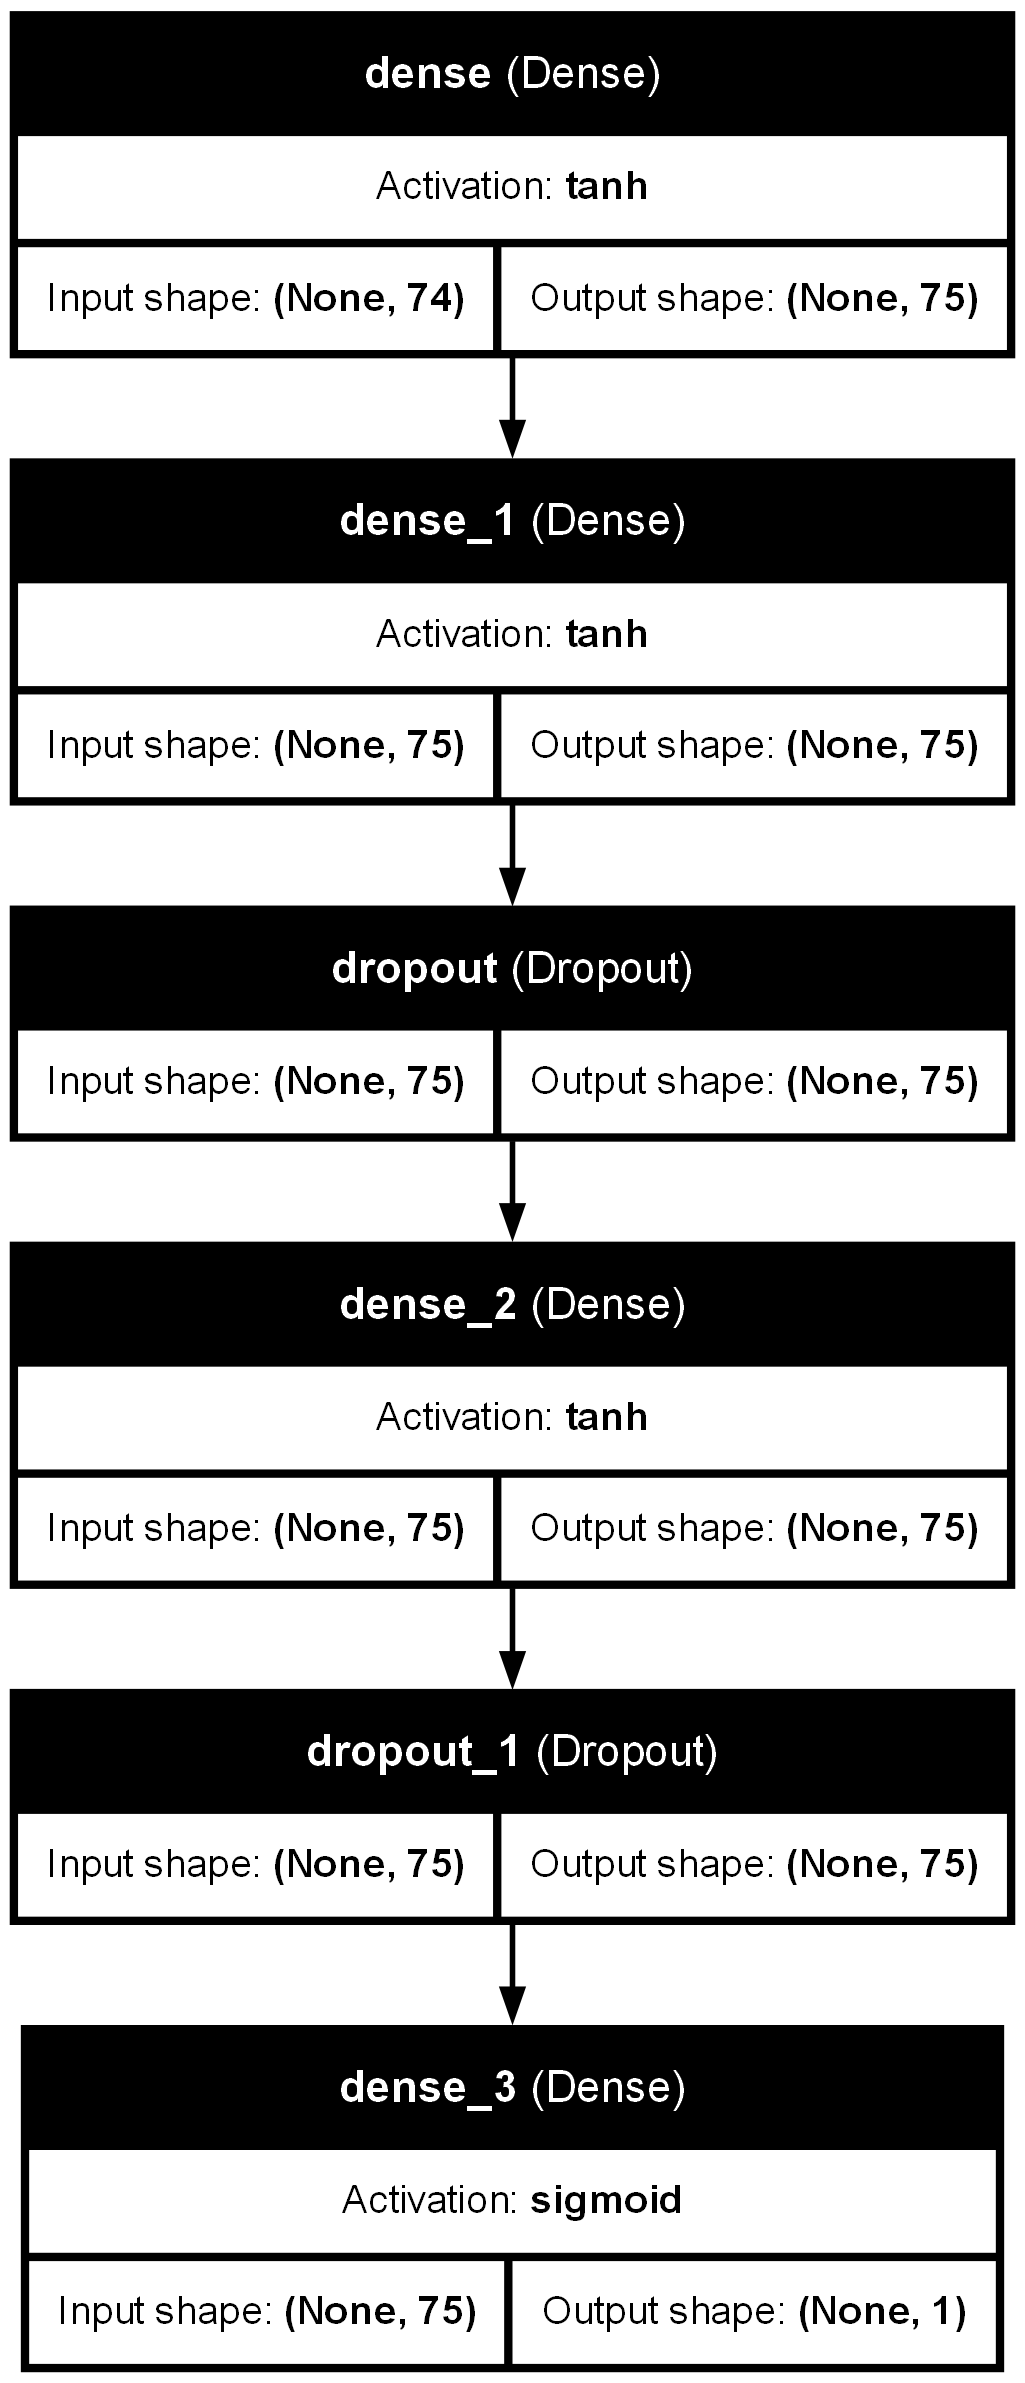

In [ ]:
# 21. Plot model diagram
plot_model(final_model, to_file='NN4.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [4]:
# 22. Check inference speed on test set
%timeit -r 10 -n 100 y_test_pred_prob = final_model.predict(X_test_processed)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
77/77 ━━━━━━━━━━